#Условие задачи
```
Классификация обращений граждан
В связи со сложной структурой и нелинейными зонами ответственности в
органах исполнительной и государственной власти, а также из-за большого
потока входящих сообщений разной направленности возникают сложности с
оперативной маршрутизацией сообщений непосредственным исполнителям.
Сообщение гражданина проходит длинную цепочку передачи «из рук в руки»,
что существенно уменьшает время, отведенное на непосредственное
устранение причин возникновения проблемы. А также растущая популярность
платформ обратной связи увеличивает нагрузку на модераторов и приводит к
росту штата персонала, обслуживающего работу порталов.
Условие задачи
Участникам чемпионата предлагается разработать классификатор для
автоматического определения категории запроса по тексту сообщения,
оставленному на сайте Администрации Курской области.
Создание такого алгоритма позволит сократить время ответа на
обращения жителей, так как существенно сократится время на предобработку и
маршрутизацию обращений.
Описание входных значений
● train.csv — содержит в себе 2000 обращений жителей Курска;
● test.сsv — неразмеченная тестовая выборка;
● sample_submission.csv — образец файла для отправки.
Метрика
В качестве метрики выступает Multi AUC-ROC.

```

## Setup & Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
from collections import Counter

In [ ]:
!pip install -q catboost

     |████████████████████████████████| 76.6 MB 74 kB/s 


In [ ]:
# https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb
#!pip install catboost
!pip install -q scikit-learn
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
#from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

In [ ]:
!pip install -q shap
import shap

In [ ]:
!pip install -q pymorphy2
# словарь https://pymorphy2.readthedocs.io/en/stable/user/guide.html
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Loading & Short Exploring

In [ ]:
train_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/train_dataset_train.csv'
test_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/test_dataset_test.csv'

In [ ]:
#df = pd.read_csv("/content/train.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## Data Analysis

### Total

In [ ]:
display(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   Текст Сообщения     1000 non-null   object
 2   Тематика            1000 non-null   object
 3   Ответственное лицо  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


None

None

### 'Тематика' по категориям

In [ ]:
# train
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Тематика']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Тематика                                                                                           
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений       155
Очистка от снега и наледи дорог в границах городских округов и сельских поселений                       44
Парковки на дорогах в границах городских округов и сельских поселений                                   38
Отсутствие твёрдого дорожного покрытия на дорогах в границах городских округов и сельских поселений     38
Светофоры на дорогах в границах городских округов и сельских поселений                                  36
Пешеходные переходы на дорогах в границах городских округов и сельских поселений                        36
Дорожные знаки на дорогах в границах городских округов и сельских поселений                             25
Освещение дорог в границах городских округов и сельских поселений                                       24
Безопасная дорога в школу на дор

**Человек легко может эти тематики сгруппировать по категориям и придмуать названия этим категориям  - как это сделать "машине"?**

(ЖКХ, Услуги связи, Транспорт, Льготы, Соцобеспечение, Медицина, Дороги, Строительные объекты, Дошкольные и образовательные учерждения...)

### 'Отв лицо' по категориям

In [ ]:
# train
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Ответственное лицо']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Ответственное лицо                                                                                          
Комитет дорожного хозяйства города Курска                                                                       129
Администрация города Курска                                                                                     127
Комитет транспорта и автомобильных дорог Курской области                                                         42
Администрация города Льгов                                                                                       30
Администрация Курского района                                                                                    28
Администрация Центрального округа города Курска                                                                  14
Администрация города Железногорска                                                                               14
Комитет городского хозяйства города Курска                         

**Нет явной привязки 'Отв лицо' к 'Категория'**
 - много повторов в разных категориях - - например администрация г.Курска
 - можно было предположить, что разные комитеты лтвечают за разную тематику и категории (ка кнапример в категории 14 , но в одной категории есть и различные по сути комитеты: здравохранения, цифрового развития, социального обеспечения, по труду и занятости Курской области (в категории 10)

### Записи Test с 'Тематика' , отсутствующими в Train

In [ ]:
print(subjects_test_not_in_train)
print("Обращений в test по тематикам, не вошедшим в train:\n",
    max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count()),
    'из', max(df_test.count()),
    f"или {max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())/max(df_test.count())*100:0.1f}%")
#df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].head()

['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Отсутствие в населённом пункте сотовой связи', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Проблемы с обеспечением питанием в школах']
Обращений в test по тематикам, не вошедшим в train:
 19 из 1000 или 1.9%


In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Тематика'].unique()), sorted(df_test['Тематика'].unique())))
subjects_train = sorted(df_train['Тематика'].unique())
subjects_test = sorted(df_test['Тематика'].unique())
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
subjects_train_not_in_test = [s for s in subjects_train if s not in subjects_test]
print("Тематика train, к-ой нет в test:",len(subjects_train_not_in_test), subjects_train_not_in_test[:10])
print("Тематика test, к-ой нет в train:", len(subjects_test_not_in_train), subjects_test_not_in_train)
print()
for s in subjects_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Тематика', к-ой нет в Train:")
print(f"{max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)])

False
Тематика train, к-ой нет в test: 54 ['Аварийное жильё', 'Вопросы оказания помощи беженцам', 'Дневник самонаблюдения', 'Загрязнение территории прилегающей к строительному объекту', 'Искусственные неровности на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере медицины', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере торговли', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу', 'Нарушение сроков реализации товара, оказания услуг']
Тематика test, к-ой нет в train: 12 ['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частны

,id,Текст Сообщения,Тематика,Ответственное лицо
45,2991,Добрый день! Я оформила своих детей во Дворец ...,Неудовлетворительное материально-техническое о...,Комитет образования города Курска
96,2749,"Здравствуйте, по улице Братская частного секто...",Необходимо строительство детской (спортивной) ...,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметк...,Дорожная разметка на дорогах регионального и м...,Комитет транспорта и автомобильных дорог Курск...
238,1916,Добрый день. \nПо области проходит не санкцион...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
256,679,"<p>Добрый день, несколько дней назад, напротив...",Дорожная разметка на дорогах регионального и м...,Комитет дорожного хозяйства города Курска
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлю...",Несправедливое распределение мест в дошкольные...,Администрация города Курска
482,643,"<p>Я незнаю куда ещё обращаться, может вы чем ...",Отсутствие в населённом пункте сотовой связи,Администрация города Льгов
699,2067,Здравствуйте я Полянская Диана Юрьевна 28.09....,Несправедливое распределение мест в дошкольные...,Администрация города Курска
706,46,<p>В городе Льгов в магазинах МАГНИТ не чувств...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
707,1237,<p>Отсутствует устойчивый сигнал сотовой связи...,Отсутствие в населённом пункте сотовой связи,Комитет цифрового развития и связи Курской обл...


### Записи Test с 'Отв лицо', отсутствующими в Train

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Ответственное лицо'].unique()), sorted(df_test['Ответственное лицо'].unique())))
resp_pers_train = sorted(df_train['Ответственное лицо'].unique())
resp_pers_test = sorted(df_test['Ответственное лицо'].unique())
resp_pers_test_not_in_train = [s for s in resp_pers_test if s not in resp_pers_train]
resp_pers_train_not_in_test = [s for s in resp_pers_train if s not in resp_pers_test]
print("Ответственное лицо train, к-ой нет в test:",len(resp_pers_train_not_in_test), resp_pers_train_not_in_test[:10])
print("Ответственное лицо test, к-ой нет в train:", len(resp_pers_test_not_in_train), resp_pers_test_not_in_train)
print()
for s in resp_pers_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Ответственное лицо', к-ого нет в Train:")
print(f"{max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)])

False
Ответственное лицо train, к-ой нет в test: 19 ['Администрация Большесолдатского района', 'Администрация Поныровского района', 'Администрация Тимского района', 'Администрация Хомутовского района', 'Администрация города Рыльска', 'Комитет агропромышленного комплекса Курской области', 'Комитет внутренней политики Администрации Курской области', 'Комитет информации и печати Курской области', 'Комитет образования и науки Курской области', 'Комитет по тарифам и ценам Курской области']
Ответственное лицо test, к-ой нет в train: 8 ['АО «Спецавтобаза по уборке города Курска»', 'Администрация г. Фатеж', 'Комитет по охране объектов культурного наследия Курской области', 'Комитет финансово-бюджетного контроля Курской области', 'ООО `УК `Маяк`', 'ООО `УК Курский завод КПД им. А.Ф. Дериглазова`', 'ООО УК `Парижское`', 'Управление культуры города Курска']

АО «Спецавтобаза по уборке города Курска»
Администрация г. Фатеж
Комитет по охране объектов культурного наследия Курской области
Комитет фин

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,<p>Добрый день! Шестой день отсутствует отопле...,Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
80,2426,Добрый день. Уже как три дня у нас нет воды на...,Некачественное водоснабжение в районе частного...,Администрация г. Фатеж
89,1819,<p>Производится свалка строительного мусора и ...,Несанкционированные свалки твёрдых бытовых отх...,АО «Спецавтобаза по уборке города Курска»
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина...",Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
403,1739,<p>Нужно вывести крупногабаритный мусор</p>,Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
405,1968,Прошу помочь разобраться в подозрении на корру...,Несвоевременная выплата заработной платы,Комитет финансово-бюджетного контроля Курской ...
486,1815,<p>Добрый день!&nbsp;</p><p>На театральной пло...,Низкое качество проведения культурно-массовых ...,Управление культуры города Курска
612,1737,<p>Нужно вывести крупногабаритный мусор.</p>,Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
870,2738,О проблеме уже сообщалось! Но всем откровенно ...,Неудовлетворительное санитарное состояние и бл...,Комитет по охране объектов культурного наследи...
908,1766,<p>Здравствуйте. Помогите решить проблему. С 2...,Длительное неисполнение заявок управляющей ком...,ООО УК `Парижское`


### Записи Test с 'Тематика' и 'Отв лицо', отсутствующими в Train

In [ ]:
# Итого
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)])
print(f" Итого: {max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,<p>Добрый день! Шестой день отсутствует отопле...,Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
45,2991,Добрый день! Я оформила своих детей во Дворец ...,Неудовлетворительное материально-техническое о...,Комитет образования города Курска
80,2426,Добрый день. Уже как три дня у нас нет воды на...,Некачественное водоснабжение в районе частного...,Администрация г. Фатеж
89,1819,<p>Производится свалка строительного мусора и ...,Несанкционированные свалки твёрдых бытовых отх...,АО «Спецавтобаза по уборке города Курска»
96,2749,"Здравствуйте, по улице Братская частного секто...",Необходимо строительство детской (спортивной) ...,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметк...,Дорожная разметка на дорогах регионального и м...,Комитет транспорта и автомобильных дорог Курск...
238,1916,Добрый день. \nПо области проходит не санкцион...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
256,679,"<p>Добрый день, несколько дней назад, напротив...",Дорожная разметка на дорогах регионального и м...,Комитет дорожного хозяйства города Курска
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина...",Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлю...",Несправедливое распределение мест в дошкольные...,Администрация города Курска


 Итого: 30 из 1000


## Data Preprocessing

### Define stop-words-list

#### Tokenizers by categories (train) 

In [ ]:
categories, categories_codes = df_train['Категория'].astype('category').cat.categories, df_train['Категория'].astype('category').cat.codes
categories = categories_codes = sorted(df_train['Категория'].unique())
#assert np.allclose(list(df_train['Категория'].astype('category').cat.categories), sorted(df_train['Категория'].unique()))
#display(df_train['Категория'].astype('category').cat.categories, df_train['Категория'].unique())
categories, categories_codes


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

##### function Preprocess text

In [ ]:
import re
import string
print(string.punctuation)
# +'href', 'https', 'ol', 'qr', 'yandex',
def preprocess_text(txt):
    #clean_text = txt
    clean_text = txt.lower()
    
    clean_text = re.sub(f'<span[a-zA-Z\s0-9{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<p[a-zA-Z\s0-9`№\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<br[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<strong[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<ul[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<li[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<span>|<\/span>|<p>|</p>|nbsp;|<br>|<strong>|<\/strong>|<b>|<ul>|<\/ul>|<li>|<\/li>'+
                        'href|li|https|ol|qr|yandex',
                        '', clean_text)
    clean_text = re.sub(f'[^а-яА-ЯёЁa-zA-Z\s0-9`№\n{string.punctuation}d+\.d+\.d+]','', clean_text)
    #clean_text = re.sub('<p>|</p>|nbsp;|<br>','', clean_text)
    clean_text = re.sub('\.[^\d+\.\d+\.\d+]',' . ', clean_text) # заменяем точки везде кроме дат
    #clean_text = re.sub('\.([\d+]\.[\d+]\.[\d+])',' . ', clean_text) # заменяем точки везде кроме дат
    clean_text = re.sub(f'\s[0-9]+\s|[0-9]+г',' ', clean_text) # убираем числа с пробелами вокруг
    clean_text = re.sub(f'[0-9]+|[0-9]+-[0-9]+','', clean_text) # убираем все числа 
    
    clean_text = clean_text.replace(',',' , ') # отделим запятые от слов, могут пригодиться при случае
    clean_text = clean_text.replace('\n',' ')
    clean_text = clean_text.replace('&','')
    return clean_text
txt = '<p>Добрый день.&nbsp;</p><p>На остановке `Площадь Рокоссовского` подземный'
#txt = ' привет 25.01.2022 поменяли фонари. а они не работают'
#txt = '<p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Здравствуйте.&nbsp;</span></p><p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Сегодня 26.01.2022 в 6:50 автобус ПАЗ (72 маршрут на Татаренкова (Волокно-Крюкова - Северное кладбище)) должен был останавливаться на ост. Рокоссовского в сторону центра города. Но он проехал мимо на большой скорости и не забрал ожидающих его пассажиров. И это уже не в первый раз происходит. На улице холодно, а стоять и ожидать автобус, пока водитель сам захочет остановиться - это издевательство. Примите, пожалуйста, необходимые меры.</span><br><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>С уважением,</span><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Половинкин В.С.</span></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом. &nbsp;Опасность возгарания.&nbsp;</strong></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом.&nbsp;</p><p>Опасность возгарания.&nbsp;</strong></p>'
txt = '<p><span style=`background-color:rgb(225,245,254);color:rgb(35,39,53);`>Огроменные ямы на перекрестке &nbsp;не соответствует ГОСТ Р 50597-93!! Размер больше 15 см. Аварийное состояние!!! 12 дней на устранение!!!</span></p>'

txt = ''''Переболела Ковид . ыписана 14.02.2022г . & На госуслуги до сих пор не пришел сертификат переболевшего . <span style=`background-color:#ffffff; color:#66727f`>Больничный лист № &\nПЦР COVID-19 № 7000 0000 9267 3190'
'''
preprocess_text(txt)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


"'переболела ковид  . ыписана ..   .  на госуслуги до сих пор не пришел сертификат переболевшего  . больничный лист №  пцр covid- №  ' "

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
stop_words_lst_cut = []
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс не реагировать на жалоба а мы как малый ветер сидеть без свет а именно в деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить и фотоотчёт сделать
нарушение связанный с содержание электросеть и качество энергоснабжение в район частное сектор


##### Tokenizers by categories

In [ ]:
tokenizers = []
search_word = 'style'
for cat in categories:
    texts_by_cat = df_train.loc[df_train['Категория']== cat]['Текст Сообщения'].values
    #print(cat, len(texts_by_cat), texts_by_cat[:2][:50])
    #texts_by_cat_clean = [preprocess_text(txt) for txt in texts_by_cat]
    texts_by_cat_clean = [txt2normal_form(preprocess_text(txt)) for txt in texts_by_cat]
    lst = [msg for msg in texts_by_cat_clean if search_word in msg]
    if len (lst)>0: print(lst)
    #print(texts_by_cat_clean[:2][:50])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts_by_cat_clean)
    tokenizers.append(tokenizer)

['помочь убрать аварийный дерево который находиться на против володарский  а именно напротив салон красота icon of style  неоднократно от это дерево падать сучка прям на припарковать машина  просить житель дом володарский ']


In [ ]:
# Кол-во слов в Словарях по категориям
for cat in categories:
    print(cat, len(tokenizers[cat].word_index))

0 3659
1 585
2 81
3 5515
4 1871
5 269
6 368
7 913
8 1893
9 200
10 997
11 527
12 4
13 432
14 276
15 239
16 1598


In [ ]:
lst = list(df_train['Категория'].value_counts().items())
appeals_num_lst = sorted(lst, key=lambda x: x[0]) #.values
print(appeals_num_lst)
#list(df_train['Категория'].value_counts( ).items())

[(0, 478), (1, 25), (2, 3), (3, 954), (4, 108), (5, 12), (6, 10), (7, 27), (8, 139), (9, 5), (10, 48), (11, 19), (12, 1), (13, 11), (14, 4), (15, 7), (16, 149)]


#### Define stop-words-list - execute

In [ ]:
def is_most_common_word_in_all_categories(word, threshold=.5, num_fst_most_common_words_const=300, tokenizers=tokenizers):
    word_in_all_categories = np.zeros(len(categories),dtype='int64')
    for c in categories:
        if word in list(tokenizers[c].word_index.keys())[:num_fst_most_common_words_const]:
            word_in_all_categories[c] = 1.0
        else: word_in_all_categories[c] = 0.0
    #print(word_in_all_categories)
    if word_in_all_categories.sum()/len(word_in_all_categories) >= threshold:
        result = True 
    else: result = False
    
    return result 
#is_most_common_word_in_other_categories('не', 1, 300)
is_most_common_word_in_all_categories('255',.5, 300)

False

In [ ]:
# v3 4
stop_words_lst = []
num_fst_most_common_words_const = 1000
threshold=.5 
# порог - доля категорий, в к-ых, по минимуму, должно присутсвовать слово-кандидат на Stop-Word-List

for cat in categories:
    num_fst_most_common_words = max(appeals_num_lst[cat][1],num_fst_most_common_words_const)
    #num_fst_most_common_words = appeals_num_lst[cat][1]
    # не больше количества обращений по категории
    #most_common_words_cat = list(tokenizers[cat].word_index.keys())[:num_fst_most_common_words]
    most_common_words_cat = [word for word, count in list(tokenizers[cat].word_index.items()) if count <= num_fst_most_common_words]
    stop_words_lst_cat = [word for word in most_common_words_cat 
                          if is_most_common_word_in_all_categories(word, threshold, num_fst_most_common_words_const)
                          and word not in stop_words_lst]
    #if cat>2: break
    #print(len(stop_words_lst_cat), stop_words_lst_cat)
    stop_words_lst.extend(stop_words_lst_cat)
    print(cat, appeals_num_lst[cat][1], len(stop_words_lst), stop_words_lst)
stop_words_lst_cut = list(set(stop_words_lst))
print(len(stop_words_lst_cut), stop_words_lst_cut)

0 478 189 ['в', 'и', 'на', 'не', 'дорога', 'по', 'с', 'улица', 'просить', 'что', 'быть', 'а', 'дом', 'от', 'к', 'ул', 'так', 'участок', 'год', 'это', 'вы', 'до', 'как', 'который', 'мы', 'для', 'данный', 'за', 'нет', 'день', 'но', 'этот', 'весь', '№', 'проблема', 'район', 'я', 'установить', 'добрый', 'из', 'курск', 'они', 'человек', 'уже', 'сделать', 'сторона', 'о', 'далее', 'житель', 'он', 'при', 'тот', 'место', 'время', 'ребёнок', 'город', 'работа', 'также', 'всё', 'очень', 'или', 'у', 'бы', 'то', 'здравствуйте', 'дать', 'мочь', 'находиться', 'состояние', 'наш', 'невозможно', 'курский', 'такой', 'администрация', 'после', 'мера', 'автомобиль', 'средство', 'принять', 'же', 'один', 'там', 'большой', 'когда', 'просто', 'ещё', 'работать', 'школа', 'только', 'область', 'вопрос', 'просьба', 'пожалуйста', 'есть', 'через', 'г', 'раз', 'решение', 'около', 'без', 'можно', 'ни', 'ответ', 'писать', 'адрес', 'свой', 'почему', 'она', 'чтобы', 'хотя', 'стоить', 'какой', 'два', 'если', 'ходить', 'прой

In [ ]:
print('мусор' in stop_words_lst_cut, 'провести' in stop_words_lst_cut, 'дети' in stop_words_lst_cut,
      'дом' in stop_words_lst_cut, 'дорога' in stop_words_lst_cut, 'детский' in stop_words_lst_cut,
      'ребёнок' in stop_words_lst_cut, 'связь' in stop_words_lst_cut)

False True False True True True True True


Есть, конечно, слова, к-ые несут и содержательный смысл, но их немного:
- дом, дорога, детский, ребёнок, связь

### Normalization/Lemmatization ['Текст Сообщения', 'Тематика']

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать
нарушение связанный содержание электросеть качество энергоснабжение район частное сектор


##### function preprocess_text_ext

In [ ]:
def preprocess_text_ext(txt, stop_words_lst_cut):
    # дополнительно исключает из предложений слова из stop_words_lst_cut
    word_lst = preprocess_text(txt).split(' ')
    #word_lst_clean = ' '.join([w for w in word_lst if w not in stop_words_lst_cut])
    word_lst_clean = ' '.join([w for w in word_lst if  w not in stop_words_lst_cut and
                                              w not in [',', '.'] # удалим отдельные точки и запятыq - здесь это не пригодится
                              ])
    return word_lst_clean

##### Lemmatization

In [ ]:
%%time
df_train['Msg'] = df_train['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Msg'] = df_test['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_train['Subject'] = df_train['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Subject'] = df_test['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))

df_train["Msg_normalized"] = df_train["Msg"].apply(lambda x: txt2normal_form(x))
df_test["Msg_normalized"] = df_test["Msg"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

CPU times: user 30.2 s, sys: 67.5 ms, total: 30.3 s
Wall time: 30.6 s


In [ ]:
df_train["Subject_normalized_not_unify"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized_not_unify"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

### Update 'Subject_normalized' 

#### Most_common_words 'Subject_normalized' 

In [ ]:
from pprint import pprint
from collections import Counter
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

most_common_words_by_category = []
num_most_common_words_cat = 10

for cat in categories:
    vc = df_train[['Subject_normalized']].loc[df_train['Категория']==cat].value_counts()
    subjects_cat = [ s[0] for s,c in vc.items()]
    nums_msg_by_subjects_cat = [ c for s,c in vc.items()]
    print("Category:",cat, "Num Subjects", len(subjects_cat))
    print(subjects_cat)
    print(nums_msg_by_subjects_cat)
    text = '. '.join(subjects_cat)
    #print(text)
    
    
    common_words_in_category = []
    for subject in subjects_cat:
        #print(subject)
        token_list = subject.split()
        #token_list = [re.sub('[^а-яА-Яa-zA-Z0-9№«»-]','', token) for token in token_list]
        #token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list]
        #print(token_list)
        for token in token_list:
            token_normal_form = morph.parse(token)[0].normal_form
            if token_normal_form not in string.punctuation + "«»" \
              and token_normal_form not in stop_words_lst_cut: 
              #token_normal_form not in common_words_in_category 
                common_words_in_category.append(token_normal_form)
        #print(20*'-')

    #if cat>2: break
    #print("common_words_in_category", common_words_in_category)
    most_common_words_in_category = Counter(common_words_in_category).most_common(num_most_common_words_cat)
    print("most_common_words_in_category", most_common_words_in_category)
    most_common_words_in_category = [w[0] for w in most_common_words_in_category]
    #print("most_common_words_in_category", most_common_words_in_category)
    print(100*'*')
    most_common_words_by_category.append(most_common_words_in_category)
    
for l in most_common_words_by_category:
    print(l)

Category: 0 Num Subjects 25
['нарушение дорожный покрытие ям дорога граница городской округ сельский поселение', 'очистка снег наледь дорога граница городской округ сельский поселение', 'парковка дорога граница городской округ сельский поселение', 'отсутствие твёрдый дорожный покрытие дорога граница городской округ сельский поселение', 'светофор дорога граница городской округ сельский поселение', 'пешеходный переход дорога граница городской округ сельский поселение', 'дорожный знак дорога граница городской округ сельский поселение', 'освещение дорога граница городской округ сельский поселение', 'безопасный школа дорога граница городской округ сельский поселение', 'освещение дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога региональный межмуниципальный значение', 'светофор дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога микрорайон ижс', 'очистка снег наледь дорога региональный межмуниципальный значение', 'остан

#### Update 'Subject_normalized' by 'Категория'  - in Test - if possible

##### Train

In [ ]:
for cat in categories:
    #df_train["Subject_normalized"].loc[df_train['Категория']==cat].apply(lambda x: ' '.join(most_common_words_by_category[cat]))
    df_train["Subject_normalized"].loc[df_train['Категория']==cat] = ' '.join(most_common_words_by_category[cat])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subjects_test_not_in_train
subj_cat = df_train[['Тематика','Категория' ]].value_counts()
#subj_cat = df_train[['Subject_normalized','Категория' ]].value_counts()
subj_cat_dict = {subj:cat for subj,cat in subj_cat.keys()}
print(list(subj_cat_dict.items())[:5])
subj_cat_dict['Неработающее наружное освещение']

[('Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений', 0), ('Неработающее наружное освещение', 3), ('Отсутствие люков на коммуникационных колодцах', 3), ('Несанкционированные свалки твёрдых бытовых отходов', 16), ('Аварийные деревья', 3)]


3

In [ ]:
subjects_test

##### Test

In [ ]:
for subject in subjects_test:
    if subject in subjects_train:
        cat = subj_cat_dict[subject]
        most_common_words_in_category = most_common_words_by_category[cat]
        #df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = most_common_words_in_category
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x: ' '.join(most_common_words_in_category))
    else: 
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
subject_normalized_train = df_train["Subject_normalized"].unique()
subject_normalized_test = df_test["Subject_normalized"].unique()
print("Train:", len(subject_normalized_train)) 
print(subject_normalized_train)
print("Test:", len(subject_normalized_test)) 
print(subject_normalized_test)

Train: 17
['многоквартирный дом содержание неудовлетворительный ижс микрорайон нарушение некачественный район тротуар'
 'безнадзорный животное'
 'несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах'
 'дорога граница городской округ сельский поселение дорожный региональный межмуниципальный значение'
 'мера поддержка условие неблагоприятный эпидемиологический ситуация сфера образование социальный льгота'
 'перевозка осуществление пригородный муниципальный внутриобластной междугородный нарушение транспорт неудовлетворительный движение'
 'нарушение обеспечение вакцинация связанный неудовлетворительный средство сертификат учреждение здравоохранение запись'
 'неудовлетворительный товар оказание услуга качество несанкционированный торговля нарушение срок реализация'
 'нарушение порядок вопрос помощь назначение выплата пособие компенсация предоставление мера'
 'строительный объект отсутствовать нарушение норма заморозить стройка неактуальный паспорт нез

Здесь, конечно большая подсказка сетке фактически для одинаковых категорий используются одни и те же нормализованные тематики по категориям (что примерно равно номеру категории)

Исключение для 12 тематик test, не вошедших в train

In [ ]:
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
len(subjects_test_not_in_train), subjects_test_not_in_train

(12,
 ['Дорожная разметка на дорогах регионального и межмуниципального значения',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц',
  'Необходимо строительство детской (спортивной) площадки в районе частного сектора',
  'Несоответствие ценника цене товара',
  'Несправедливое распределение мест в дошкольные учреждения',
  'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования',
  'Отсутствие в населённом пункте сотовой связи',
  'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения',
  'Очистка  от снега и наледи  дорог в микрорайонах ИЖС',
  'Плохое материально-техническое оснащение учреждений культуры и библиотек',
  'Проблемы с обеспечением питанием в школах'])

In [ ]:
# проверяемся
subject_normalized_test_not_in_train = [s for s in subject_normalized_test if s not in subject_normalized_train]
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство детский спортивный площадка район частный сектор',
  'дорожный разметка дорога региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение место дошкольный учреждение',
  'отсутствие населить пункт сотовый связь',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь дорога микрорайон ижс',
  'мера поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'мера поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'проблема обеспечение питание школа',
  'отсутствие твёрдый дорожный покрытие дорога региональный межмуниципальный значение'])

In [ ]:
text_columns = ['Msg', 'Subject', 'Rsp_prs',
                'Msg_normalized', 'Subject_normalized']

### Create 'Subject_normalized_ID' 

In [ ]:
subject_normalized = list(set(list(subject_normalized_train) + list(subject_normalized_test)))
len(subject_normalized), subject_normalized[:5], subject_normalized[-5:]

(29,
 ['спортивный учреждение физический культура спорт низкий качество неудовлетворительный содержание площадка',
  'нарушение обеспечение вакцинация связанный неудовлетворительный средство сертификат учреждение здравоохранение запись',
  'проблема обеспечение питание школа',
  'безнадзорный животное',
  'отсутствие твёрдый дорожный покрытие дорога региональный межмуниципальный значение'],
 ['тестовый категория',
  'услуга некачественный предоставление связь сотовый отсутствие доступ сеть интернет почтовый',
  'перевозка осуществление пригородный муниципальный внутриобластной междугородный нарушение транспорт неудовлетворительный движение',
  'неудовлетворительный учреждение дошкольный школа территория качество работа другой персонал материально-технический',
  'несоответствие ценник цена товар'])

In [ ]:
df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x))
df_test['Subject_normalized_ID'] = df_test['Subject_normalized'].apply(lambda x: subject_normalized.index(x))
print(len(df_train['Subject_normalized_ID'].value_counts()), len(df_test['Subject_normalized_ID'].value_counts()))
print(df_train['Subject_normalized_ID'].value_counts(), df_test['Subject_normalized_ID'].value_counts())

17 27
14    954
21    478
16    149
26    139
1     108
15     48
27     27
3      25
22     19
8      12
5      11
23     10
0       7
25      5
6       4
17      3
24      1
Name: Subject_normalized_ID, dtype: int64 14    503
21    227
26     65
16     63
1      46
15     27
3      14
27     10
8       9
5       6
0       3
22      3
20      3
7       2
23      2
28      2
18      2
6       2
12      2
9       2
13      1
10      1
2       1
17      1
11      1
19      1
4       1
Name: Subject_normalized_ID, dtype: int64


In [ ]:
print(text_columns)
display(df_train[text_columns].head(3), df_test[text_columns].head(3))

['Msg', 'Subject', 'Rsp_prs', 'Msg_normalized', 'Subject_normalized']


,Msg,Subject,Rsp_prs,Msg_normalized,Subject_normalized
0,Помогите начальник Льговского рэс реагирует жа...,Нарушения связанные содержанием электросети к...,Администрация Льговского,помочь начальник льговский рэс реагировать жал...,многоквартирный дом содержание неудовлетворите...
1,По фасаду Урицкого 22 проходит труба газовой м...,Аварийные деревья,Администрация Курска,по фасад урицкий 22 проходить труба газовый ма...,многоквартирный дом содержание неудовлетворите...
2,Агресивные собаки На радуге стая подросших щен...,Безнадзорные животные,Администрация Курска,агресивный собака на радуга стая подрасти щено...,безнадзорный животное


,Msg,Subject,Rsp_prs,Msg_normalized,Subject_normalized
0,Здравствуйте На Мира заменено наружное освещен...,Неработающее наружное освещение,Администрация Курчатовского,здравствуйте на мир заменить наружное освещени...,многоквартирный дом содержание неудовлетворите...
1,Уже вторую неделю горит уличное освещение,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства Курска,уже второй неделя гореть уличный освещение,многоквартирный дом содержание неудовлетворите...
2,Не работает освещение дворе 11а Энергетиков 6 ...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства Курска,не работать освещение двор 11а энергетик 6 све...,многоквартирный дом содержание неудовлетворите...


###Text ['Msg_normalized', 'Subject_normalized'] Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = CountVectorizer(max_features=15000, min_df=1, max_df=0.7, lowercase= True, stop_words=stop_words_lst_cut)
#vectorizer = TfidfVectorizer(lowercase= True, stop_words=stop_words_lst_cut)
vectorizer = TfidfVectorizer(lowercase= True, min_df=10, stop_words=stop_words_lst_cut) 
# min_df = 10 есть минмиум в 10 записяя корпуса текстов (здесь: train+test)

msg_train = list(df_train['Msg_normalized'].values)
msg_test = list(df_test['Msg_normalized'].values)
subj_train = list(df_train['Subject_normalized'].values)
subj_test = list(df_test['Subject_normalized'].values)

subj_train_not_unify = list(df_train['Subject_normalized_not_unify'].values)
subj_test_not_unify = list(df_test['Subject_normalized_not_unify'].values)

vectorizer.fit(clean_texts_train + clean_texts_test + subj_train + subj_test)

X_train_msg = vectorizer.transform(msg_train).toarray()
X_test_msg = vectorizer.transform(msg_test).toarray()
X_train_subj = vectorizer.transform(subj_train).toarray()
X_test_subj = vectorizer.transform(subj_test).toarray()

X_train_subj_not_unify = vectorizer.transform(subj_train_not_unify).toarray()
X_test_subj_not_unify = vectorizer.transform(subj_test_not_unify).toarray()

print(X_train_msg.shape, X_test_msg.shape)
print(X_train_subj.shape, X_test_subj.shape)
print(X_train_subj_not_unify.shape, X_test_subj_not_unify.shape)
print(vectorizer.get_feature_names())


(2000, 1663) (1000, 1663)
(2000, 1663) (1000, 1663)
(2000, 1663) (1000, 1663)
['covid', 'абсолютно', 'аварийный', 'авария', 'август', 'авто', 'автобус', 'автобусный', 'автовокзал', 'автодорога', 'автомобиль', 'автомобильный', 'автостанция', 'автотранспорт', 'ад', 'административный', 'администрация', 'адрес', 'ак', 'акт', 'александрович', 'аллея', 'анализ', 'апрель', 'аптека', 'ас', 'асфальт', 'асфальтировать', 'асфальтный', 'асфальтовый', 'ать', 'бабушка', 'бак', 'батарея', 'бездействие', 'бездействовать', 'бездомный', 'безнадзорный', 'безобразие', 'безопасно', 'безопасность', 'безопасный', 'береговой', 'бесплатный', 'бетон', 'бетонный', 'билет', 'благодарный', 'благоустройство', 'близкий', 'близлежащий', 'боец', 'болеть', 'больница', 'больничный', 'больной', 'больший', 'большинство', 'большой', 'бордюр', 'бордюрный', 'бояться', 'брать', 'бродячий', 'бросить', 'будт', 'бульвар', 'бурьян', 'бутылка', 'бывший', 'быстро', 'бытовой', 'быть', 'бюджет', 'вагон', 'важный', 'вакцина', 'вакцина

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Create Rsp_pers_ID

In [ ]:
rsp_pers = list(set(list(df_train['Ответственное лицо'].values) + list(df_test['Ответственное лицо'].values)))
print(len(rsp_pers), rsp_pers[:2])

83 ['Администрация Сеймского округа города Курска', 'Администрация города Рыльска']


In [ ]:
# Responsible person
df_train['Rsp_prs_ID'] = df_train['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))
df_test['Rsp_prs_ID'] = df_test['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))


## Create Dataset

In [ ]:
df_train.columns

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Subject', 'Subject_normalized', 'Msg', 'Msg_normalized', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Subject_normalized_not_unify'], dtype='object')

In [ ]:
X_train_msg_df = pd.DataFrame(X_train_msg, columns= ['msg_'+ str(i) for i in range(X_train_msg.shape[1])])
X_test_msg_df = pd.DataFrame(X_test_msg, columns= ['msg_'+ str(i) for i in range(X_test_msg.shape[1])])
X_train_subj_df = pd.DataFrame(X_train_subj, columns= ['subj_'+ str(i) for i in range(X_train_subj.shape[1])])
X_test_subj_df = pd.DataFrame(X_test_subj, columns= ['subj_'+ str(i) for i in range(X_test_subj.shape[1])])

X_train_subj_not_unify_df = pd.DataFrame(X_train_subj_not_unify, columns= ['subj_nu'+ str(i) for i in range(X_train_subj_not_unify.shape[1])])
X_test_subj_not_unify_df = pd.DataFrame(X_test_subj_not_unify, columns= ['subj_nu'+ str(i) for i in range(X_test_subj_not_unify.shape[1])])

display(X_train_msg_df.head(2), X_train_subj_df.head(2))
print(X_train_msg_df.shape, X_test_msg_df.shape)
print(X_train_subj_df.shape, X_test_subj_df.shape)
print(X_train_subj_not_unify_df.shape, X_test_subj_not_unify_df.shape)

,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,msg_8,msg_9,...,msg_1653,msg_1654,msg_1655,msg_1656,msg_1657,msg_1658,msg_1659,msg_1660,msg_1661,msg_1662
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.138214,0.0,0.0,0.0,0.0,0.0


,subj_0,subj_1,subj_2,subj_3,subj_4,subj_5,subj_6,subj_7,subj_8,subj_9,...,subj_1653,subj_1654,subj_1655,subj_1656,subj_1657,subj_1658,subj_1659,subj_1660,subj_1661,subj_1662
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2000, 1663) (1000, 1663)
(2000, 1663) (1000, 1663)
(2000, 1663) (1000, 1663)


#### Create Data Selections

Для классификаторов:
1. на Subject_normalized_ID
2. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify'] 
3. на векторизированных text_feature: ['Msg_normalized']
4. на Subject_normalized_ID, Rsp_pers_ID, векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify']
5. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized_not_unify'] 
- без feature_weighted
- c feature_weighted
6. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
6. на 'Rsp_pers_ID', на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 

In [ ]:
X_01 = df_train[['Subject_normalized_ID']]
X_01_test = df_test[['Subject_normalized_ID']]
y = df_train[["Категория"]]

X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)
X_02_test = pd.concat([X_test_msg_df, X_test_subj_df], axis=1)

X_03 = X_train_msg_df
X_03_test = X_test_msg_df

X_04 = pd.concat([df_train[['Subject_normalized_ID', 'Rsp_prs_ID']], X_train_msg_df, X_train_subj_df], axis=1)
X_04_test = pd.concat([df_test[['Subject_normalized_ID', 'Rsp_prs_ID']], X_test_msg_df, X_test_subj_df], axis=1)

X_05 = pd.concat([X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_05_test = pd.concat([X_test_msg_df, X_test_subj_not_unify_df], axis=1)

X_06 = pd.concat([X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_06_test = pd.concat([X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

X_07 = pd.concat([df_train[['Rsp_prs_ID']], X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_07_test = pd.concat([df_test[['Rsp_prs_ID']], X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

print(X_01.shape, X_01_test.shape)
print(X_02.shape, X_02_test.shape)
print(X_03.shape, X_03_test.shape)
print(X_04.shape, X_04_test.shape)
print(X_05.shape, X_05_test.shape)
print(X_06.shape, X_06_test.shape)
print(X_07.shape, X_07_test.shape)
print(y.shape)

(2000, 1) (1000, 1)
(2000, 3326) (1000, 3326)
(2000, 1663) (1000, 1663)
(2000, 3328) (1000, 3328)
(2000, 3326) (1000, 3326)
(2000, 4989) (1000, 4989)
(2000, 4990) (1000, 4990)
(2000, 1)


In [ ]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_01, y, test_size=0.2, random_state=42)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_02, y, test_size=0.2, random_state=42)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_03, y, test_size=0.2, random_state=42)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_04, y, test_size=0.2, random_state=42)
X_train_05, X_val_05, y_train_05, y_val_05 = train_test_split(X_05, y, test_size=0.2, random_state=42)
X_train_06, X_val_06, y_train_06, y_val_06 = train_test_split(X_06, y, test_size=0.2, random_state=42)
X_train_07, X_val_07, y_train_07, y_val_07 = train_test_split(X_07, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train_01.shape, X_val_01.shape, y_train_01.shape, y_val_01.shape)

(1600, 1) (400, 1) (1600, 1) (400, 1)


In [ ]:
# v02 для RandomForest 
X = X_train_msg_df
X_test = X_test_msg_df
y = df_train[["Категория"]]
print(X.shape, X_test.shape, y.shape)

(2000, 1472) (1000, 1472) (2000, 1)


## Train

### Params

#### Clf_01

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from catboost import CatBoostClassifier
clf_01_params = {
    'iterations': 50,
    'learning_rate':0.05,
    'random_seed': 42, 
    #'text_features': text_columns, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 20,
    'loss_function':'MultiClass', # лучше Accuracy 0.985 vs .958
    #'loss_function':'MultiClassOneVsAll',
                                                         
}

clf_01 = CatBoostClassifier( **clf_01_params)

#### Clf_02

In [ ]:
clf_02_params = {
    'iterations': 300,
    'learning_rate':0.05,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 40,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}

clf_02 = CatBoostClassifier( **clf_02_params)

#### Clf_03

In [ ]:
clf_03_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}

clf_03 = CatBoostClassifier( **clf_03_params)

#### Clf_04 v_01

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_04 = CatBoostClassifier( **clf_04_params)

#### Clf_04 v_02 feature_weights

In [ ]:
print(len(X_04.columns), X_04.columns[:5], X_04.columns[len(X_04.columns)//2:len(X_04.columns)//2+4])
feature_weights = [.88, .75] + [.5] * (len(X_04.columns)-2)
print(len(feature_weights), feature_weights[:5])

3328 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'msg_0', 'msg_1', 'msg_2'], dtype='object') Index(['msg_1662', 'subj_0', 'subj_1', 'subj_2'], dtype='object')
3328 [0.88, 0.75, 0.5, 0.5, 0.5]


In [ ]:
clf_04_02_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
    'feature_weights': feature_weights,
                                                         
}
clf_04_02 = CatBoostClassifier( **clf_04_02_params)

#### Clf_05 v_01

In [ ]:
clf_05_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_05 = CatBoostClassifier( **clf_05_params)

#### Clf_05 v_02 feature_weights

In [ ]:
print(len(X_05.columns), X_05.columns[:5], X_05.columns[len(X_05.columns)//2:len(X_05.columns)//2+4])
feature_weights = [.88, .75] + [.5] * (len(X_05.columns)-2)
print(len(feature_weights), feature_weights[:5])

3328 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'msg_0', 'msg_1', 'msg_2'], dtype='object') Index(['msg_1662', 'subj_0', 'subj_1', 'subj_2'], dtype='object')
3328 [0.88, 0.75, 0.5, 0.5, 0.5]


In [ ]:
clf_04_02_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
    'feature_weights': feature_weights,
                                                         
}
clf_04_02 = CatBoostClassifier( **clf_04_02_params)

#### Clf_06 v_01

In [ ]:
clf_06_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_06 = CatBoostClassifier( **clf_06_params)

#### Clf_07 v_01

In [ ]:
clf_07_params = {
    'iterations': 1000,
    'learning_rate':0.05,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    'subsample': 0.8,
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_07 = CatBoostClassifier( **clf_07_params)

### Train execute CatBoost

#### clf_01 v01   Accuracy

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
clf_01.fit(X_train_01, y_train_01,
          eval_set=(X_val_01, y_val_01), # для сетки все однозначно, даже  if is_scalar(key) and isna(key) and not self.hasnans
          #plot=True
        )
#plt.show()

0:	learn: 0.9243750	test: 0.9275000	best: 0.9275000 (0)	total: 17.7ms	remaining: 865ms
10:	learn: 0.9300000	test: 0.9225000	best: 0.9275000 (0)	total: 103ms	remaining: 365ms
20:	learn: 0.9793750	test: 0.9750000	best: 0.9750000 (20)	total: 144ms	remaining: 199ms
30:	learn: 0.9793750	test: 0.9750000	best: 0.9750000 (20)	total: 179ms	remaining: 110ms
40:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (38)	total: 256ms	remaining: 56.1ms
49:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (38)	total: 315ms	remaining: 0us

bestTest = 0.98
bestIteration = 38

Shrink model to first 39 iterations.


#### clf_01 v02 AUC

In [ ]:
clf_01_params = {
    'iterations': 50,
    'learning_rate':0.05,
    'random_seed': 42, 
    #'text_features': text_columns, 
    'verbose': 10,
    'allow_writing_files': False,
    'eval_metric': 'AUC',
    #'eval_metric': 'ROC',
    #'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 20,
    'loss_function':'MultiClass', # лучше Accuracy 0.985 vs .958
    #'loss_function':'MultiClassOneVsAll',
                                                         
}

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
clf_01.fit(X_train_01, y_train_01,
          eval_set=(X_val_01, y_val_01), # для сетки все однозначно, даже  if is_scalar(key) and isna(key) and not self.hasnans
          #plot=True
        )
#plt.show()

0:	learn: 0.9243750	test: 0.9275000	best: 0.9275000 (0)	total: 6.77ms	remaining: 332ms
10:	learn: 0.9300000	test: 0.9225000	best: 0.9275000 (0)	total: 74ms	remaining: 262ms
20:	learn: 0.9793750	test: 0.9750000	best: 0.9750000 (20)	total: 136ms	remaining: 187ms
30:	learn: 0.9793750	test: 0.9750000	best: 0.9750000 (20)	total: 204ms	remaining: 125ms
40:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (38)	total: 244ms	remaining: 53.6ms
49:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (38)	total: 273ms	remaining: 0us

bestTest = 0.98
bestIteration = 38

Shrink model to first 39 iterations.


#### clf_02 v01 Accuracy

In [ ]:
clf_02.fit(X_train_02, y_train_02,
          eval_set=(X_val_02, y_val_02), 
          #plot=True
        )
#

0:	learn: 0.8625000	test: 0.8475000	best: 0.8475000 (0)	total: 684ms	remaining: 3m 24s
10:	learn: 0.9518750	test: 0.9500000	best: 0.9500000 (4)	total: 8.51s	remaining: 3m 43s
20:	learn: 0.9631250	test: 0.9650000	best: 0.9650000 (20)	total: 15.1s	remaining: 3m 21s
30:	learn: 0.9787500	test: 0.9800000	best: 0.9800000 (28)	total: 22.5s	remaining: 3m 15s
40:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (36)	total: 29.5s	remaining: 3m 6s
50:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (50)	total: 36.3s	remaining: 2m 57s
60:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (50)	total: 43.2s	remaining: 2m 49s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (69)	total: 50.1s	remaining: 2m 41s
80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (69)	total: 56.9s	remaining: 2m 33s
90:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (69)	total: 1m 4s	remaining: 2m 28s
100:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (69)	total: 1m 11s	remaining: 2m 20s
Stopped by overfitting 

#### clf_03 v01 Accuracy

In [ ]:
clf_03.fit(X_train_03, y_train_03,
          eval_set=(X_val_03, y_val_03), 
          #plot=True
        )
#

0:	learn: 0.5206250	test: 0.5025000	best: 0.5025000 (0)	total: 3.66s	remaining: 1h 55s
10:	learn: 0.5562500	test: 0.5275000	best: 0.5300000 (9)	total: 42.2s	remaining: 1h 3m 10s
20:	learn: 0.5793750	test: 0.5550000	best: 0.5550000 (19)	total: 1m 19s	remaining: 1h 1m 44s
30:	learn: 0.5981250	test: 0.5725000	best: 0.5725000 (30)	total: 1m 55s	remaining: 1h 17s
40:	learn: 0.6156250	test: 0.5875000	best: 0.5875000 (40)	total: 2m 31s	remaining: 59m 11s
50:	learn: 0.6287500	test: 0.5975000	best: 0.5975000 (50)	total: 3m 8s	remaining: 58m 29s
60:	learn: 0.6425000	test: 0.6050000	best: 0.6050000 (59)	total: 3m 44s	remaining: 57m 40s
70:	learn: 0.6500000	test: 0.6075000	best: 0.6075000 (63)	total: 4m 21s	remaining: 57m 1s
80:	learn: 0.6631250	test: 0.6225000	best: 0.6225000 (79)	total: 4m 58s	remaining: 56m 22s
90:	learn: 0.6775000	test: 0.6375000	best: 0.6400000 (88)	total: 5m 34s	remaining: 55m 36s
100:	learn: 0.6837500	test: 0.6525000	best: 0.6525000 (100)	total: 6m 10s	remaining: 55m 1s
110

#### clf_04 v01 Accuracy

In [ ]:
clf_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
          #plot=True
        )
#

0:	learn: 0.8643750	test: 0.8550000	best: 0.8550000 (0)	total: 3.71s	remaining: 1h 1m 43s
10:	learn: 0.9368750	test: 0.9425000	best: 0.9450000 (9)	total: 42.3s	remaining: 1h 3m 24s
20:	learn: 0.9643750	test: 0.9650000	best: 0.9650000 (18)	total: 1m 19s	remaining: 1h 1m 45s
30:	learn: 0.9787500	test: 0.9800000	best: 0.9800000 (28)	total: 1m 57s	remaining: 1h 1m 12s
40:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (28)	total: 2m 35s	remaining: 1h 37s
50:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (47)	total: 3m 13s	remaining: 59m 52s
60:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (54)	total: 3m 48s	remaining: 58m 44s
70:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (54)	total: 4m 26s	remaining: 58m 12s
80:	learn: 0.9962500	test: 0.9925000	best: 0.9950000 (78)	total: 5m 4s	remaining: 57m 30s
90:	learn: 0.9962500	test: 0.9925000	best: 0.9950000 (78)	total: 5m 42s	remaining: 57m
100:	learn: 0.9962500	test: 0.9950000	best: 0.9950000 (78)	total: 6m 19s	remaining: 56m 22s
1

#### clf_04 v02 Accuracy

In [ ]:
clf_04_02.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
          #plot=True
        )
#

0:	learn: 0.9393750	test: 0.9450000	best: 0.9450000 (0)	total: 4.11s	remaining: 1h 8m 29s
10:	learn: 0.9487500	test: 0.9575000	best: 0.9575000 (6)	total: 45.1s	remaining: 1h 7m 33s
20:	learn: 0.9487500	test: 0.9575000	best: 0.9625000 (19)	total: 1m 24s	remaining: 1h 5m 20s
30:	learn: 0.9693750	test: 0.9700000	best: 0.9700000 (30)	total: 2m 2s	remaining: 1h 4m 4s
40:	learn: 0.9693750	test: 0.9700000	best: 0.9700000 (30)	total: 2m 44s	remaining: 1h 3m 56s
50:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (43)	total: 3m 25s	remaining: 1h 3m 40s
60:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (43)	total: 4m 7s	remaining: 1h 3m 22s
70:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (67)	total: 4m 48s	remaining: 1h 2m 59s
80:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (67)	total: 5m 30s	remaining: 1h 2m 26s
90:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (67)	total: 6m 12s	remaining: 1h 1m 56s
100:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (94)	total: 6m 49s	remai

#### clf_05 v01 Accuracy

In [ ]:
clf_05.fit(X_train_05, y_train_05,
          eval_set=(X_val_05, y_val_05), 
          #plot=True
        )
#

0:	learn: 0.7906250	test: 0.7850000	best: 0.7850000 (0)	total: 4.28s	remaining: 1h 11m 20s
10:	learn: 0.8093750	test: 0.7975000	best: 0.8125000 (8)	total: 47s	remaining: 1h 10m 28s
20:	learn: 0.8162500	test: 0.8125000	best: 0.8125000 (8)	total: 1m 30s	remaining: 1h 10m 29s
30:	learn: 0.8300000	test: 0.8250000	best: 0.8250000 (30)	total: 2m 13s	remaining: 1h 9m 25s
40:	learn: 0.8700000	test: 0.8725000	best: 0.8725000 (40)	total: 2m 55s	remaining: 1h 8m 22s
50:	learn: 0.8737500	test: 0.8800000	best: 0.8800000 (50)	total: 3m 38s	remaining: 1h 7m 36s
60:	learn: 0.8900000	test: 0.8975000	best: 0.8975000 (59)	total: 4m 20s	remaining: 1h 6m 53s
70:	learn: 0.8962500	test: 0.8975000	best: 0.8975000 (59)	total: 5m 1s	remaining: 1h 5m 48s
80:	learn: 0.8981250	test: 0.9050000	best: 0.9075000 (79)	total: 5m 44s	remaining: 1h 5m 3s
90:	learn: 0.9093750	test: 0.9125000	best: 0.9125000 (87)	total: 6m 27s	remaining: 1h 4m 32s
100:	learn: 0.9200000	test: 0.9250000	best: 0.9250000 (99)	total: 7m 10s	rema

#### clf_06 v01 Accuracy

In [ ]:
clf_06.fit(X_train_06, y_train_06,
          eval_set=(X_val_06, y_val_06), 
          #plot=True
        )
# 

0:	learn: 0.9518750	test: 0.9475000	best: 0.9475000 (0)	total: 4.35s	remaining: 1h 12m 24s
10:	learn: 0.9518750	test: 0.9500000	best: 0.9500000 (1)	total: 49.7s	remaining: 1h 14m 25s
20:	learn: 0.9637500	test: 0.9650000	best: 0.9650000 (17)	total: 1m 32s	remaining: 1h 12m 2s
30:	learn: 0.9731250	test: 0.9750000	best: 0.9750000 (29)	total: 2m 16s	remaining: 1h 10m 54s
40:	learn: 0.9787500	test: 0.9800000	best: 0.9800000 (37)	total: 2m 59s	remaining: 1h 9m 56s
50:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (46)	total: 3m 44s	remaining: 1h 9m 34s
60:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (46)	total: 4m 29s	remaining: 1h 9m 3s
70:	learn: 0.9912500	test: 0.9875000	best: 0.9875000 (46)	total: 5m 13s	remaining: 1h 8m 19s
80:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (72)	total: 5m 57s	remaining: 1h 7m 40s
90:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (72)	total: 6m 41s	remaining: 1h 6m 49s
100:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (72)	total: 7m 23s	

#### clf_07 v01 Accuracy

In [ ]:
clf_07.fit(X_train_07, y_train_07,
          eval_set=(X_val_07, y_val_07), 
          #plot=True
        )
#

0:	learn: 0.9168750	test: 0.9025000	best: 0.9025000 (0)	total: 4.59s	remaining: 1h 16m 27s
10:	learn: 0.9162500	test: 0.9150000	best: 0.9150000 (10)	total: 50.7s	remaining: 1h 15m 57s
20:	learn: 0.9475000	test: 0.9450000	best: 0.9450000 (20)	total: 1m 44s	remaining: 1h 20m 50s
30:	learn: 0.9662500	test: 0.9675000	best: 0.9675000 (29)	total: 2m 30s	remaining: 1h 18m 24s
40:	learn: 0.9812500	test: 0.9825000	best: 0.9825000 (40)	total: 3m 16s	remaining: 1h 16m 43s
50:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (47)	total: 4m 4s	remaining: 1h 15m 46s
60:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (47)	total: 4m 52s	remaining: 1h 14m 57s
70:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (47)	total: 5m 38s	remaining: 1h 13m 53s
80:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (80)	total: 6m 25s	remaining: 1h 12m 50s
90:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (80)	total: 7m 12s	remaining: 1h 12m 1s
100:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (95)	total: 

## Evaluate

In [ ]:
print(clf_01.get_best_score())
print(clf_01.score(X_val_01, y_val_01))
print('Tree count: ' + str(clf_01.tree_count_))

{'learn': {'Accuracy': 0.985, 'MultiClass': 0.18130156132537778}, 'validation': {'Accuracy': 0.98, 'MultiClass': 0.19271215755177684}}
0.98
Tree count: 39


In [ ]:
print(clf_02.get_best_score())
print(clf_02.score(X_val_02, y_val_02))
print('Tree count: ' + str(clf_02.tree_count_))

{'learn': {'Accuracy': 0.99875, 'MultiClass': 0.06039136510907826}, 'validation': {'Accuracy': 0.995, 'MultiClass': 0.07389376387263044}}
0.995
Tree count: 70


## Feature impotance

In [ ]:
sorted(list(zip(clf_01.feature_names_,clf_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)

[('Subject_normalized_ID', 100.0)]

In [ ]:
sorted(list(zip(clf_02.feature_names_,clf_02.feature_importances_))[:10],key=lambda x:x[1], reverse=True)

[('msg_0', 0.0),
 ('msg_1', 0.0),
 ('msg_2', 0.0),
 ('msg_3', 0.0),
 ('msg_4', 0.0),
 ('msg_5', 0.0),
 ('msg_6', 0.0),
 ('msg_7', 0.0),
 ('msg_8', 0.0),
 ('msg_9', 0.0)]

In [ ]:
sorted(list(zip(clf_03.feature_names_,clf_03.feature_importances_))[:10],key=lambda x:x[1], reverse=True)

[('msg_6', 1.1648944242253287),
 ('msg_0', 0.018898308603940404),
 ('msg_1', 0.00046892475660614277),
 ('msg_2', 0.0),
 ('msg_3', 0.0),
 ('msg_4', 0.0),
 ('msg_5', 0.0),
 ('msg_7', 0.0),
 ('msg_8', 0.0),
 ('msg_9', 0.0)]

#### Plot Tree

In [ ]:
from google.colab import output
#output.

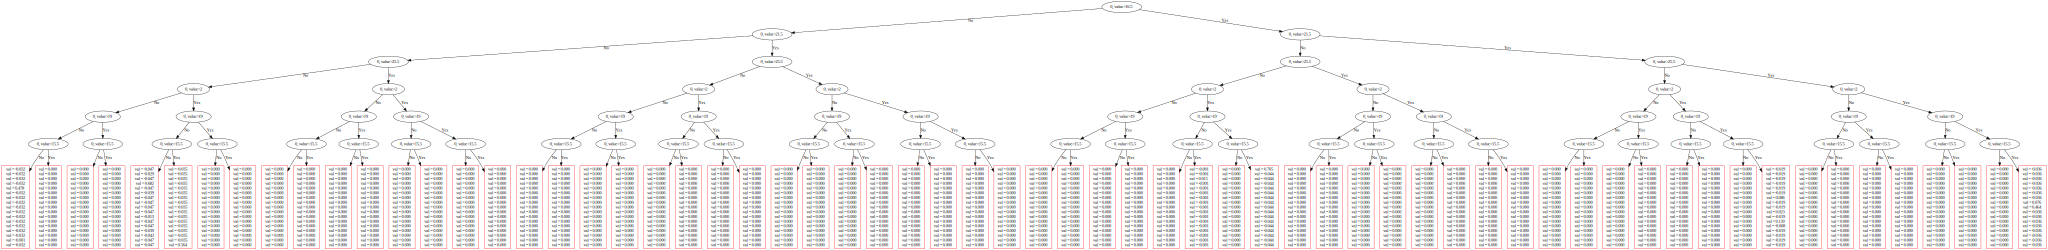

<Figure size 864x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,10))
from catboost import CatBoost, Pool
#pool = Pool(X_train, y_train, text_features=text_columns, feature_names=list(X_train.columns))

#model = CatBoost(
#    max_depth=2, verbose=False, max_ctr_complexity=1, iterations=2).fit(pool)
#
clf_01.plot_tree(
    tree_idx=0,
#    pool=pool
)


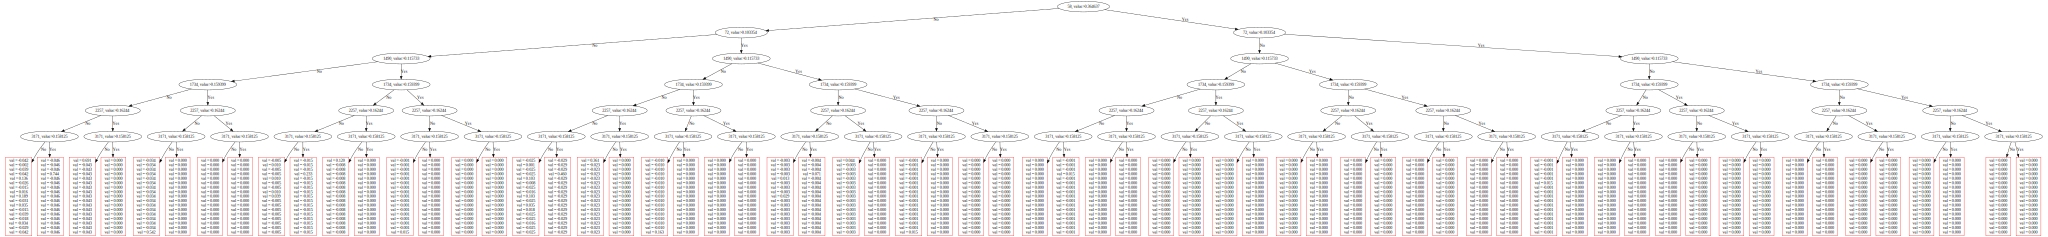

<Figure size 864x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,10))
clf_02.plot_tree(
    tree_idx=0,
#    pool=pool
)

In [ ]:
vectorizer.get_feature_names() [58] # 'большой" [888] # покрытие [1554] -'тротуар #[6434] - 'землей'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'большой'

## Predict

Clf_01

In [ ]:
y_test_01 = clf_01.predict(X_01_test)
y_test_02 = clf_02.predict(X_02_test)

In [ ]:
print(y_test_01.shape, X_01_test.shape)
print(y_test_02.shape, X_02_test.shape)
#y_test_01

(1000, 1) (1000, 1)
(1000, 1) (1000, 3326)


In [ ]:
df_y_test_01 = pd.DataFrame(y_test_01, columns=['Категория'], index=df_test['id'].values) 
df_y_test_02 = pd.DataFrame(y_test_02, columns=['Категория'], index=df_test['id'].values) 
#display(df_y_test_01.head(2)) #, df_y_test.tail())

In [ ]:
print(df_y_test_01["Категория"].value_counts())
# score 0.883550
print(df_y_test_02["Категория"].value_counts())
# score 0.977

3     523
0     234
8      65
16     63
4      50
10     27
1      15
7      12
13      6
11      3
6       2
Name: Категория, dtype: int64
3     503
0     230
16     74
8      65
4      46
10     27
7      14
1      14
5       9
13      6
6       4
11      3
15      3
14      2
Name: Категория, dtype: int64


### Clf_03

In [ ]:
y_test_03 = clf_03.predict(X_03_test)
print(y_test_02.shape, X_02_test.shape)
df_y_test_03 = pd.DataFrame(y_test_03, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_03["Категория"].value_counts())

(1000, 1) (1000, 3326)
3     635
0     198
8      58
16     42
4      35
10     17
1      11
13      2
7       2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v03_clf_03_1750.csv'
df_y_test_03.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,3


### Clf_04 v01

In [ ]:
y_test_04 = clf_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 3, 0.982796

3     503
0     230
16     71
8      65
4      46
10     28
1      17
7      15
5       9
13      6
6       4
11      3
15      3
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v04_clf_04_1750.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Clf_04 v02

In [ ]:
y_test_04_02 = clf_04_02.predict(X_04_test)
df_y_test_04_02 = pd.DataFrame(y_test_04_02, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04_02["Категория"].value_counts())
# 07, score 0.950246

3     503
0     230
16     71
8      65
4      46
10     28
1      17
7      15
5       9
13      6
6       4
11      3
15      3
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v05_clf_04_02_1850.csv'
df_y_test_04_02.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Clf_05 v01

In [ ]:
y_test_05 = clf_05.predict(X_05_test)
df_y_test_05 = pd.DataFrame(y_test_05, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_05["Категория"].value_counts())
# 12, score 0.837649

3     548
0     233
8      62
16     57
4      41
10     27
1      14
7      10
5       5
11      2
6       1
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v06_clf_05_1950.csv'
df_y_test_05.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Clf_06 v01

In [ ]:
y_test_06 = clf_06.predict(X_06_test)
df_y_test_06 = pd.DataFrame(y_test_06, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_06["Категория"].value_counts())
# place , score 
# 05, 0.970891

3     505
0     232
16     72
8      65
4      48
10     27
1      14
7      12
5       9
13      6
6       4
11      3
15      3
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v07_clf_06_2050.csv'
df_y_test_06.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Clf_07 v01

In [ ]:
y_test_07 = clf_07.predict(X_07_test)
df_y_test_07 = pd.DataFrame(y_test_07, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_07["Категория"].value_counts())
# place , score 
# 5, 0.971270

3     503
0     239
8      65
16     64
4      50
10     28
1      14
7      10
5       9
13      6
6       4
11      3
15      3
14      2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v08_clf_07_2120.csv'
df_y_test_07.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


In [ ]:
np.savetxt('np_'+ fn, np.hstack([df_test['id'].values.reshape(-1,1), y_test_07]), 
           delimiter=',', header='id, Категория', fmt='%d', comments='')
!head -5 'np_''$fn'
# вставляет # когда comments по умолчанию (='#')

id, Категория
843,3
1422,3
2782,3
2704,3


In [ ]:
np.savetxt?

In [ ]:
y_test_01 = clf_01.predict(X_01_test)
print(y_test_01.shape)

(1000, 1)


In [ ]:
df_y_test_01 = pd.DataFrame(y_test_01, columns=['Категория'], index=df_test['id'].values) 


In [ ]:
print(df_y_test_01["Категория"].value_counts())
# score 

3     523
0     234
8      65
16     63
4      50
10     27
1      15
7      12
13      6
11      3
6       2
Name: Категория, dtype: int64


pred score 0.8835
```
3     523
0     234
8      65
16     63
4      50
10     27
1      15
7      12
13      6
11      3
6       2
Name: Категория, dtype: int64
3     503
0     230
16     74
8      65
4      46
10     27
7      14
1      14
5       9
13      6
6       4
11      3
15      3
14      2
```

witout lemmatization
```
3     733
0     166
8      40
16     34
4      15
10      8
1       3
7       1
```

pred score
```
0.883
3     503
0     230
8      65
16     63
4      48
10     31
1      26
7      23
13      6
11      3
6       2
0.830357
3     532
0     233
8      68
16     63
4      46
10     27
1      14
7      10
11      2
5       2
13      2
6       1

```

### Prepare Submission

In [ ]:
fn = 'submission_2022_07_21_v01_1525.csv'
df_y_test_01.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


In [ ]:
fn = 'submission_2022_07_21_v02_1530.csv'
df_y_test_02.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Train execute RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

In [ ]:
X.shape

(2000, 1472)

In [ ]:
>>> from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
>>> sorted(clf.cv_results_.keys())


In [ ]:
clf.fit(#np.ravel(X_train_msg), y.values,
        X_train_msg, np.ravel(y.values),
          #eval_set=(X_val, y_val),
          #plot=True
        )


RandomForestClassifier(random_state=42)

In [ ]:
#print(clf.get_best_score())
print(clf.score(X_val, y_val))
#print('Tree count: ' + str(clf.tree_count_))

0.9966666666666667


## Feature impotance

In [ ]:
#sorted(list(zip(clf.feature_names_,clf.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
clf.feature_importances_

array([0.00109699, 0.00010656, 0.00062412, ..., 0.00289699, 0.00251211,
       0.00023586])

## Predict

In [ ]:
pred = clf.predict(X_test)

In [ ]:
y_test = pred

In [ ]:
df_y_test = pd.DataFrame(y_test, columns=['Категория'], index=df_test['id'].values)
display(df_y_test.head()) #, df_y_test.tail())

,Категория
843,3
1422,3
2782,3
2704,3
1,8


In [ ]:
df_y_test["Категория"].value_counts()
# score  0.683380

3     567
0     223
8      67
4      51
16     49
10     20
1      15
6       2
5       2
13      2
7       2
Name: Категория, dtype: int64

with lemmatization
```
3     733
0     166
8      40
16     34
4      15
10      8
1       3
7       1
```
witout lemmatization
```
3     733
0     166
8      40
16     34
4      15
10      8
1       3
7       1
```

pred score
```
0.883
3     503
0     230
8      65
16     63
4      48
10     31
1      26
7      23
13      6
11      3
6       2
0.830357
3     532
0     233
8      68
16     63
4      46
10     27
1      14
7      10
11      2
5       2
13      2
6       1

```

### Prepare Submission

In [ ]:
fn = 'submission_2022_07_20_v01_1940.csv'
df_y_test.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,3


## Setup & Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
from collections import Counter

In [ ]:
!pip install -q catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
# https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb
#!pip install catboost
!pip install -q scikit-learn
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
#from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

In [ ]:
!pip install -q shap
import shap

In [ ]:
!pip install -q pymorphy2
# словарь https://pymorphy2.readthedocs.io/en/stable/user/guide.html
!pip install -U pymorphy2-dicts-ru

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 10.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Loading & Short Exploring

In [ ]:
train_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/train_dataset_train.csv'
test_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/test_dataset_test.csv'

In [ ]:
#df = pd.read_csv("/content/train.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## Data Analysis

### Total

In [ ]:
display(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   Текст Сообщения     1000 non-null   object
 2   Тематика            1000 non-null   object
 3   Ответственное лицо  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


None

None

### 'Тематика' по категориям

In [ ]:
# train
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Тематика']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Тематика                                                                                           
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений       155
Очистка от снега и наледи дорог в границах городских округов и сельских поселений                       44
Парковки на дорогах в границах городских округов и сельских поселений                                   38
Отсутствие твёрдого дорожного покрытия на дорогах в границах городских округов и сельских поселений     38
Светофоры на дорогах в границах городских округов и сельских поселений                                  36
Пешеходные переходы на дорогах в границах городских округов и сельских поселений                        36
Дорожные знаки на дорогах в границах городских округов и сельских поселений                             25
Освещение дорог в границах городских округов и сельских поселений                                       24
Безопасная дорога в школу на дор

**Человек легко может эти тематики сгруппировать по категориям и придмуать названия этим категориям  - как это сделать "машине"?**

(ЖКХ, Услуги связи, Транспорт, Льготы, Соцобеспечение, Медицина, Дороги, Строительные объекты, Дошкольные и образовательные учерждения...)

### 'Отв лицо' по категориям

In [ ]:
# train
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Ответственное лицо']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Ответственное лицо                                                                                          
Комитет дорожного хозяйства города Курска                                                                       129
Администрация города Курска                                                                                     127
Комитет транспорта и автомобильных дорог Курской области                                                         42
Администрация города Льгов                                                                                       30
Администрация Курского района                                                                                    28
Администрация Центрального округа города Курска                                                                  14
Администрация города Железногорска                                                                               14
Комитет городского хозяйства города Курска                         

**Нет явной привязки 'Отв лицо' к 'Категория'**
 - много повторов в разных категориях - - например администрация г.Курска
 - можно было предположить, что разные комитеты лтвечают за разную тематику и категории (ка кнапример в категории 14 , но в одной категории есть и различные по сути комитеты: здравохранения, цифрового развития, социального обеспечения, по труду и занятости Курской области (в категории 10)

### Записи Test с 'Тематика' , отсутствующими в Train

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Тематика'].unique()), sorted(df_test['Тематика'].unique())))
subjects_train = sorted(df_train['Тематика'].unique())
subjects_test = sorted(df_test['Тематика'].unique())
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
subjects_train_not_in_test = [s for s in subjects_train if s not in subjects_test]
print("Тематика train, к-ой нет в test:",len(subjects_train_not_in_test), subjects_train_not_in_test[:10])
print("Тематика test, к-ой нет в train:", len(subjects_test_not_in_train), subjects_test_not_in_train)
print()
for s in subjects_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Тематика', к-ой нет в Train:")
print(f"{max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)])

False
Тематика train, к-ой нет в test: 54 ['Аварийное жильё', 'Вопросы оказания помощи беженцам', 'Дневник самонаблюдения', 'Загрязнение территории прилегающей к строительному объекту', 'Искусственные неровности на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере медицины', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере торговли', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу', 'Нарушение сроков реализации товара, оказания услуг']
Тематика test, к-ой нет в train: 12 ['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частны

,id,Текст Сообщения,Тематика,Ответственное лицо
45,2991,Добрый день! Я оформила своих детей во Дворец ...,Неудовлетворительное материально-техническое о...,Комитет образования города Курска
96,2749,"Здравствуйте, по улице Братская частного секто...",Необходимо строительство детской (спортивной) ...,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметк...,Дорожная разметка на дорогах регионального и м...,Комитет транспорта и автомобильных дорог Курск...
238,1916,Добрый день. \nПо области проходит не санкцион...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
256,679,"<p>Добрый день, несколько дней назад, напротив...",Дорожная разметка на дорогах регионального и м...,Комитет дорожного хозяйства города Курска
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлю...",Несправедливое распределение мест в дошкольные...,Администрация города Курска
482,643,"<p>Я незнаю куда ещё обращаться, может вы чем ...",Отсутствие в населённом пункте сотовой связи,Администрация города Льгов
699,2067,Здравствуйте я Полянская Диана Юрьевна 28.09....,Несправедливое распределение мест в дошкольные...,Администрация города Курска
706,46,<p>В городе Льгов в магазинах МАГНИТ не чувств...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
707,1237,<p>Отсутствует устойчивый сигнал сотовой связи...,Отсутствие в населённом пункте сотовой связи,Комитет цифрового развития и связи Курской обл...


In [ ]:
print(subjects_test_not_in_train)
print("Обращений в test по тематикам, не вошедшим в train:\n",
    max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count()),
    'из', max(df_test.count()),
    f"или {max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())/max(df_test.count())*100:0.1f}%")
#df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].head()

['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Отсутствие в населённом пункте сотовой связи', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Проблемы с обеспечением питанием в школах']
Обращений в test по тематикам, не вошедшим в train:
 19 из 1000 или 1.9%


### Записи Test с 'Отв лицо', отсутствующими в Train

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Ответственное лицо'].unique()), sorted(df_test['Ответственное лицо'].unique())))
resp_pers_train = sorted(df_train['Ответственное лицо'].unique())
resp_pers_test = sorted(df_test['Ответственное лицо'].unique())
resp_pers_test_not_in_train = [s for s in resp_pers_test if s not in resp_pers_train]
resp_pers_train_not_in_test = [s for s in resp_pers_train if s not in resp_pers_test]
print("Ответственное лицо train, к-ой нет в test:",len(resp_pers_train_not_in_test), resp_pers_train_not_in_test[:10])
print("Ответственное лицо test, к-ой нет в train:", len(resp_pers_test_not_in_train), resp_pers_test_not_in_train)
print()
for s in resp_pers_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Ответственное лицо', к-ого нет в Train:")
print(f"{max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)])

False
Ответственное лицо train, к-ой нет в test: 19 ['Администрация Большесолдатского района', 'Администрация Поныровского района', 'Администрация Тимского района', 'Администрация Хомутовского района', 'Администрация города Рыльска', 'Комитет агропромышленного комплекса Курской области', 'Комитет внутренней политики Администрации Курской области', 'Комитет информации и печати Курской области', 'Комитет образования и науки Курской области', 'Комитет по тарифам и ценам Курской области']
Ответственное лицо test, к-ой нет в train: 8 ['АО «Спецавтобаза по уборке города Курска»', 'Администрация г. Фатеж', 'Комитет по охране объектов культурного наследия Курской области', 'Комитет финансово-бюджетного контроля Курской области', 'ООО `УК `Маяк`', 'ООО `УК Курский завод КПД им. А.Ф. Дериглазова`', 'ООО УК `Парижское`', 'Управление культуры города Курска']

АО «Спецавтобаза по уборке города Курска»
Администрация г. Фатеж
Комитет по охране объектов культурного наследия Курской области
Комитет фин

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,<p>Добрый день! Шестой день отсутствует отопле...,Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
80,2426,Добрый день. Уже как три дня у нас нет воды на...,Некачественное водоснабжение в районе частного...,Администрация г. Фатеж
89,1819,<p>Производится свалка строительного мусора и ...,Несанкционированные свалки твёрдых бытовых отх...,АО «Спецавтобаза по уборке города Курска»
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина...",Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
403,1739,<p>Нужно вывести крупногабаритный мусор</p>,Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
405,1968,Прошу помочь разобраться в подозрении на корру...,Несвоевременная выплата заработной платы,Комитет финансово-бюджетного контроля Курской ...
486,1815,<p>Добрый день!&nbsp;</p><p>На театральной пло...,Низкое качество проведения культурно-массовых ...,Управление культуры города Курска
612,1737,<p>Нужно вывести крупногабаритный мусор.</p>,Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
870,2738,О проблеме уже сообщалось! Но всем откровенно ...,Неудовлетворительное санитарное состояние и бл...,Комитет по охране объектов культурного наследи...
908,1766,<p>Здравствуйте. Помогите решить проблему. С 2...,Длительное неисполнение заявок управляющей ком...,ООО УК `Парижское`


### Записи Test с 'Тематика' и 'Отв лицо', отсутствующими в Train

In [ ]:
# Итого
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)])
print(f" Итого: {max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,<p>Добрый день! Шестой день отсутствует отопле...,Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
45,2991,Добрый день! Я оформила своих детей во Дворец ...,Неудовлетворительное материально-техническое о...,Комитет образования города Курска
80,2426,Добрый день. Уже как три дня у нас нет воды на...,Некачественное водоснабжение в районе частного...,Администрация г. Фатеж
89,1819,<p>Производится свалка строительного мусора и ...,Несанкционированные свалки твёрдых бытовых отх...,АО «Спецавтобаза по уборке города Курска»
96,2749,"Здравствуйте, по улице Братская частного секто...",Необходимо строительство детской (спортивной) ...,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметк...,Дорожная разметка на дорогах регионального и м...,Комитет транспорта и автомобильных дорог Курск...
238,1916,Добрый день. \nПо области проходит не санкцион...,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринима..."
256,679,"<p>Добрый день, несколько дней назад, напротив...",Дорожная разметка на дорогах регионального и м...,Комитет дорожного хозяйства города Курска
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина...",Не соответствующий установленным нормам сбор и...,АО «Спецавтобаза по уборке города Курска»
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлю...",Несправедливое распределение мест в дошкольные...,Администрация города Курска


 Итого: 30 из 1000


## Data Preprocessing

### Define stop-words-list

#### Tokenizers by categories (train) 

In [ ]:
categories, categories_codes = df_train['Категория'].astype('category').cat.categories, df_train['Категория'].astype('category').cat.codes
categories = categories_codes = sorted(df_train['Категория'].unique())
#assert np.allclose(list(df_train['Категория'].astype('category').cat.categories), sorted(df_train['Категория'].unique()))
#display(df_train['Категория'].astype('category').cat.categories, df_train['Категория'].unique())
categories, categories_codes


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

##### function Preprocess text

In [ ]:
import re
import string
print(string.punctuation)
# +'href', 'https', 'ol', 'qr', 'yandex',
def preprocess_text(txt):
    #clean_text = txt
    clean_text = txt.lower()
    
    clean_text = re.sub(f'<span[a-zA-Z\s0-9{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<p[a-zA-Z\s0-9`№\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<br[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<strong[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<ul[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<li[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<span>|<\/span>|<p>|</p>|nbsp;|<br>|<strong>|<\/strong>|<b>|<ul>|<\/ul>|<li>|<\/li>'+
                        'href|li|https|ol|qr|yandex',
                        '', clean_text)
    clean_text = re.sub(f'[^а-яА-ЯёЁa-zA-Z\s0-9`№\n{string.punctuation}d+\.d+\.d+]','', clean_text)
    #clean_text = re.sub('<p>|</p>|nbsp;|<br>','', clean_text)
    clean_text = re.sub('\.[^\d+\.\d+\.\d+]',' . ', clean_text) # заменяем точки везде кроме дат
    #clean_text = re.sub('\.([\d+]\.[\d+]\.[\d+])',' . ', clean_text) # заменяем точки везде кроме дат
    clean_text = re.sub(f'\s[0-9]+\s|[0-9]+г',' ', clean_text) # убираем числа с пробелами вокруг
    clean_text = re.sub(f'[0-9]+|[0-9]+-[0-9]+','', clean_text) # убираем все числа 
    
    clean_text = clean_text.replace(',',' , ') # отделим запятые от слов, могут пригодиться при случае
    clean_text = clean_text.replace('\n',' ')
    clean_text = clean_text.replace('&','')
    return clean_text
txt = '<p>Добрый день.&nbsp;</p><p>На остановке `Площадь Рокоссовского` подземный'
#txt = ' привет 25.01.2022 поменяли фонари. а они не работают'
#txt = '<p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Здравствуйте.&nbsp;</span></p><p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Сегодня 26.01.2022 в 6:50 автобус ПАЗ (72 маршрут на Татаренкова (Волокно-Крюкова - Северное кладбище)) должен был останавливаться на ост. Рокоссовского в сторону центра города. Но он проехал мимо на большой скорости и не забрал ожидающих его пассажиров. И это уже не в первый раз происходит. На улице холодно, а стоять и ожидать автобус, пока водитель сам захочет остановиться - это издевательство. Примите, пожалуйста, необходимые меры.</span><br><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>С уважением,</span><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Половинкин В.С.</span></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом. &nbsp;Опасность возгарания.&nbsp;</strong></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом.&nbsp;</p><p>Опасность возгарания.&nbsp;</strong></p>'
txt = '<p><span style=`background-color:rgb(225,245,254);color:rgb(35,39,53);`>Огроменные ямы на перекрестке &nbsp;не соответствует ГОСТ Р 50597-93!! Размер больше 15 см. Аварийное состояние!!! 12 дней на устранение!!!</span></p>'

txt = ''''Переболела Ковид . ыписана 14.02.2022г . & На госуслуги до сих пор не пришел сертификат переболевшего . <span style=`background-color:#ffffff; color:#66727f`>Больничный лист № &\nПЦР COVID-19 № 7000 0000 9267 3190'
'''
preprocess_text(txt)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


"'переболела ковид  . ыписана ..   .  на госуслуги до сих пор не пришел сертификат переболевшего  . больничный лист №  пцр covid- №  ' "

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
stop_words_lst_cut = []
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс не реагировать на жалоба а мы как малый ветер сидеть без свет а именно в деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить и фотоотчёт сделать
нарушение связанный с содержание электросеть и качество энергоснабжение в район частное сектор


##### Tokenizers by categories

In [ ]:
tokenizers = []
search_word = 'style'
for cat in categories:
    texts_by_cat = df_train.loc[df_train['Категория']== cat]['Текст Сообщения'].values
    #print(cat, len(texts_by_cat), texts_by_cat[:2][:50])
    #texts_by_cat_clean = [preprocess_text(txt) for txt in texts_by_cat]
    texts_by_cat_clean = [txt2normal_form(preprocess_text(txt)) for txt in texts_by_cat]
    lst = [msg for msg in texts_by_cat_clean if search_word in msg]
    if len (lst)>0: print(lst)
    #print(texts_by_cat_clean[:2][:50])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts_by_cat_clean)
    tokenizers.append(tokenizer)

['помочь убрать аварийный дерево который находиться на против володарский  а именно напротив салон красота icon of style  неоднократно от это дерево падать сучка прям на припарковать машина  просить житель дом володарский ']


In [ ]:
# Кол-во слов в Словарях по категориям
for cat in categories:
    print(cat, len(tokenizers[cat].word_index))

0 3659
1 585
2 81
3 5515
4 1871
5 269
6 368
7 913
8 1893
9 200
10 997
11 527
12 4
13 432
14 276
15 239
16 1598


In [ ]:
lst = list(df_train['Категория'].value_counts().items())
appeals_num_lst = sorted(lst, key=lambda x: x[0]) #.values
print(appeals_num_lst)
#list(df_train['Категория'].value_counts( ).items())

[(0, 478), (1, 25), (2, 3), (3, 954), (4, 108), (5, 12), (6, 10), (7, 27), (8, 139), (9, 5), (10, 48), (11, 19), (12, 1), (13, 11), (14, 4), (15, 7), (16, 149)]


#### Define stop-words-list - execute

In [ ]:
def is_most_common_word_in_all_categories(word, threshold=.5, num_fst_most_common_words_const=300, tokenizers=tokenizers):
    word_in_all_categories = np.zeros(len(categories),dtype='int64')
    for c in categories:
        if word in list(tokenizers[c].word_index.keys())[:num_fst_most_common_words_const]:
            word_in_all_categories[c] = 1.0
        else: word_in_all_categories[c] = 0.0
    #print(word_in_all_categories)
    if word_in_all_categories.sum()/len(word_in_all_categories) >= threshold:
        result = True 
    else: result = False
    
    return result 
#is_most_common_word_in_other_categories('не', 1, 300)
is_most_common_word_in_all_categories('255',.5, 300)

False

In [ ]:
# v3 4
stop_words_lst = []
num_fst_most_common_words_const = 1000
threshold=.55
# порог - доля категорий, в к-ых, по минимуму, должно присутсвовать слово-кандидат на Stop-Word-List

for cat in categories:
    num_fst_most_common_words = max(appeals_num_lst[cat][1],num_fst_most_common_words_const)
    #num_fst_most_common_words = appeals_num_lst[cat][1]
    # не больше количества обращений по категории
    #most_common_words_cat = list(tokenizers[cat].word_index.keys())[:num_fst_most_common_words]
    most_common_words_cat = [word for word, count in list(tokenizers[cat].word_index.items()) if count <= num_fst_most_common_words]
    stop_words_lst_cat = [word for word in most_common_words_cat 
                          if is_most_common_word_in_all_categories(word, threshold, num_fst_most_common_words_const)
                          and word not in stop_words_lst]
    #if cat>2: break
    #print(len(stop_words_lst_cat), stop_words_lst_cat)
    stop_words_lst.extend(stop_words_lst_cat)
    print(cat, appeals_num_lst[cat][1], len(stop_words_lst), stop_words_lst)
stop_words_lst_cut = list(set(stop_words_lst))
print(len(stop_words_lst_cut), stop_words_lst_cut)

0 478 151 ['в', 'и', 'на', 'не', 'по', 'с', 'улица', 'просить', 'что', 'быть', 'а', 'дом', 'от', 'к', 'ул', 'так', 'год', 'это', 'вы', 'до', 'как', 'который', 'мы', 'для', 'данный', 'за', 'нет', 'день', 'но', 'этот', 'весь', '№', 'проблема', 'район', 'я', 'установить', 'добрый', 'из', 'курск', 'они', 'человек', 'уже', 'сделать', 'о', 'далее', 'он', 'при', 'тот', 'место', 'время', 'ребёнок', 'город', 'работа', 'также', 'всё', 'очень', 'или', 'у', 'бы', 'то', 'здравствуйте', 'дать', 'мочь', 'находиться', 'наш', 'курский', 'такой', 'администрация', 'после', 'мера', 'принять', 'же', 'один', 'там', 'большой', 'когда', 'просто', 'ещё', 'работать', 'школа', 'только', 'область', 'вопрос', 'просьба', 'пожалуйста', 'есть', 'г', 'раз', 'решение', 'около', 'без', 'можно', 'ни', 'ответ', 'адрес', 'свой', 'почему', 'она', 'чтобы', 'хотя', 'стоить', 'какой', 'два', 'если', 'являться', 'детский', 'обращение', 'где', 'каждый', 'внимание', 'более', 'спасибо', 'должный', 'сейчас', 'хотеть', 'даже', 'мой'

In [ ]:
print('мусор' in stop_words_lst_cut, 'провести' in stop_words_lst_cut, 'дети' in stop_words_lst_cut)
print('дом' in stop_words_lst_cut, 'дорога' in stop_words_lst_cut, 'детский' in stop_words_lst_cut)
print('щкола' in stop_words_lst_cut, 'ребёнок' in stop_words_lst_cut, 'связь' in stop_words_lst_cut)

False True False
True False True
False True True


Есть, конечно, слова, к-ые несут и содержательный смысл, но их немного

In [ ]:
ewclude_stop_list =['мусор', 'дети', 'дорога', 'детский', 'щкола', 'ребёнок', 'связь']
stop_words_lst_cut = [w for w in stop_words_lst_cut if w not in ewclude_stop_list]
print(len(stop_words_lst_cut), stop_words_lst_cut)

148 ['кто', 'этот', 'можно', 'никто', 'очень', 'мы', 'чем', 'после', 'он', 'с', 'стать', 'до', 'адрес', 'работать', 'как', 'место', 'на', 'какой', 'или', 'ли', 'который', 'тот', 'считать', 'а', 'при', 'год', 'просто', 'провести', 'добрый', 'стоить', 'не', 'бы', 'спасибо', 'принять', 'количество', 'вообще', 'около', 'говорить', 'нет', 'мочь', 'ещё', 'человек', 'хотя', 'установить', '№', 'вопрос', 'большой', 'порядок', 'район', 'также', 'просить', 'она', 'внимание', 'помочь', 'есть', 'другой', 'весь', 'гражданин', 'свой', 'знать', 'они', 'пожалуйста', 'более', 'один', 'мой', 'сказать', 'уже', 'же', 'даже', 'наш', 'каждый', 'теперь', 'к', 'всё', 'время', 'чтобы', 'указать', 'в', 'и', 'ответ', 'сделать', 'дом', 'ждать', 'разобраться', 'два', 'но', 'там', 'центр', 'г', 'я', 'именно', 'дать', 'курский', 'далее', 'обращение', 'это', 'по', 'ул', 'то', 'если', 'мера', 'от', 'администрация', 'так', 'решение', 'самый', 'хотеть', 'почему', 'когда', 'без', 'только', 'работа', 'что', 'данный', 'обла

### Normalization/Lemmatization ['Текст Сообщения', 'Тематика']

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать
нарушение связанный содержание электросеть качество энергоснабжение район частное сектор


##### function preprocess_text_ext

In [ ]:
def preprocess_text_ext(txt, stop_words_lst_cut):
    # дополнительно исключает из предложений слова из stop_words_lst_cut
    word_lst = preprocess_text(txt).split(' ')
    #word_lst_clean = ' '.join([w for w in word_lst if w not in stop_words_lst_cut])
    word_lst_clean = ' '.join([w for w in word_lst if  w not in stop_words_lst_cut and
                                              w not in [',', '.'] # удалим отдельные точки и запятыq - здесь это не пригодится
                              ])
    return word_lst_clean

##### Lemmatization

In [ ]:
%%time
df_train['Msg'] = df_train['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Msg'] = df_test['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_train['Subject'] = df_train['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Subject'] = df_test['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))

df_train["Msg_normalized"] = df_train["Msg"].apply(lambda x: txt2normal_form(x))
df_test["Msg_normalized"] = df_test["Msg"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized_not_unify"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized_not_unify"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

CPU times: user 31.6 s, sys: 91.5 ms, total: 31.6 s
Wall time: 33.5 s


### Update 'Subject_normalized' 

#### Most_common_words 'Subject_normalized' 

In [ ]:
from pprint import pprint
from collections import Counter
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

most_common_words_by_category = []
num_most_common_words_cat = 10

for cat in categories:
    vc = df_train[['Subject_normalized']].loc[df_train['Категория']==cat].value_counts()
    subjects_cat = [ s[0] for s,c in vc.items()]
    nums_msg_by_subjects_cat = [ c for s,c in vc.items()]
    print("Category:",cat, "Num Subjects", len(subjects_cat))
    print(subjects_cat)
    print(nums_msg_by_subjects_cat)
    text = '. '.join(subjects_cat)
    #print(text)
    
    
    common_words_in_category = []
    for subject in subjects_cat:
        #print(subject)
        token_list = subject.split()
        #token_list = [re.sub('[^а-яА-Яa-zA-Z0-9№«»-]','', token) for token in token_list]
        #token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list]
        #print(token_list)
        for token in token_list:
            token_normal_form = morph.parse(token)[0].normal_form
            if token_normal_form not in string.punctuation + "«»" \
              and token_normal_form not in stop_words_lst_cut: 
              #token_normal_form not in common_words_in_category 
                common_words_in_category.append(token_normal_form)
        #print(20*'-')

    #if cat>2: break
    #print("common_words_in_category", common_words_in_category)
    most_common_words_in_category = Counter(common_words_in_category).most_common(num_most_common_words_cat)
    print("most_common_words_in_category", most_common_words_in_category)
    most_common_words_in_category = [w[0] for w in most_common_words_in_category]
    #print("most_common_words_in_category", most_common_words_in_category)
    print(100*'*')
    most_common_words_by_category.append(most_common_words_in_category)
    
for l in most_common_words_by_category:
    print(l)

Category: 0 Num Subjects 25
['нарушение дорожный покрытие ям дорога граница городской округ сельский поселение', 'очистка снег наледь дорога граница городской округ сельский поселение', 'парковка дорога граница городской округ сельский поселение', 'отсутствие твёрдый дорожный покрытие дорога граница городской округ сельский поселение', 'светофор дорога граница городской округ сельский поселение', 'пешеходный переход дорога граница городской округ сельский поселение', 'дорожный знак дорога граница городской округ сельский поселение', 'освещение дорога граница городской округ сельский поселение', 'безопасный дорога школа дорога граница городской округ сельский поселение', 'освещение дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога региональный межмуниципальный значение', 'светофор дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога микрорайон ижс', 'очистка снег наледь дорога региональный межмуниципальный значение',

#### Update 'Subject_normalized' by 'Категория'  - in Test - if possible

##### Train

In [ ]:
for cat in categories:
    #df_train["Subject_normalized"].loc[df_train['Категория']==cat].apply(lambda x: ' '.join(most_common_words_by_category[cat]))
    df_train["Subject_normalized"].loc[df_train['Категория']==cat] = ' '.join(most_common_words_by_category[cat])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subjects_test_not_in_train
subj_cat = df_train[['Тематика','Категория' ]].value_counts()
#subj_cat = df_train[['Subject_normalized','Категория' ]].value_counts()
subj_cat_dict = {subj:cat for subj,cat in subj_cat.keys()}
print(list(subj_cat_dict.items())[:5])
subj_cat_dict['Неработающее наружное освещение']

[('Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений', 0), ('Неработающее наружное освещение', 3), ('Отсутствие люков на коммуникационных колодцах', 3), ('Несанкционированные свалки твёрдых бытовых отходов', 16), ('Аварийные деревья', 3)]


3

##### Test

In [ ]:
for subject in subjects_test:
    if subject in subjects_train:
        cat = subj_cat_dict[subject]
        most_common_words_in_category = most_common_words_by_category[cat]
        #df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = most_common_words_in_category
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x: ' '.join(most_common_words_in_category))
    else: 
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
subject_normalized_train = df_train["Subject_normalized"].unique()
subject_normalized_test = df_test["Subject_normalized"].unique()
print("Train:", len(subject_normalized_train)) 
print(subject_normalized_train)
print("Test:", len(subject_normalized_test)) 
print(subject_normalized_test)

Train: 17
['многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания'
 'безнадзорный животное'
 'несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах'
 'дорога граница городской округ сельский поселение дорожный региональный межмуниципальный значение'
 'поддержка условие неблагоприятный эпидемиологический ситуация сфера образование социальный льгота средний'
 'перевозка осуществление пригородный муниципальный внутриобластной междугородный нарушение транспорт неудовлетворительный движение'
 'нарушение обеспечение вакцинация связанный неудовлетворительный средство сертификат учреждение здравоохранение запись'
 'неудовлетворительный товар оказание услуга качество несанкционированный торговля нарушение срок реализация'
 'нарушение помощь назначение выплата пособие компенсация предоставление социальный поддержка адресный'
 'строительный объект отсутствовать нарушение норма заморозить стройка не

Здесь, конечно большая подсказка сетке фактически для одинаковых категорий используются одни и те же нормализованные тематики по категориям (что примерно равно номеру категории)

Исключение для 12 тематик test, не вошедших в train

In [ ]:
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
len(subjects_test_not_in_train), subjects_test_not_in_train

(12,
 ['Дорожная разметка на дорогах регионального и межмуниципального значения',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц',
  'Необходимо строительство детской (спортивной) площадки в районе частного сектора',
  'Несоответствие ценника цене товара',
  'Несправедливое распределение мест в дошкольные учреждения',
  'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования',
  'Отсутствие в населённом пункте сотовой связи',
  'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения',
  'Очистка  от снега и наледи  дорог в микрорайонах ИЖС',
  'Плохое материально-техническое оснащение учреждений культуры и библиотек',
  'Проблемы с обеспечением питанием в школах'])

In [ ]:
# проверяемся
subject_normalized_test_not_in_train = [s for s in subject_normalized_test if s not in subject_normalized_train]
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство детский спортивный площадка частный сектор',
  'дорожный разметка дорога региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение дошкольный учреждение',
  'отсутствие населить пункт сотовый связь',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь дорога микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие дорога региональный межмуниципальный значение'])

### Create 'Subject_normalized_ID' 

In [ ]:
subject_normalized = list(set(list(subject_normalized_train) + list(subject_normalized_test)))
len(subject_normalized), subject_normalized[:5], subject_normalized[-5:]

(29,
 ['некачественный предоставление государственный услуга служба занятость население неоформленный трудовой отношение',
  'неудовлетворительный санитарный состояние благоустройство памятник низкий качество проведение культурно-массовый мероприятие',
  'услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга',
  'многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх'],
 ['поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера образование социальный льгота средний',
  'нарушение помощь назначение выплата пособие компенсация предоставление социальный поддержка адресный',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'несоответствие ценник цена това

In [ ]:
df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x))
df_test['Subject_normalized_ID'] = df_test['Subject_normalized'].apply(lambda x: subject_normalized.index(x))
print(len(df_train['Subject_normalized_ID'].value_counts()), len(df_test['Subject_normalized_ID'].value_counts()))
print(df_train['Subject_normalized_ID'].value_counts(), df_test['Subject_normalized_ID'].value_counts())

17 27
3     954
11    478
9     149
20    139
14    108
26     48
13     27
8      25
16     19
1      12
5      11
25     10
21      7
10      5
0       4
2       3
17      1
Name: Subject_normalized_ID, dtype: int64 3     503
11    227
20     65
9      63
14     46
26     27
8      14
13     10
1       9
5       6
21      3
16      3
6       3
19      2
25      2
28      2
7       2
0       2
15      2
27      2
24      1
4       1
23      1
2       1
18      1
12      1
22      1
Name: Subject_normalized_ID, dtype: int64


###Text ['Msg_normalized', 'Subject_normalized'] Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = CountVectorizer(max_features=15000, min_df=1, max_df=0.7, lowercase= True, stop_words=stop_words_lst_cut)
#vectorizer = TfidfVectorizer(lowercase= True, stop_words=stop_words_lst_cut)
vectorizer = TfidfVectorizer(lowercase= True, min_df=10, stop_words=stop_words_lst_cut) 
# min_df = 10 есть минмиум в 10 записяя корпуса текстов (здесь: train+test)

msg_train = list(df_train['Msg_normalized'].values)
msg_test = list(df_test['Msg_normalized'].values)
subj_train = list(df_train['Subject_normalized'].values)
subj_test = list(df_test['Subject_normalized'].values)

subj_train_not_unify = list(df_train['Subject_normalized_not_unify'].values)
subj_test_not_unify = list(df_test['Subject_normalized_not_unify'].values)

vectorizer.fit(msg_train + msg_test + subj_train + subj_test)

X_train_msg = vectorizer.transform(msg_train).toarray()
X_test_msg = vectorizer.transform(msg_test).toarray()
X_train_subj = vectorizer.transform(subj_train).toarray()
X_test_subj = vectorizer.transform(subj_test).toarray()

X_train_subj_not_unify = vectorizer.transform(subj_train_not_unify).toarray()
X_test_subj_not_unify = vectorizer.transform(subj_test_not_unify).toarray()

print(X_train_msg.shape, X_test_msg.shape)
print(X_train_subj.shape, X_test_subj.shape)
print(X_train_subj_not_unify.shape, X_test_subj_not_unify.shape)
print(vectorizer.get_feature_names())


(2000, 1567) (1000, 1567)
(2000, 1567) (1000, 1567)
(2000, 1567) (1000, 1567)
['covid', 'абсолютно', 'аварийный', 'авария', 'август', 'авто', 'автобус', 'автобусный', 'автовокзал', 'автодорога', 'автомобиль', 'автомобильный', 'автостанция', 'автотранспорт', 'ад', 'административный', 'адресный', 'ак', 'акт', 'александрович', 'аллея', 'анализ', 'апрель', 'аптека', 'ас', 'асфальт', 'асфальтировать', 'асфальтный', 'асфальтовый', 'ать', 'бабушка', 'бак', 'батарея', 'бездействие', 'бездействовать', 'бездомный', 'безнадзорный', 'безобразие', 'безопасно', 'безопасность', 'безопасный', 'береговой', 'бесплатный', 'бетон', 'бетонный', 'билет', 'благодарный', 'благоустройство', 'близкий', 'близлежащий', 'боец', 'болеть', 'больница', 'больничный', 'больной', 'больший', 'большинство', 'бордюр', 'бордюрный', 'бояться', 'брать', 'бродячий', 'бросить', 'будт', 'бульвар', 'бурьян', 'бутылка', 'бывший', 'быстро', 'бытовой', 'бюджет', 'вагон', 'важный', 'вакцина', 'вакцинация', 'валяться', 'вблизи', 'ввес

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Create Rsp_pers_ID

In [ ]:
rsp_pers = list(set(list(df_train['Ответственное лицо'].values) + list(df_test['Ответственное лицо'].values)))
print(len(rsp_pers), rsp_pers[:2])
# Responsible person
df_train['Rsp_prs_ID'] = df_train['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))
df_test['Rsp_prs_ID'] = df_test['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))

83 ['Администрация Обоянского района', 'Комитет внутренней политики Администрации Курской области']


## Create Dataset

In [ ]:
df_train.columns

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID'], dtype='object')

In [ ]:
X_train_msg_df = pd.DataFrame(X_train_msg, columns= ['msg_'+ str(i) for i in range(X_train_msg.shape[1])])
X_test_msg_df = pd.DataFrame(X_test_msg, columns= ['msg_'+ str(i) for i in range(X_test_msg.shape[1])])
X_train_subj_df = pd.DataFrame(X_train_subj, columns= ['subj_'+ str(i) for i in range(X_train_subj.shape[1])])
X_test_subj_df = pd.DataFrame(X_test_subj, columns= ['subj_'+ str(i) for i in range(X_test_subj.shape[1])])

X_train_subj_not_unify_df = pd.DataFrame(X_train_subj_not_unify, columns= ['subj_nu'+ str(i) for i in range(X_train_subj_not_unify.shape[1])])
X_test_subj_not_unify_df = pd.DataFrame(X_test_subj_not_unify, columns= ['subj_nu'+ str(i) for i in range(X_test_subj_not_unify.shape[1])])

display(X_train_msg_df.head(2), X_train_subj_df.head(2))
print(X_train_msg_df.shape, X_test_msg_df.shape)
print(X_train_subj_df.shape, X_test_subj_df.shape)
print(X_train_subj_not_unify_df.shape, X_test_subj_not_unify_df.shape)

,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,msg_8,msg_9,...,msg_1557,msg_1558,msg_1559,msg_1560,msg_1561,msg_1562,msg_1563,msg_1564,msg_1565,msg_1566
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,subj_0,subj_1,subj_2,subj_3,subj_4,subj_5,subj_6,subj_7,subj_8,subj_9,...,subj_1557,subj_1558,subj_1559,subj_1560,subj_1561,subj_1562,subj_1563,subj_1564,subj_1565,subj_1566
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2000, 1567) (1000, 1567)
(2000, 1567) (1000, 1567)
(2000, 1567) (1000, 1567)


#### Create Data Selections

Для классификаторов:
1. на Subject_normalized_ID
2. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify'] 
3. на векторизированных text_feature: ['Msg_normalized']
4. на Subject_normalized_ID, Rsp_pers_ID, векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify']
5. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized_not_unify'] 
- без feature_weighted
- c feature_weighted
6. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
6. на 'Rsp_pers_ID', на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 

In [ ]:
X_01 = df_train[['Subject_normalized_ID']]
X_01_test = df_test[['Subject_normalized_ID']]
y = df_train[["Категория"]]

X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)
X_02_test = pd.concat([X_test_msg_df, X_test_subj_df], axis=1)

X_03 = X_train_msg_df
X_03_test = X_test_msg_df

X_04 = pd.concat([df_train[['Subject_normalized_ID', 'Rsp_prs_ID']], X_train_msg_df, X_train_subj_df], axis=1)
X_04_test = pd.concat([df_test[['Subject_normalized_ID', 'Rsp_prs_ID']], X_test_msg_df, X_test_subj_df], axis=1)

X_05 = pd.concat([X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_05_test = pd.concat([X_test_msg_df, X_test_subj_not_unify_df], axis=1)

X_06 = pd.concat([X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_06_test = pd.concat([X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

X_07 = pd.concat([df_train[['Rsp_prs_ID']], X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_07_test = pd.concat([df_test[['Rsp_prs_ID']], X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

print(X_01.shape, X_01_test.shape)
print(X_02.shape, X_02_test.shape)
print(X_03.shape, X_03_test.shape)
print(X_04.shape, X_04_test.shape)
print(X_05.shape, X_05_test.shape)
print(X_06.shape, X_06_test.shape)
print(X_07.shape, X_07_test.shape)
print(y.shape)

(2000, 1) (1000, 1)
(2000, 3134) (1000, 3134)
(2000, 1567) (1000, 1567)
(2000, 3136) (1000, 3136)
(2000, 3134) (1000, 3134)
(2000, 4701) (1000, 4701)
(2000, 4702) (1000, 4702)
(2000, 1)


In [ ]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_01, y, test_size=0.2, random_state=42)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_02, y, test_size=0.2, random_state=42)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_03, y, test_size=0.2, random_state=42)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_04, y, test_size=0.2, random_state=42)
X_train_05, X_val_05, y_train_05, y_val_05 = train_test_split(X_05, y, test_size=0.2, random_state=42)
X_train_06, X_val_06, y_train_06, y_val_06 = train_test_split(X_06, y, test_size=0.2, random_state=42)
X_train_07, X_val_07, y_train_07, y_val_07 = train_test_split(X_07, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train_01.shape, X_val_01.shape, y_train_01.shape, y_val_01.shape)

(1600, 1) (400, 1) (1600, 1) (400, 1)


## Train

### Params

#### Clf_04 v_01

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    #'learning_rate':0.001,
    'learning_rate':0.15,
    'boosting_type': 'Ordered', #'Plain', 
    'bootstrap_type': "MVS",
    #'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, # 0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

### Train execute CatBoost

#### clf_04 v01 lr=.15 MVS

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
          #plot=True
        )
# subsample': 0.8 - recommended 'bootstrap_type': "MVS" 'learning_rate':0.15,
# 190:	learn: 0.9806250	test: 0.9800000	best: 0.9800000 (142)	total: 9m 15s	remaining: 39m 12s
# subsample': 0.85 - recommended 'bootstrap_type': "MVS" 'learning_rate':0.15,
# 80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 3m 53s	remaining: 44m 14s
# subsample': 0.7 'learning_rate':0.001,
# 50:	learn: 0.9431250	test: 0.9425000	best: 0.9425000 (4)	total: 2m 27s	remaining: 45m 43s
# subsample': 0.95
# 50:	learn: 0.9425000	test: 0.9425000	best: 0.9425000 (4)	total: 2m 13s	remaining: 41m 26s
# subsample': 0.5
# 50:	learn: 0.9425000	test: 0.9425000	best: 0.9425000 (4)	
# subsample': 0.8, 'bootstrap_type': 'Bernoulli',
# 70:	learn: 0.9368750	test: 0.9425000	best: 0.9425000 (26)	total: 42.1s	remaining: 9m 10s
# subsample': 0.5, 'bootstrap_type': 'Bernoulli',
# 50:	learn: 0.9143750	test: 0.9125000	best: 0.9125000 (2)	total: 26.9s	remaining: 8m 19s
# subsample': 0.85, 'bootstrap_type': 'Bernoulli',
# 50:	learn: 0.9368750	test: 0.9425000	best: 0.9450000 (0)	total: 1m 50s	remaining: 34m 9s

0:	learn: 0.9175000	test: 0.9175000	best: 0.9175000 (0)	total: 4.1s	remaining: 1h 8m 19s
10:	learn: 0.9787500	test: 0.9825000	best: 0.9825000 (10)	total: 38.8s	remaining: 58m 6s
20:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (13)	total: 1m 4s	remaining: 50m 14s
30:	learn: 0.9962500	test: 0.9925000	best: 0.9925000 (23)	total: 1m 32s	remaining: 48m
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 2m 5s	remaining: 49m 5s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 2m 28s	remaining: 46m 9s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 2m 51s	remaining: 44m 3s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 3m 27s	remaining: 45m 15s
80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 3m 53s	remaining: 44m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 31

Shrink model to first 32 iterations.


pred
```
0:	learn: 0.8643750	test: 0.8550000	best: 0.8550000 (0)	total: 3.71s	remaining: 1h 1m 43s
10:	learn: 0.9368750	test: 0.9425000	best: 0.9450000 (9)	total: 42.3s	remaining: 1h 3m 24s
20:	learn: 0.9643750	test: 0.9650000	best: 0.9650000 (18)	total: 1m 19s	remaining: 1h 1m 45s
30:	learn: 0.9787500	test: 0.9800000	best: 0.9800000 (28)	total: 1m 57s	remaining: 1h 1m 12s
40:	learn: 0.9850000	test: 0.9800000	best: 0.9800000 (28)	total: 2m 35s	remaining: 1h 37s
50:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (47)	total: 3m 13s	remaining: 59m 52s
60:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (54)	total: 3m 48s	remaining: 58m 44s
70:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (54)	total: 4m 26s	remaining: 58m 12s
80:	learn: 0.9962500	test: 0.9925000	best: 0.9950000 (78)	total: 5m 4s	remaining: 57m 30s
90:	learn: 0.9962500	test: 0.9925000	best: 0.9950000 (78)	total: 5m 42s	remaining: 57m
100:	learn: 0.9962500	test: 0.9950000	best: 0.9950000 (78)	total: 6m 19s	remaining: 56m 22s
110:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (78)	total: 6m 57s	remaining: 55m 47s
120:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (78)	total: 7m 35s	remaining: 55m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 78

Shrink model to first 79 iterations.
<catboost.core.CatBoostClassifier at 0x7f1bbbd25a50>
```

## Predict

### Clf_04 v01

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 5, 0.970891

3     506
0     236
8      68
16     64
4      46
10     27
1      15
7      10
5      10
13      6
6       4
11      3
15      3
14      2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v09_clf_II_04_2220.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


## Train

#### Params Clf_04 v_02 Bernoulli

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    #'learning_rate':0.001,
    'learning_rate':0.15,
    'boosting_type': 'Ordered', #'Plain', 
    #'bootstrap_type': "MVS",
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, #0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

### Train execute CatBosst

#### clf_04 v01 lr=.15 Bernoulli

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
          #plot=True
        )
# subsample': 0.85, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.15,
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (23)	total: 3m 43s	remaining: 48m 43s
# subsample': 0.8, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.15,
# 80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 3m 46s	remaining: 42m 49s

0:	learn: 0.9162500	test: 0.9125000	best: 0.9125000 (0)	total: 3.48s	remaining: 57m 54s
10:	learn: 0.9731250	test: 0.9750000	best: 0.9750000 (9)	total: 30.7s	remaining: 46m 3s
20:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (14)	total: 52.4s	remaining: 40m 40s
30:	learn: 0.9962500	test: 0.9925000	best: 0.9925000 (24)	total: 1m 15s	remaining: 39m 5s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 1m 36s	remaining: 37m 42s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 2m 1s	remaining: 37m 44s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 2m 36s	remaining: 40m 12s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 3m 10s	remaining: 41m 34s
80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (37)	total: 3m 46s	remaining: 42m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 37

Shrink model to first 38 iterations.


## Predict

### Clf_04 v02

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 04,  0.983175

3     503
0     233
8      65
16     64
4      46
10     27
1      22
7      15
5       9
13      6
6       4
11      3
15      3
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v10_clf_II_04_2240.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


### Clf_04 v03

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 5, 0.971270

3     503
0     239
8      67
16     63
4      47
10     27
1      15
7      12
5       9
13      6
6       4
11      3
15      3
14      2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v11_clf_II_04_2300.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


## Train

#### Params Clf_04 v_04 Bernoulli

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    #'learning_rate':0.001,
    'learning_rate':0.3,
    'boosting_type': 'Ordered', #'Plain', 
    #'bootstrap_type': "MVS",
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.9, #0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

### Train execute CatBoost

In [ ]:
#tf.test.is_built_with_cuda()
print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU'), tf.config.list_physical_devices('CPU')
tf.config.list_logical_devices() #.device_type('CPU')
tf.config.list_physical_devices('CPU')
device = 'GPU' if tf.test.is_gpu_available() else 'CPU'
device

False


'CPU'

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )
# subsample': 0.9, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.3,
# 100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (55)	total: 4m 38s	remaining: 41m 19s

0:	learn: 0.9150000	test: 0.9100000	best: 0.9100000 (0)	total: 2.35s	remaining: 39m 3s
10:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (9)	total: 29.2s	remaining: 43m 42s
20:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (12)	total: 1m 12s	remaining: 56m 12s
30:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (12)	total: 1m 42s	remaining: 53m 35s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (12)	total: 2m 6s	remaining: 49m 15s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (12)	total: 2m 38s	remaining: 49m
60:	learn: 0.9993750	test: 1.0000000	best: 1.0000000 (55)	total: 3m 5s	remaining: 47m 42s
70:	learn: 0.9993750	test: 1.0000000	best: 1.0000000 (55)	total: 3m 28s	remaining: 45m 27s
80:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (55)	total: 3m 51s	remaining: 43m 40s
90:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (55)	total: 4m 14s	remaining: 42m 22s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (55)	total: 4m 38s	remaining: 41m 19s
Stopped by

## Predict

### Clf_04 v04

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 5, 0.961963

3     508
0     234
8      65
16     63
4      49
10     27
1      14
7      12
5       9
13      6
6       4
11      3
15      3
14      2
2       1
Name: Категория, dtype: int64


04_02
```
3     503
0     233
8      65
16     64
4      46
10     27
1      22
7      15
5       9
13      6
6       4
11      3
15      3
```
04_03
```
3     503
0     239
8      67
16     63
4      47
10     27
1      15
7      12
5       9
13      6
6       4
11      3
15      3
14      2
```

In [ ]:
fn = 'submission_2022_07_21_v12_clf_II_04_2320.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


## Clf 04_05

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.1,
    'boosting_type': 'Ordered', #'Plain', 
    #'bootstrap_type': "MVS",
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.9, #0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )
# subsample': 0.9, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.3,
# 100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (55)	total: 4m 38s	remaining: 41m 19s
# subsample': 0.9, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.1
# 90:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 3m 45s	remaining: 37m 35s

0:	learn: 0.9150000	test: 0.9100000	best: 0.9100000 (0)	total: 3.68s	remaining: 1h 1m 21s
10:	learn: 0.9643750	test: 0.9650000	best: 0.9650000 (7)	total: 37.7s	remaining: 56m 31s
20:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (15)	total: 1m 3s	remaining: 49m 4s
30:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (15)	total: 1m 27s	remaining: 45m 31s
40:	learn: 0.9962500	test: 0.9925000	best: 0.9925000 (15)	total: 1m 50s	remaining: 43m 2s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 2m 13s	remaining: 41m 25s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 2m 36s	remaining: 40m 8s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 2m 59s	remaining: 39m 6s
80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 3m 23s	remaining: 38m 24s
90:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (44)	total: 3m 45s	remaining: 37m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 44

Shrink

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 5, 0.961963

3     506
0     232
8      69
16     63
4      46
10     27
1      16
7      15
5       9
13      6
11      3
6       3
15      3
14      2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v13_clf_II_04_2340.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


## Clf 04_06

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.23,
    'boosting_type': 'Ordered', #'Plain', 
    #'bootstrap_type': "MVS",
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.85, #0.9, #0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )

# subsample': 0.85, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.23
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 4m 6s	remaining: 53m 41s

0:	learn: 0.9143750	test: 0.9100000	best: 0.9100000 (0)	total: 3.45s	remaining: 57m 23s
10:	learn: 0.9906250	test: 0.9875000	best: 0.9900000 (9)	total: 37.5s	remaining: 56m 14s
20:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 1m 12s	remaining: 56m 37s
30:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 1m 48s	remaining: 56m 41s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 2m 23s	remaining: 55m 52s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 2m 57s	remaining: 54m 58s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 3m 32s	remaining: 54m 32s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 4m 6s	remaining: 53m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 20

Shrink model to first 21 iterations.


In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 4, 0.982796

3     507
0     230
8      69
16     63
4      46
10     27
1      16
7      13
5       9
13      6
6       5
11      4
15      3
14      2
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_21_v14_clf_II_04_2400.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


## Clf 04_07

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.2,
    'boosting_type': 'Ordered', #'Plain', 
    #'bootstrap_type': "MVS",
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, #0.9, #0.85, # 0.5, #0.95, #0.7, # 0.8
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', #MultiClassOneVsAll
                                                         
}
clf_II_04 = CatBoostClassifier( **clf_04_params)

In [ ]:
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )

# subsample': 0.85, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.23
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (20)	total: 4m 6s	remaining: 53m 41s
# subsample': 0.8, 'bootstrap_type': 'Bernoulli', 'learning_rate':0.2
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 4m 6s	remaining: 53m 47s

0:	learn: 0.9143750	test: 0.9100000	best: 0.9100000 (0)	total: 3.38s	remaining: 56m 16s
10:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (9)	total: 38.1s	remaining: 57m 1s
20:	learn: 0.9937500	test: 0.9925000	best: 0.9925000 (16)	total: 1m 15s	remaining: 58m 24s
30:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 1m 49s	remaining: 57m 16s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 2m 23s	remaining: 55m 53s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 2m 58s	remaining: 55m 25s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 3m 32s	remaining: 54m 25s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (21)	total: 4m 6s	remaining: 53m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 21

Shrink model to first 22 iterations.


In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(df_y_test_04["Категория"].value_counts())
# place score 
# 04, 0.977002

3     516
0     230
8      65
16     63
4      48
10     27
1      14
7      12
5       9
13      6
6       4
11      3
15      3
Name: Категория, dtype: int64


In [ ]:
fn = 'submission_2022_07_22_v01_clf_II_04_0020.csv'
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
!head -5 '$fn'
print('Tail:')
!tail -5 '$fn'

id,Категория
843,3
1422,3
2782,3
2704,3
Tail:
2619,16
2518,3
2524,0
1577,4
2567,10


# 24.07.2022

# v08 Catboost/Ordered/Bernuolli["Subject_normalized_ID" "Rsp_pers_ID"]/ векторизированных text_feature: ['Msg_normalized',"Subject_normalized], stop-word_list threshold=0.4 + try avoid extrapolation error

## Setup & Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
from collections import Counter

In [ ]:
!pip install -q catboost

In [ ]:
# https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb
#!pip install catboost
!pip install -q scikit-learn
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
#from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

In [ ]:
#!pip install -q shap
#import shap

     |████████████████████████████████| 569 kB 13.8 MB/s 


In [ ]:
!pip install -q pymorphy2
# словарь https://pymorphy2.readthedocs.io/en/stable/user/guide.html
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Loading & Short Exploring

In [ ]:
train_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/train_dataset_train.csv'
test_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/test_dataset_test.csv'

In [ ]:
#df = pd.read_csv("/content/train.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## Data Analysis

### Total

In [ ]:
display(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   Текст Сообщения     1000 non-null   object
 2   Тематика            1000 non-null   object
 3   Ответственное лицо  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


None

None

###### Drop row 'Тестовая категория'

In [ ]:
df_train.shape, df_train.columns

((2000, 5),
 Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория'], dtype='object'))

In [ ]:
for i, row in df_train.iterrows():
    pass
row    

id                                                                                                       1185
Текст Сообщения       <p>Сдан ПЦР-тест 29.10.2021г., но результат теста на портал “Госуслуг” не поступил.</p>
Тематика                                                                           ПЦР-тест, тест на антитела
Ответственное лицо                                                    Комитет здравоохранения Курской области
Категория                                                                                                   4
Name: 1999, dtype: object

In [ ]:
df_train[df_train['Категория']==12] = row

In [ ]:
df_train.shape, df_train.columns

((2000, 5),
 Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория'], dtype='object'))

In [ ]:
df_train.shape, df_train.loc[df_train['Тематика']=='Тестовая категория']

((2000, 5), Empty DataFrame
 Columns: [id, Текст Сообщения, Тематика, Ответственное лицо, Категория]
 Index: [])

### 'Тематика' по категориям

In [ ]:
# train
#categories = sorted(list(df_train['Категория'].unique()) + [12])
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Тематика']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Тематика                                                                                           
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений       155
Очистка от снега и наледи дорог в границах городских округов и сельских поселений                       44
Парковки на дорогах в границах городских округов и сельских поселений                                   38
Отсутствие твёрдого дорожного покрытия на дорогах в границах городских округов и сельских поселений     38
Светофоры на дорогах в границах городских округов и сельских поселений                                  36
Пешеходные переходы на дорогах в границах городских округов и сельских поселений                        36
Дорожные знаки на дорогах в границах городских округов и сельских поселений                             25
Освещение дорог в границах городских округов и сельских поселений                                       24
Безопасная дорога в школу на дор

**Человек легко может эти тематики сгруппировать по категориям и придмуать названия этим категориям  - как это сделать "машине"?**

(ЖКХ, Услуги связи, Транспорт, Льготы, Соцобеспечение, Медицина, Дороги, Строительные объекты, Дошкольные и образовательные учерждения...)

### 'Отв лицо' по категориям

In [ ]:
# train
#categories = sorted(list(df_train['Категория'].unique()) + [12])
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Ответственное лицо']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Ответственное лицо                                                                                          
Комитет дорожного хозяйства города Курска                                                                       129
Администрация города Курска                                                                                     127
Комитет транспорта и автомобильных дорог Курской области                                                         42
Администрация города Льгов                                                                                       30
Администрация Курского района                                                                                    28
Администрация Центрального округа города Курска                                                                  14
Администрация города Железногорска                                                                               14
Комитет городского хозяйства города Курска                         

**Нет явной привязки 'Отв лицо' к 'Категория'**
 - много повторов в разных категориях - - например администрация г.Курска
 - можно было предположить, что разные комитеты лтвечают за разную тематику и категории (ка кнапример в категории 14 , но в одной категории есть и различные по сути комитеты: здравохранения, цифрового развития, социального обеспечения, по труду и занятости Курской области (в категории 10)

### Записи Test с 'Тематика' , отсутствующими в Train

In [ ]:
df_train['Тематика'].unique()
#df_train.reindex()

array(['Нарушения, связанные с содержанием электросети и качеством энергоснабжения в районе частного сектора',
       'Аварийные деревья', 'Безнадзорные животные',
       'Нескошенная сорная растительность в местах общего пользования в районах частного сектра',
       'Несвоевременная очистка дворовой территории многоквартирных домов от наледи и снега',
       'Неработающее наружное освещение', 'Неприятные запахи',
       'Отсутствие люков на коммуникационных колодцах',
       'Пешеходные переходы на дорогах в границах городских округов и сельских поселений',
       'Очистка от снега и наледи дорог в границах городских округов и сельских поселений',
       'Нарушения в вопросах оплаты услуг ЖКХ',
       'Неудовлетворительное содержание детской (спортивной) площадки на территории многоквартирных домов',
       'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений',
       'Несвоевременный (некачественный) текущий ремонт многоквартирного дома',

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Тематика'].unique()), sorted(df_test['Тематика'].unique())))
subjects_train = sorted(df_train['Тематика'].unique() )
subjects_test = sorted(df_test['Тематика'].unique())
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
subjects_train_not_in_test = [s for s in subjects_train if s not in subjects_test]
print("Тематика train, к-ой нет в test:",len(subjects_train_not_in_test), subjects_train_not_in_test[:10])
print("Тематика test, к-ой нет в train:", len(subjects_test_not_in_train), subjects_test_not_in_train)
print()
for s in subjects_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Тематика', к-ой нет в Train:")
print(f"{max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)])

False
Тематика train, к-ой нет в test: 53 ['Аварийное жильё', 'Вопросы оказания помощи беженцам', 'Дневник самонаблюдения', 'Загрязнение территории прилегающей к строительному объекту', 'Искусственные неровности на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере медицины', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере торговли', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу', 'Нарушение сроков реализации товара, оказания услуг']
Тематика test, к-ой нет в train: 12 ['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частны

,id,Текст Сообщения,Тематика,Ответственное лицо
45,2991,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования,Комитет образования города Курска
96,2749,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",Необходимо строительство детской (спортивной) площадки в районе частного сектора,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет транспорта и автомобильных дорог Курской области
238,1916,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
256,679,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет дорожного хозяйства города Курска
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска
482,643,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",Отсутствие в населённом пункте сотовой связи,Администрация города Льгов
699,2067,Здравствуйте я Полянская Диана Юрьевна 28.09.1999г.р. уже обращалась к вам по вопросу о зачислении в детский сад на дериглазова моя дочь Полянская Полина Дмитриевна 23.02.2019г.р. вы мне дали от...,Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска
706,46,<p>В городе Льгов в магазинах МАГНИТ не чувствуется что упали цены на продукты. Прошу Вас провести рейды и наказать нарушителей. Масло подсолнечное как стоило 160 р так и стоит.&nbsp;</p>,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
707,1237,<p>Отсутствует устойчивый сигнал сотовой связи всех операторов. Отсутствие мобильного интернета.</p>,Отсутствие в населённом пункте сотовой связи,Комитет цифрового развития и связи Курской области


In [ ]:
print(subjects_test_not_in_train)
print("Обращений в test по тематикам, не вошедшим в train:\n",
    max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count()),
    'из', max(df_test.count()),
    f"или {max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())/max(df_test.count())*100:0.1f}%")
#df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].head()

['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Отсутствие в населённом пункте сотовой связи', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Проблемы с обеспечением питанием в школах']
Обращений в test по тематикам, не вошедшим в train:
 19 из 1000 или 1.9%


### Записи Test с 'Отв лицо', отсутствующими в Train

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Ответственное лицо'].unique()), sorted(df_test['Ответственное лицо'].unique())))
resp_pers_train = sorted(df_train['Ответственное лицо'].unique())
resp_pers_test = sorted(df_test['Ответственное лицо'].unique())
resp_pers_test_not_in_train = [s for s in resp_pers_test if s not in resp_pers_train]
resp_pers_train_not_in_test = [s for s in resp_pers_train if s not in resp_pers_test]
print("Ответственное лицо train, к-ой нет в test:",len(resp_pers_train_not_in_test), resp_pers_train_not_in_test[:10])
print("Ответственное лицо test, к-ой нет в train:", len(resp_pers_test_not_in_train), resp_pers_test_not_in_train)
print()
for s in resp_pers_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Ответственное лицо', к-ого нет в Train:")
print(f"{max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)])

False
Ответственное лицо train, к-ой нет в test: 19 ['Администрация Большесолдатского района', 'Администрация Поныровского района', 'Администрация Тимского района', 'Администрация Хомутовского района', 'Администрация города Рыльска', 'Комитет агропромышленного комплекса Курской области', 'Комитет внутренней политики Администрации Курской области', 'Комитет информации и печати Курской области', 'Комитет образования и науки Курской области', 'Комитет по тарифам и ценам Курской области']
Ответственное лицо test, к-ой нет в train: 8 ['АО «Спецавтобаза по уборке города Курска»', 'Администрация г. Фатеж', 'Комитет по охране объектов культурного наследия Курской области', 'Комитет финансово-бюджетного контроля Курской области', 'ООО `УК `Маяк`', 'ООО `УК Курский завод КПД им. А.Ф. Дериглазова`', 'ООО УК `Парижское`', 'Управление культуры города Курска']

АО «Спецавтобаза по уборке города Курска»
Администрация г. Фатеж
Комитет по охране объектов культурного наследия Курской области
Комитет фин

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,"<p>Добрый день! Шестой день отсутствует отопление в одной комнате, звоним в управляющую компанию по несколько раз в день, однако даже ни кто не приходил, ребёнок замерзает!&nbsp;</p>",Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
80,2426,"Добрый день. Уже как три дня у нас нет воды на улицах лесная, тополевая, солнечная, и 50лет победе в городе фатеже! Водоканал не даёт не каких данных когда будет вода ссылается на полив! У нас мал...",Некачественное водоснабжение в районе частного сектора,Администрация г. Фатеж
89,1819,"<p>Производится свалка строительного мусора и твердых, бытовых отходов.&nbsp;</p><p>Ранее делали обращение, реакция не последовала.</p>",Несанкционированные свалки твёрдых бытовых отходов,АО «Спецавтобаза по уборке города Курска»
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина &nbsp;гос. номер &nbsp;н 198 ха/46 и работники, осуществляющие сбор и вывоз мусора и ТКО с улицы Ягодная отказались вывозить отходы в виде битой кафе...",Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
403,1739,<p>Нужно вывести крупногабаритный мусор</p>,Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
405,1968,"Прошу помочь разобраться в подозрении на коррупционную составляющую администрации г. Льгова. Коррупция или нет, пускай разберутся компетентные органы. В администрации города льгова с сентября 2020...",Несвоевременная выплата заработной платы,Комитет финансово-бюджетного контроля Курской области
486,1815,"<p>Добрый день!&nbsp;</p><p>На театральной площади рядом с фонтаном установлены громкоговорители / динамики, и там каждый день играет музыка. Но проблема в том, что там один плейлист из 10 песен и...",Низкое качество проведения культурно-массовых мероприятий,Управление культуры города Курска
612,1737,<p>Нужно вывести крупногабаритный мусор.</p>,Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
870,2738,"О проблеме уже сообщалось! Но всем откровенно плевать! Ни администрация города , ни комитет охраны памятников ничего не предприняли! Время идёт , ОКН рушится , кирпичи летят на голову !",Неудовлетворительное санитарное состояние и благоустройство памятников,Комитет по охране объектов культурного наследия Курской области
908,1766,"<p>Здравствуйте. Помогите решить проблему. С 26.04.2022 года протекает вода в стояке с 8 этажа. Сделана заявка, осмотрено сантехниками нижние этажи. В связи с тем, что в этой квартире никто не про...",Длительное неисполнение заявок управляющей компанией,ООО УК `Парижское`


### Записи Test с 'Тематика' и 'Отв лицо', отсутствующими в Train

In [ ]:
# Итого
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)])
print(f" Итого: {max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,"<p>Добрый день! Шестой день отсутствует отопление в одной комнате, звоним в управляющую компанию по несколько раз в день, однако даже ни кто не приходил, ребёнок замерзает!&nbsp;</p>",Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
45,2991,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования,Комитет образования города Курска
80,2426,"Добрый день. Уже как три дня у нас нет воды на улицах лесная, тополевая, солнечная, и 50лет победе в городе фатеже! Водоканал не даёт не каких данных когда будет вода ссылается на полив! У нас мал...",Некачественное водоснабжение в районе частного сектора,Администрация г. Фатеж
89,1819,"<p>Производится свалка строительного мусора и твердых, бытовых отходов.&nbsp;</p><p>Ранее делали обращение, реакция не последовала.</p>",Несанкционированные свалки твёрдых бытовых отходов,АО «Спецавтобаза по уборке города Курска»
96,2749,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",Необходимо строительство детской (спортивной) площадки в районе частного сектора,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет транспорта и автомобильных дорог Курской области
238,1916,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
256,679,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет дорожного хозяйства города Курска
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина &nbsp;гос. номер &nbsp;н 198 ха/46 и работники, осуществляющие сбор и вывоз мусора и ТКО с улицы Ягодная отказались вывозить отходы в виде битой кафе...",Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска


 Итого: 30 из 1000


## Data Preprocessing

### Define stop-words-list

#### Tokenizers by categories (train) 

In [ ]:
#categories, categories_codes = df_train['Категория'].astype('category').cat.categories, df_train['Категория'].astype('category').cat.codes
#categories = categories_codes = sorted(df_train['Категория'].unique())

#categories = sorted(list(df_train['Категория'].unique()) + [12])
#assert np.allclose(list(df_train['Категория'].astype('category').cat.categories), sorted(df_train['Категория'].unique()))
#display(df_train['Категория'].astype('category').cat.categories, df_train['Категория'].unique())
len(categories), categories #, categories_codes


(16, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16])

##### function Preprocess text

In [ ]:
import re
import string
print(string.punctuation)
# +'href', 'https', 'ol', 'qr', 'yandex',
def preprocess_text(txt):
    #clean_text = txt
    clean_text = txt.lower()
    
    clean_text = re.sub(f'<span[a-zA-Z\s0-9{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<p[a-zA-Z\s0-9`№\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<br[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<strong[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<ul[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<li[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<span>|<\/span>|<p>|</p>|nbsp;|<br>|<strong>|<\/strong>|<b>|<ul>|<\/ul>|<li>|<\/li>'+
                        'href|li|https|ol|qr|yandex',
                        '', clean_text)
    clean_text = re.sub(f'[^а-яА-ЯёЁa-zA-Z\s0-9`№\n{string.punctuation}d+\.d+\.d+]','', clean_text)
    #clean_text = re.sub('<p>|</p>|nbsp;|<br>','', clean_text)
    clean_text = re.sub('\.[^\d+\.\d+\.\d+]',' . ', clean_text) # заменяем точки везде кроме дат
    #clean_text = re.sub('\.([\d+]\.[\d+]\.[\d+])',' . ', clean_text) # заменяем точки везде кроме дат
    clean_text = re.sub(f'\s[0-9]+\s|[0-9]+г',' ', clean_text) # убираем числа с пробелами вокруг
    clean_text = re.sub(f'[0-9]+|[0-9]+-[0-9]+','', clean_text) # убираем все числа 
    
    clean_text = clean_text.replace(',',' , ') # отделим запятые от слов, могут пригодиться при случае
    clean_text = clean_text.replace('\n',' ')
    clean_text = clean_text.replace('&','')
    return clean_text
txt = '<p>Добрый день.&nbsp;</p><p>На остановке `Площадь Рокоссовского` подземный'
#txt = ' привет 25.01.2022 поменяли фонари. а они не работают'
#txt = '<p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Здравствуйте.&nbsp;</span></p><p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Сегодня 26.01.2022 в 6:50 автобус ПАЗ (72 маршрут на Татаренкова (Волокно-Крюкова - Северное кладбище)) должен был останавливаться на ост. Рокоссовского в сторону центра города. Но он проехал мимо на большой скорости и не забрал ожидающих его пассажиров. И это уже не в первый раз происходит. На улице холодно, а стоять и ожидать автобус, пока водитель сам захочет остановиться - это издевательство. Примите, пожалуйста, необходимые меры.</span><br><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>С уважением,</span><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Половинкин В.С.</span></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом. &nbsp;Опасность возгарания.&nbsp;</strong></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом.&nbsp;</p><p>Опасность возгарания.&nbsp;</strong></p>'
txt = '<p><span style=`background-color:rgb(225,245,254);color:rgb(35,39,53);`>Огроменные ямы на перекрестке &nbsp;не соответствует ГОСТ Р 50597-93!! Размер больше 15 см. Аварийное состояние!!! 12 дней на устранение!!!</span></p>'

txt = ''''Переболела Ковид . ыписана 14.02.2022г . & На госуслуги до сих пор не пришел сертификат переболевшего . <span style=`background-color:#ffffff; color:#66727f`>Больничный лист № &\nПЦР COVID-19 № 7000 0000 9267 3190'
'''
preprocess_text(txt)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


"'переболела ковид  . ыписана ..   .  на госуслуги до сих пор не пришел сертификат переболевшего  . больничный лист №  пцр covid- №  ' "

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
stop_words_lst_cut = []
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс не реагировать на жалоба а мы как малый ветер сидеть без свет а именно в деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить и фотоотчёт сделать
нарушение связанный с содержание электросеть и качество энергоснабжение в район частное сектор


##### Tokenizers by categories

In [ ]:
#categories = list(range(17))
categories

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]

In [ ]:
%%time
tokenizers = []
tokenizers = {}
search_word = 'style'
for cat in categories:
    texts_by_cat = df_train.loc[df_train['Категория']== cat]['Текст Сообщения'].values
    #print(cat, len(texts_by_cat), texts_by_cat[:2][:50])
    #texts_by_cat_clean = [preprocess_text(txt) for txt in texts_by_cat]
    texts_by_cat_clean = [txt2normal_form(preprocess_text(txt)) for txt in texts_by_cat]
    lst = [msg for msg in texts_by_cat_clean if search_word in msg]
    if len (lst)>0: print(lst)
    #print(texts_by_cat_clean[:2][:50])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts_by_cat_clean)
    tokenizers[cat] = tokenizer

['помочь убрать аварийный дерево который находиться на против володарский  а именно напротив салон красота icon of style  неоднократно от это дерево падать сучка прям на припарковать машина  просить житель дом володарский ']
CPU times: user 32.2 s, sys: 60.9 ms, total: 32.2 s
Wall time: 39.1 s


In [ ]:
# Кол-во слов в Словарях по категориям
for cat in categories:
    print(cat, len(tokenizers[cat].word_index))

0 3659
1 585
2 81
3 5515
4 1871
5 269
6 368
7 913
8 1893
9 200
10 997
11 527
13 432
14 276
15 239
16 1598


In [ ]:
#lst = list(df_train['Категория'].value_counts().items()) + [(12,0)]
lst = list(df_train['Категория'].value_counts().items())
appeals_num_lst = sorted(lst, key=lambda x: x[0]) 
appeals_num_lst = dict(appeals_num_lst)

print(appeals_num_lst)
#list(df_train['Категория'].value_counts( ).items())

{0: 478, 1: 25, 2: 3, 3: 954, 4: 109, 5: 12, 6: 10, 7: 27, 8: 139, 9: 5, 10: 48, 11: 19, 13: 11, 14: 4, 15: 7, 16: 149}


#### Define stop-words-list - execute

In [ ]:
len(categories), categories

(16, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16])

In [ ]:
def is_most_common_word_in_all_categories(word, threshold=.5, num_fst_most_common_words_const=300, tokenizers=tokenizers):
    #word_in_all_categories = np.zeros(len(categories),dtype='int64')
    word_in_all_categories = np.zeros(len(categories)+1,dtype='int64')
    #print(len(word_in_all_categories))
    for c in categories:
        if word in list(tokenizers[c].word_index.keys())[:num_fst_most_common_words_const]:
            word_in_all_categories[c] = 1.0
        else: word_in_all_categories[c] = 0.0
    #print(word_in_all_categories)
    if word_in_all_categories.sum()/len(word_in_all_categories) >= threshold:
        result = True 
    else: result = False
    
    return result 
#is_most_common_word_in_other_categories('не', 1, 300)
is_most_common_word_in_all_categories('255',.5, 300)

False

In [ ]:
# v3 4
stop_words_lst = []
num_fst_most_common_words_const = 1000
threshold=.55
threshold=.45
threshold=.7
threshold=.5 # 192 слова
#threshold=.4
# порог - доля категорий, в к-ых, по минимуму, должно присутсвовать слово-кандидат на Stop-Word-List

for cat in categories:
    #num_fst_most_common_words = max(appeals_num_lst[cat][1],num_fst_most_common_words_const)
    num_fst_most_common_words = max(appeals_num_lst[cat],num_fst_most_common_words_const)
    #num_fst_most_common_words = appeals_num_lst[cat][1]
    # не больше количества обращений по категории
    #most_common_words_cat = list(tokenizers[cat].word_index.keys())[:num_fst_most_common_words]
    most_common_words_cat = [word for word, count in list(tokenizers[cat].word_index.items()) if count <= num_fst_most_common_words]
    stop_words_lst_cat = [word for word in most_common_words_cat 
                          if is_most_common_word_in_all_categories(word, threshold, num_fst_most_common_words_const)
                          and word not in stop_words_lst]
    #if cat>2: break
    #print(len(stop_words_lst_cat), stop_words_lst_cat)
    stop_words_lst.extend(stop_words_lst_cat)
    #print(cat, appeals_num_lst[cat][1], len(stop_words_lst), stop_words_lst)
    print(cat, appeals_num_lst[cat], len(stop_words_lst), stop_words_lst)
stop_words_lst_cut = list(set(stop_words_lst))
print(len(stop_words_lst_cut), stop_words_lst_cut)

0 478 188 ['в', 'и', 'на', 'не', 'дорога', 'по', 'с', 'улица', 'просить', 'что', 'быть', 'а', 'дом', 'от', 'к', 'ул', 'так', 'участок', 'год', 'это', 'вы', 'до', 'как', 'который', 'мы', 'для', 'данный', 'за', 'нет', 'день', 'но', 'этот', 'весь', '№', 'проблема', 'район', 'я', 'установить', 'добрый', 'из', 'курск', 'они', 'человек', 'уже', 'сделать', 'сторона', 'о', 'далее', 'житель', 'он', 'при', 'тот', 'место', 'время', 'ребёнок', 'город', 'работа', 'также', 'всё', 'очень', 'или', 'у', 'бы', 'то', 'здравствуйте', 'дать', 'мочь', 'находиться', 'состояние', 'наш', 'невозможно', 'курский', 'такой', 'администрация', 'после', 'мера', 'автомобиль', 'средство', 'принять', 'же', 'один', 'там', 'большой', 'когда', 'просто', 'ещё', 'работать', 'школа', 'только', 'область', 'вопрос', 'просьба', 'пожалуйста', 'есть', 'через', 'г', 'раз', 'решение', 'около', 'без', 'можно', 'ни', 'ответ', 'писать', 'адрес', 'свой', 'почему', 'она', 'чтобы', 'хотя', 'стоить', 'какой', 'два', 'если', 'ходить', 'прой

In [ ]:
print('мусор' in stop_words_lst_cut, 'провести' in stop_words_lst_cut, 'дети' in stop_words_lst_cut)
print('дом' in stop_words_lst_cut, 'дорога' in stop_words_lst_cut, 'детский' in stop_words_lst_cut)
print('щкола' in stop_words_lst_cut, 'ребёнок' in stop_words_lst_cut, 'связь' in stop_words_lst_cut)

False True False
True True True
False True True


Есть, конечно, слова, к-ые несут и содержательный смысл, но их немного

In [ ]:
#ewclude_stop_list =['мусор', 'дети', 'дорога', 'детский', 'щкола', 'ребёнок', 'связь']
#stop_words_lst_cut = [w for w in stop_words_lst_cut if w not in ewclude_stop_list]
#print(len(stop_words_lst_cut), stop_words_lst_cut)

### Normalization/Lemmatization ['Текст Сообщения', 'Тематика']

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать
нарушение связанный содержание электросеть качество энергоснабжение район частное сектор


##### function preprocess_text_ext

In [ ]:
def preprocess_text_ext(txt, stop_words_lst_cut):
    # дополнительно исключает из предложений слова из stop_words_lst_cut
    word_lst = preprocess_text(txt).split(' ')
    #word_lst_clean = ' '.join([w for w in word_lst if w not in stop_words_lst_cut])
    word_lst_clean = ' '.join([w for w in word_lst if  w not in stop_words_lst_cut and
                                              w not in [',', '.'] # удалим отдельные точки и запятыq - здесь это не пригодится
                              ])
    return word_lst_clean

##### Lemmatization

In [ ]:
%%time
df_train['Msg'] = df_train['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Msg'] = df_test['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_train['Subject'] = df_train['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Subject'] = df_test['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))

df_train["Msg_normalized"] = df_train["Msg"].apply(lambda x: txt2normal_form(x))
df_test["Msg_normalized"] = df_test["Msg"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized_not_unify"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized_not_unify"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

CPU times: user 43.1 s, sys: 91.8 ms, total: 43.2 s
Wall time: 45 s


In [ ]:
df_train.shape, df_test.shape

((2000, 10), (1000, 9))

### Update 'Subject_normalized' 

#### Most_common_words 'Subject_normalized' 

In [ ]:
from pprint import pprint
from collections import Counter
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

#most_common_words_by_category = []
most_common_words_by_category = {}
num_most_common_words_cat = 10

for cat in categories:
    vc = df_train[['Subject_normalized']].loc[df_train['Категория']==cat].value_counts()
    subjects_cat = [ s[0] for s,c in vc.items()]
    nums_msg_by_subjects_cat = [ c for s,c in vc.items()]
    print("Category:",cat, "Num Subjects", len(subjects_cat))
    print(subjects_cat)
    print(nums_msg_by_subjects_cat)
    text = '. '.join(subjects_cat)
    #print(text)
    
    
    common_words_in_category = []
    for subject in subjects_cat:
        #print(subject)
        token_list = subject.split()
        #token_list = [re.sub('[^а-яА-Яa-zA-Z0-9№«»-]','', token) for token in token_list]
        #token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list]
        #print(token_list)
        for token in token_list:
            token_normal_form = morph.parse(token)[0].normal_form
            if token_normal_form not in string.punctuation + "«»" \
              and token_normal_form not in stop_words_lst_cut: 
              #token_normal_form not in common_words_in_category 
                common_words_in_category.append(token_normal_form)
        #print(20*'-')

    #if cat>2: break
    #print("common_words_in_category", common_words_in_category)
    most_common_words_in_category = Counter(common_words_in_category).most_common(num_most_common_words_cat)
    print("most_common_words_in_category", most_common_words_in_category)
    most_common_words_in_category = [w[0] for w in most_common_words_in_category]
    #print("most_common_words_in_category", most_common_words_in_category)
    print(100*'*')
    #most_common_words_by_category.append(most_common_words_in_category)
    most_common_words_by_category[cat]= most_common_words_in_category
    
#for l in most_common_words_by_category:
#    print(l)
for cat in categories:
    print(most_common_words_by_category[cat])

Category: 0 Num Subjects 25
['нарушение дорожный покрытие ям дорога граница городской округ сельский поселение', 'очистка снег наледь дорога граница городской округ сельский поселение', 'парковка дорога граница городской округ сельский поселение', 'отсутствие твёрдый дорожный покрытие дорога граница городской округ сельский поселение', 'светофор дорога граница городской округ сельский поселение', 'пешеходный переход дорога граница городской округ сельский поселение', 'дорожный знак дорога граница городской округ сельский поселение', 'освещение дорога граница городской округ сельский поселение', 'безопасный школа дорога граница городской округ сельский поселение', 'освещение дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога региональный межмуниципальный значение', 'светофор дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога микрорайон ижс', 'очистка снег наледь дорога региональный межмуниципальный значение', 'остан

#### Update 'Subject_normalized' by 'Категория'  - in Test - if possible

##### Train

In [ ]:
for cat in categories:
    #df_train["Subject_normalized"].loc[df_train['Категория']==cat].apply(lambda x: ' '.join(most_common_words_by_category[cat]))
    if cat!= 12:
        df_train["Subject_normalized"].loc[df_train['Категория']==cat] = ' '.join(most_common_words_by_category[cat])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subjects_test_not_in_train
subj_cat = df_train[['Тематика','Категория' ]].value_counts() 
#subj_cat = df_train[['Subject_normalized','Категория' ]].value_counts()
subj_cat_dict = {subj:cat for subj,cat in subj_cat.keys()}
print(list(subj_cat_dict.items())[:5])
subj_cat_dict['Неработающее наружное освещение']
subj_cat_dict['Отсутствие люков на коммуникационных колодцах']

[('Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений', 0), ('Неработающее наружное освещение', 3), ('Отсутствие люков на коммуникационных колодцах', 3), ('Несанкционированные свалки твёрдых бытовых отходов', 16), ('Аварийные деревья', 3)]


3

In [ ]:
df_train[['Тематика','Категория' ]].value_counts().head(17)

Тематика                                                                                                      Категория
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений              0            155
Неработающее наружное освещение                                                                               3            108
Отсутствие люков на коммуникационных колодцах                                                                 3             90
Несанкционированные свалки твёрдых бытовых отходов                                                            16            85
Аварийные деревья                                                                                             3             79
Нарушение теплоснабжения многоквартирного дома                                                                3             58
Некачественное водоснабжение многоквартирного дома                                                            3       

In [ ]:
df_train[df_train['Тематика']=='Отсутствие люков на коммуникационных колодцах'][['Тематика','Категория' ]]

,Тематика,Категория
8,Отсутствие люков на коммуникационных колодцах,3
13,Отсутствие люков на коммуникационных колодцах,3
45,Отсутствие люков на коммуникационных колодцах,3
84,Отсутствие люков на коммуникационных колодцах,3
100,Отсутствие люков на коммуникационных колодцах,3
...,...,...
1942,Отсутствие люков на коммуникационных колодцах,3
1944,Отсутствие люков на коммуникационных колодцах,3
1946,Отсутствие люков на коммуникационных колодцах,3
1986,Отсутствие люков на коммуникационных колодцах,3


##### Test

In [ ]:
for subject in subjects_test:
    if subject in subjects_train:
        cat = subj_cat_dict[subject]
        if cat != 12:
            most_common_words_in_category = most_common_words_by_category[cat]
            #df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = most_common_words_in_category
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x: ' '.join(most_common_words_in_category))
        else:
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))
    else: 
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subject_normalized_train = df_train["Subject_normalized"].unique()
vc_Cat_SubjN = sorted(list(df_train[["Subject_normalized", "Категория"]].value_counts().keys()), key = lambda x: x[1])
print(vc_Cat_SubjN)
subject_normalized_train = [v[0] for v in vc_Cat_SubjN]
subject_normalized_test = df_test["Subject_normalized"].unique()
print("Train:", len(subject_normalized_train)) 
print(subject_normalized_train)
print("Test:", len(subject_normalized_test)) 
print(subject_normalized_test)

[('граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие', 0), ('безнадзорный животное', 1), ('услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга', 2), ('многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания', 3), ('нарушение обеспечение вакцинация связанный неудовлетворительный сертификат учреждение здравоохранение запись качество', 4), ('неудовлетворительный санитарный благоустройство памятник низкий качество проведение культурно-массовый мероприятие', 5), ('поддержка условие неблагоприятный эпидемиологический ситуация сфера образование социальный льгота средний', 6), ('неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный', 7), ('перевозка осуществление пригородный муниципальный внутриобластной междугородный нарушение транспорт неудовлетворительны

Здесь, конечно большая подсказка сетке фактически для одинаковых категорий используются одни и те же нормализованные тематики по категориям (что примерно равно номеру категории)

Исключение для 12 тематик test, не вошедших в train

In [ ]:
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
len(subjects_test_not_in_train), subjects_test_not_in_train

(12,
 ['Дорожная разметка на дорогах регионального и межмуниципального значения',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц',
  'Необходимо строительство детской (спортивной) площадки в районе частного сектора',
  'Несоответствие ценника цене товара',
  'Несправедливое распределение мест в дошкольные учреждения',
  'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования',
  'Отсутствие в населённом пункте сотовой связи',
  'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения',
  'Очистка  от снега и наледи  дорог в микрорайонах ИЖС',
  'Плохое материально-техническое оснащение учреждений культуры и библиотек',
  'Проблемы с обеспечением питанием в школах'])

In [ ]:
# проверяемся
subject_normalized_test_not_in_train = [s for s in subject_normalized_test if s not in subject_normalized_train]
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство спортивный площадка частный сектор',
  'дорожный разметка региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение дошкольный учреждение',
  'отсутствие населить пункт сотовый',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

### Create 'Subject_normalized_ID' 

In [ ]:
len(subject_normalized_train), subject_normalized_train
len(subject_normalized_test), subject_normalized_test
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство спортивный площадка частный сектор',
  'дорожный разметка региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение дошкольный учреждение',
  'отсутствие населить пункт сотовый',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

In [ ]:
#subject_normalized = list(set(list(subject_normalized_train) + list(subject_normalized_test)))
#subject_normalized = subject_normalized_train + [s for s in subject_normalized_test if s not in subject_normalized]
subject_normalized = subject_normalized_train + [s for s in subject_normalized_test if s in subject_normalized_test_not_in_train]
# для последующей нумерации от категорий Train
len(subject_normalized), subject_normalized[:5], subject_normalized[-5:]

(28,
 ['граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие',
  'безнадзорный животное',
  'услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга',
  'многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания',
  'нарушение обеспечение вакцинация связанный неудовлетворительный сертификат учреждение здравоохранение запись качество'],
 ['очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

In [ ]:
df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x) if subject_normalized.index(x)<12 else subject_normalized.index(x)+1)
#df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x) )
df_test['Subject_normalized_ID'] = df_test['Subject_normalized'].apply(lambda x: subject_normalized.index(x) if subject_normalized.index(x)<12 else subject_normalized.index(x)+1)
#df_train['Subject_normalized_ID'] = df_train['Тематика'].apply(lambda x: subj_cat_dict[x])
#df_test['Subject_normalized_ID'] = df_test['Тематика'].apply(lambda x: subj_cat_dict[x] if x in subject_normalized)
print(len(df_train['Subject_normalized_ID'].value_counts()), len(df_test['Subject_normalized_ID'].value_counts()))
print(df_train['Subject_normalized_ID'].value_counts(), df_test['Subject_normalized_ID'].value_counts())

16 27
3     954
0     478
16    149
8     139
4     109
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
Name: Subject_normalized_ID, dtype: int64 3     503
0     227
8      65
16     63
4      46
10     27
1      14
7      10
5       9
13      6
15      3
11      3
24      3
19      2
6       2
20      2
21      2
14      2
22      2
23      2
25      1
26      1
27      1
2       1
18      1
17      1
28      1
Name: Subject_normalized_ID, dtype: int64


In [ ]:
df_train[['Subject_normalized_ID','Категория']][df_train['Subject_normalized_ID']==12]
df_test[['Subject_normalized_ID']][df_test['Subject_normalized_ID']==12]

,Subject_normalized_ID


In [ ]:
df_test[['Subject_normalized_ID', 'Subject_normalized', 'Тематика']].head(20)

###Text ['Msg_normalized', 'Subject_normalized'] Vectorization v01

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = CountVectorizer(max_features=15000, min_df=1, max_df=0.7, lowercase= True, stop_words=stop_words_lst_cut)
#vectorizer = TfidfVectorizer(lowercase= True, stop_words=stop_words_lst_cut)
vectorizer = TfidfVectorizer(lowercase= True, min_df=10, stop_words=stop_words_lst_cut) 
#vectorizer = TfidfVectorizer(max_features=300, lowercase= True,  stop_words=stop_words_lst_cut)  #min_df=10,
# min_df = 10 есть минмиум в 10 записяя корпуса текстов (здесь: train+test)

msg_train = list(df_train['Msg_normalized'].values)
msg_test = list(df_test['Msg_normalized'].values)
subj_train = list(df_train['Subject_normalized'].values)
subj_test = list(df_test['Subject_normalized'].values)

subj_train_not_unify = list(df_train['Subject_normalized_not_unify'].values)
subj_test_not_unify = list(df_test['Subject_normalized_not_unify'].values)

vectorizer.fit(msg_train + msg_test + subj_train + subj_test)

X_train_msg = vectorizer.transform(msg_train).toarray()
X_test_msg = vectorizer.transform(msg_test).toarray()
X_train_subj = vectorizer.transform(subj_train).toarray()
X_test_subj = vectorizer.transform(subj_test).toarray()

X_train_subj_not_unify = vectorizer.transform(subj_train_not_unify).toarray()
X_test_subj_not_unify = vectorizer.transform(subj_test_not_unify).toarray()

print(X_train_msg.shape, X_test_msg.shape)
print(X_train_subj.shape, X_test_subj.shape)
print(X_train_subj_not_unify.shape, X_test_subj_not_unify.shape)
print(vectorizer.get_feature_names())


(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
['covid', 'абсолютно', 'аварийный', 'авария', 'август', 'авто', 'автобус', 'автобусный', 'автовокзал', 'автодорога', 'автомобильный', 'автостанция', 'автотранспорт', 'ад', 'административный', 'адресный', 'ак', 'акт', 'александрович', 'аллея', 'анализ', 'апрель', 'аптека', 'ас', 'асфальт', 'асфальтировать', 'асфальтный', 'асфальтовый', 'ать', 'бабушка', 'бак', 'батарея', 'бездействие', 'бездействовать', 'бездомный', 'безнадзорный', 'безобразие', 'безопасно', 'безопасность', 'безопасный', 'береговой', 'бесплатный', 'бетон', 'бетонный', 'билет', 'благодарный', 'благоустройство', 'близкий', 'близлежащий', 'боец', 'болеть', 'больница', 'больничный', 'больной', 'больший', 'большинство', 'бордюр', 'бордюрный', 'бояться', 'брать', 'бродячий', 'бросить', 'будт', 'бульвар', 'бурьян', 'бутылка', 'бывший', 'быстро', 'бытовой', 'бюджет', 'вагон', 'важный', 'вакцина', 'вакцинация', 'валяться', 'вблизи', 'ввести', 'ввиду', 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Create Rsp_pers_ID

In [ ]:
rsp_pers = list(set(list(df_train['Ответственное лицо'].values) + list(df_test['Ответственное лицо'].values)))
print(len(rsp_pers), rsp_pers[:2])
# Responsible person
df_train['Rsp_prs_ID'] = df_train['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))
df_test['Rsp_prs_ID'] = df_test['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))

83 ['Администрация Беловского района', 'Комитет образования и науки Курской области']


### Review Data

In [ ]:
df_train.columns
# ['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID']
pd.set_option("display.max_colwidth", 200)
display(df_train[['Subject_normalized', 'Текст Сообщения', 'Msg_normalized']].head(),
#df_train[['Текст Сообщения', 'Msg_normalized']].head()
)

,Subject_normalized,Текст Сообщения,Msg_normalized
0,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"Помогите начальник Льговского рэс не реагирует на жалобы, а мы как малейший ветер сидим без света, а именно в деревне большие угоны улица старая слобода. Пожалуйста помогите, пускай вычистит и фот...",помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода помочь пускай вычистить фотоотчёт сделать
1,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p>По фасаду дома по адресу ул. Урицкого 22 проходит труба газовой магистрали. Также эта труба проходит рядом с деревом, которое при каждом порыве ветра цепляет трубку, заставляя ее двигаться по к...",фасад дом адрес урицкий проходить труба газовый магистраль этот труба проходить дерево который каждый порыв ветер цеплять трубка заставлять она двигаться крепление бояться особенно сильный порыв т...
2,безнадзорный животное,Агресивные собаки. На радуге там стая из подросших щенков и зврослых собак. Они на Ребенка бросилась. Соьаки бросаются пытаются за ноги укусить. Разговор с охранниками не дал результатов,агресивный собака радуга стая подрасти щенок зврослый собака ребёнок броситься соьаки бросаться пытаться нога укусить разговор охранник дать результат
3,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p>На пересечении &nbsp;улиц Сосновская и Береговая &nbsp;завалено все песком и гравием на санитарной зоне участка который относится к <span style=`background-color:rgb(255,255,255);color:rgb(51,5...",пересечение улица сосновский береговой завалить всё песок гравий санитарный зона участок относиться муп кгтпо центральный рынок проехать коляска
4,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p style=`text-align:justify;`><span style=`background-color:white;`>Здравствуйте! Рядом с&nbsp;домом 1 «А» по&nbsp;улице&nbsp;Светлая, вне придомовой территории, растет клен. Это довольно старое ...",здравствуйте сдом поулицесветлый вне придомовый территория расти клён довольно старое хрупкий дерево вслучай непогода обламывание ветвь как неоднократно случаться вероятность привести кобрыв наход...


## Create Dataset

In [ ]:
df_train.columns

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID'], dtype='object')

In [ ]:
columns_X_train_msg_df = ['msg_'+ str(i) for i in range(X_train_msg.shape[1])]
X_train_msg_df = pd.DataFrame(X_train_msg, columns= columns_X_train_msg_df)
columns_X_test_msg_df = ['msg_'+ str(i) for i in range(X_test_msg.shape[1])]
X_test_msg_df = pd.DataFrame(X_test_msg, columns= columns_X_test_msg_df)
columns_X_train_subj_df= ['subj_'+ str(i) for i in range(X_train_subj.shape[1])]
X_train_subj_df = pd.DataFrame(X_train_subj, columns= columns_X_train_subj_df)
X_test_subj_df_columns= ['subj_'+ str(i) for i in range(X_test_subj.shape[1])]
X_test_subj_df = pd.DataFrame(X_test_subj, columns= X_test_subj_df_columns)

columns_X_train_subj_not_unify_df= ['subj_nu'+ str(i) for i in range(X_train_subj_not_unify.shape[1])]
X_train_subj_not_unify_df = pd.DataFrame(X_train_subj_not_unify, columns= columns_X_train_subj_not_unify_df)
columns_X_test_subj_not_unify_df= ['subj_nu'+ str(i) for i in range(X_test_subj_not_unify.shape[1])]
X_test_subj_not_unify_df = pd.DataFrame(X_test_subj_not_unify, columns= columns_X_test_subj_not_unify_df)

display(X_train_msg_df.head(2), X_train_subj_df.head(2))
print(X_train_msg_df.shape, X_test_msg_df.shape)
print(X_train_subj_df.shape, X_test_subj_df.shape)
print(X_train_subj_not_unify_df.shape, X_test_subj_not_unify_df.shape)

,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,msg_8,msg_9,...,msg_1514,msg_1515,msg_1516,msg_1517,msg_1518,msg_1519,msg_1520,msg_1521,msg_1522,msg_1523
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,subj_0,subj_1,subj_2,subj_3,subj_4,subj_5,subj_6,subj_7,subj_8,subj_9,...,subj_1514,subj_1515,subj_1516,subj_1517,subj_1518,subj_1519,subj_1520,subj_1521,subj_1522,subj_1523
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)


#### Create Data Selections

Для классификаторов:
1. на Subject_normalized_ID
2. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify'] 
3. на векторизированных text_feature: ['Msg_normalized']
4. на Subject_normalized_ID, Rsp_pers_ID, векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify']
5. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized_not_unify'] 
- без feature_weighted
- c feature_weighted
6. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
7. на 'Rsp_pers_ID', на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
8. ['Subject_normalized_ID','Rsp_prs_ID', 'Msg_normalized', 'Subj_normalized_not_unify']
9. ['Subject_normalized_ID','Rsp_prs_ID', 'Subj_normalized_not_unify']

In [ ]:
X_train_msg_df.shape, X_train_subj_df.shape, df_train[['Subject_normalized_ID', 'Rsp_prs_ID']].shape

((1999, 1524), (1999, 1524), (1999, 2))

In [ ]:
df_train.reindex()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Msg,Subject,Msg_normalized,Subject_normalized,Subject_normalized_not_unify,Subject_normalized_ID,Rsp_prs_ID
0,2246,"Помогите начальник Льговского рэс не реагирует на жалобы, а мы как малейший ветер сидим без света, а именно в деревне большие угоны улица старая слобода. Пожалуйста помогите, пускай вычистит и фот...","Нарушения, связанные с содержанием электросети и качеством энергоснабжения в районе частного сектора",Администрация Льговского района,3,помогите начальник льговского рэс реагирует жалобы малейший ветер сидим света деревне большие угоны старая слобода помогите пускай вычистит фотоотчет сделает,нарушения связанные содержанием электросети качеством энергоснабжения районе частного сектора,помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода помочь пускай вычистить фотоотчёт сделать,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,нарушение связанный содержание электросеть качество энергоснабжение район частное сектор,3,77
1,380,"<p>По фасаду дома по адресу ул. Урицкого 22 проходит труба газовой магистрали. Также эта труба проходит рядом с деревом, которое при каждом порыве ветра цепляет трубку, заставляя ее двигаться по к...",Аварийные деревья,Администрация города Курска,3,фасаду дома адресу урицкого проходит труба газовой магистрали эта труба проходит деревом которое каждом порыве ветра цепляет трубку заставляя ее двигаться креплениям боимся особенно сильном пор...,аварийные деревья,фасад дом адрес урицкий проходить труба газовый магистраль этот труба проходить дерево который каждый порыв ветер цеплять трубка заставлять она двигаться крепление бояться особенно сильный порыв т...,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,аварийный дерево,3,47
2,2240,Агресивные собаки. На радуге там стая из подросших щенков и зврослых собак. Они на Ребенка бросилась. Соьаки бросаются пытаются за ноги укусить. Разговор с охранниками не дал результатов,Безнадзорные животные,Администрация города Курска,1,агресивные собаки радуге стая подросших щенков зврослых собак ребенка бросилась соьаки бросаются пытаются ноги укусить разговор охранниками дал результатов,безнадзорные животные,агресивный собака радуга стая подрасти щенок зврослый собака ребёнок броситься соьаки бросаться пытаться нога укусить разговор охранник дать результат,безнадзорный животное,безнадзорный животное,1,47
3,596,"<p>На пересечении &nbsp;улиц Сосновская и Береговая &nbsp;завалено все песком и гравием на санитарной зоне участка который относится к <span style=`background-color:rgb(255,255,255);color:rgb(51,5...",Нескошенная сорная растительность в местах общего пользования в районах частного сектра,Комитет дорожного хозяйства города Курска,3,пересечении улиц сосновская береговая завалено все песком гравием санитарной зоне участка относится муп кгтпо ( центральный рынок) проехать коляской,нескошенная сорная растительность местах общего пользования районах частного сектра,пересечение улица сосновский береговой завалить всё песок гравий санитарный зона участок относиться муп кгтпо центральный рынок проехать коляска,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,нескошенный сорный растительность место общий пользование район частное сектр,3,3
4,1797,"<p style=`text-align:justify;`><span style=`background-color:white;`>Здравствуйте! Рядом с&nbsp;домом 1 «А» по&nbsp;улице&nbsp;Светлая, вне придомовой территории, растет клен. Это довольно старое ...",Аварийные деревья,Комитет городского хозяйства города Курска,3,здравствуйте! сдомом поулицесветлая вне придомовой территории растет клен довольно старое хрупкое дерево вслучае непогоды обламывание ветвей (как неоднократно случалось) вероятностью приведет к...,аварийные деревья,здравствуйте сдом поулицесветлый вне прид

In [ ]:
X_01 = df_train[['Subject_normalized_ID']]
X_01_test = df_test[['Subject_normalized_ID']]
y = df_train[["Категория"]]

X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)
X_02_test = pd.concat([X_test_msg_df, X_test_subj_df], axis=1)

X_03 = X_train_msg_df
X_03_test = X_test_msg_df

X_04 = pd.concat([df_train[['Subject_normalized_ID', 'Rsp_prs_ID']], X_train_msg_df, X_train_subj_df], axis=1, ignore_index=True)
X_04_np = np.hstack((df_train[['Subject_normalized_ID', 'Rsp_prs_ID']].values, X_train_msg, X_train_subj))
#print(X_04_np.shape)
#X_04 = pd.DataFrame(X_04_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] + columns_X_train_msg_df + columns_X_train_subj_df)
#print("X_04.shape", X_04.shape)
X_04_test = pd.concat([df_test[['Subject_normalized_ID', 'Rsp_prs_ID']], X_test_msg_df, X_test_subj_df], axis=1)

X_05 = pd.concat([X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_05_test = pd.concat([X_test_msg_df, X_test_subj_not_unify_df], axis=1)

X_06 = pd.concat([X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_06_test = pd.concat([X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

X_07 = pd.concat([df_train[['Rsp_prs_ID']], X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_07_np = np.hstack((df_train[['Rsp_prs_ID']].values, X_train_msg, X_train_subj, X_train_subj_not_unify))
#print(X_07_np.shape)
#X_07 = pd.DataFrame(X_07_np, columns = ['Rsp_prs_ID'] + columns_X_train_msg_df + columns_X_train_subj_df + columns_X_train_subj_not_unify_df)
X_07_test = pd.concat([df_test[['Rsp_prs_ID']], X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)
print("X_07.shape",X_07.shape)

X_08 = pd.concat([df_train[['Subject_normalized_ID','Rsp_prs_ID']], X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_08_np = np.hstack((df_train[['Subject_normalized_ID','Rsp_prs_ID']].values, X_train_msg, X_train_subj_not_unify))
#print(X_07_np.shape)
#X_08 = pd.DataFrame(X_08_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] + columns_X_train_msg_df +  columns_X_train_subj_not_unify_df)

X_08_test = pd.concat([df_test[['Subject_normalized_ID','Rsp_prs_ID']], X_test_msg_df, X_test_subj_not_unify_df], axis=1)
print("X_08.shape", X_08.shape)

X_09 = pd.concat([df_train[['Subject_normalized_ID','Rsp_prs_ID']], X_train_subj_not_unify_df], axis=1)
X_09_np = np.hstack((df_train[['Subject_normalized_ID','Rsp_prs_ID']].values, X_train_subj_not_unify))
#X_09 = pd.DataFrame(X_09_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] +  columns_X_train_subj_not_unify_df)
X_09_test = pd.concat([df_test[['Subject_normalized_ID','Rsp_prs_ID']], X_test_subj_not_unify_df], axis=1)

print("y.shape", y.shape)
print(X_01.shape, X_01_test.shape)
print(X_02.shape, X_02_test.shape)
print(X_03.shape, X_03_test.shape)
print(X_04.shape, X_04_test.shape)
print(X_05.shape, X_05_test.shape)
print(X_06.shape, X_06_test.shape)
print(X_07.shape, X_07_test.shape)
print(X_08.shape, X_08_test.shape)
print(X_09.shape, X_09_test.shape)
print(y.shape)

X_07.shape (2000, 4573)
X_08.shape (2000, 3050)
y.shape (2000, 1)
(2000, 1) (1000, 1)
(2000, 3048) (1000, 3048)
(2000, 1524) (1000, 1524)
(2000, 3050) (1000, 3050)
(2000, 3048) (1000, 3048)
(2000, 4572) (1000, 4572)
(2000, 4573) (1000, 4573)
(2000, 3050) (1000, 3050)
(2000, 1526) (1000, 1526)
(2000, 1)


In [ ]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_01, y, test_size=0.25, random_state=42)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_02, y, test_size=0.25, random_state=42)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_03, y, test_size=0.25, random_state=42)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_04, y, test_size=0.25, random_state=42)
X_train_05, X_val_05, y_train_05, y_val_05 = train_test_split(X_05, y, test_size=0.25, random_state=42)
X_train_06, X_val_06, y_train_06, y_val_06 = train_test_split(X_06, y, test_size=0.25, random_state=42)
X_train_07, X_val_07, y_train_07, y_val_07 = train_test_split(X_07, y, test_size=0.25, random_state=42)
X_train_08, X_val_08, y_train_08, y_val_08 = train_test_split(X_08, y, test_size=0.25, random_state=42)
X_train_09, X_val_09, y_train_09, y_val_09 = train_test_split(X_09, y, test_size=0.25, random_state=42)

In [ ]:
print(X_train_01.shape, X_val_01.shape, y_train_01.shape, y_val_01.shape)

(1499, 1) (500, 1) (1499, 1) (500, 1)


## Base Variant fr 2022_07_23

### Params

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.15,
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    #'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    #'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    #'l2_leaf_reg': 3,
    #'random_strength': 1,
    #'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
                                                         
}


### Train

In [ ]:
clf_II_04 = CatBoostClassifier( **clf_04_params)
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )
# D04
# Ordered/Bernuolli/subsample=0.8/learning_rate=0.2/loss_function=MultiClass/eval_metric=Accuracy/
# + max_ctr_complexity': 15
# + 'l2_leaf_reg': 3, 'random_strength': 1,'leaf_estimation_method':'Newton', - ничего не прибавило
# + 'custom_metric': ['AUC', 'F1:hints=skip_train~false'],

# v21
# Data Threshold -.5 ? .4
# w subsample 0.8, no feature weights
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 1m 51s	remaining: 24m 22s
# Public score: 4,  0.982796

# v02
# Data Threshold -.5 subsample .8
# 80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (33)	total: 3m 19s	remaining: 37m 39s 

# v03
# Data Threshold -.5 subsample .85
# 70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (26)	total: 3m 6s	remaining: 40m 42s

# v04
# Data Threshold -.5 subsample .8 --dop pars
# 80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (33)	total: 4m 39s	remaining: 52m 49s

# v05
# Data Threshold -.5 subsample=default --dop pars
# 80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (33)	total: 4m 39s	remaining: 52m 49s

0:	learn: 0.8181250	test: 0.8100000	best: 0.8100000 (0)	total: 3s	remaining: 49m 58s
10:	learn: 0.9731250	test: 0.9750000	best: 0.9750000 (7)	total: 32.2s	remaining: 48m 10s
20:	learn: 0.9912500	test: 0.9875000	best: 0.9875000 (15)	total: 1m 1s	remaining: 47m 43s
30:	learn: 0.9962500	test: 0.9925000	best: 0.9925000 (22)	total: 1m 30s	remaining: 47m 13s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 1m 59s	remaining: 46m 39s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 2m 22s	remaining: 44m 9s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 2m 42s	remaining: 41m 34s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 3m 1s	remaining: 39m 38s
80:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (31)	total: 3m 21s	remaining: 38m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 31

Shrink model to first 32 iterations.


```
0:	learn: 0.7968750	test: 0.7750000	best: 0.7750000 (0)	total: 1.92s	remaining: 31m 53s
10:	learn: 0.9843750	test: 0.9875000	best: 0.9875000 (10)	total: 19.6s	remaining: 29m 23s
20:	learn: 0.9906250	test: 0.9875000	best: 0.9875000 (10)	total: 39.8s	remaining: 30m 56s
30:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 58s	remaining: 30m 13s
40:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 1m 15s	remaining: 29m 27s
50:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 1m 27s	remaining: 27m 10s
60:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 1m 39s	remaining: 25m 35s
70:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (29)	total: 1m 51s	remaining: 24m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.995
bestIteration = 29

Shrink model to first 30 iterations.
<catboost.core.CatBoostClassifier at 0x7fd550958a50>
```

### Inference

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_24_v21_D04_2400.csv'
# public score 
# 4,  0.982796
fn = 'submission_2022_07_24_v01_D04_0915.csv'
# threshold = .4
# 6 0.950058

fn = 'submission_2022_07_24_v02_D04_0930.csv'
# threshold = .5
# public score 
# 5 0.970891

fn = 'submission_2022_07_24_v03_D04_1000.csv'
# threshold = .5
# public score 
# 

fn = 'submission_2022_07_24_v04_D04_1000.csv'
# threshold = .5 subsample=.8
# public score 
# 
fn = 'submission_2022_07_24_v05_D04_1000.csv'
# threshold = .5 subsample=default
# public score 
# 
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
```

#### Test Selection Analysis Subjects by Category - no feature_weighted

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 1
['Безнадзорные животные']
test_subjects_by_cat_not_in_train: (1)
['Вопросы предоставления государственных и муниципальных услуг']
really: []

Category: 3
['Нарушения, связанные с содержанием электросети и качеством энергоснабжения в районе частного сектора'


In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,7,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,16,необходимо строительство спортивный площадка частный сектор,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
178,2,1,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,безнадзорный животное,"<p>Добрый день! Подскажите пожалуйста, когда начнут подачу отопления в жилой комплекс на улице Примакова, в квартирах ужасный холод, дети болеют, сыреют стены. Помогите решить эту проблему, жалко ...",день подсказать начать подача отопление жилой комплекс улица примаков квартира ужасный холод ребёнок болеть сыреть стена помочь решить этот проблема жалко маленький ребёнок
238,20,16,несоответствие ценник цена товар,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,16,отсутствие населить пункт сотовый,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Я незнаю куда ещё о

20


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(20)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3
5,3,3
6,3,3
7,16,16
8,3,3
9,0,0


In [ ]:
sorted(list(zip(clf_II_08.feature_names_,clf_II_08.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 99.68966096642536),
 ('Rsp_prs_ID', 0.0),
 ('msg_0', 0.0),
 ('msg_1', 0.0),
 ('msg_2', 0.0),
 ('msg_3', 0.0),
 ('msg_4', 0.0),
 ('msg_5', 0.0),
 ('msg_6', 0.0),
 ('msg_7', 0.0)]

## 2022_07_24

## Variant only Subject_normalized_ID

### Params

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 4000,
    'learning_rate':0.15,
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    #'max_ctr_complexity': 1, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
                                                         
}


### Train

In [ ]:
clf_II_01 = CatBoostClassifier( **clf_04_params)
clf_II_01.fit(X_train_01, y_train_01,
          eval_set=(X_val_01, y_val_01), 
        )
# 100:	learn: 0.9987500	test: 0.9950000	best: 0.9950000 (50)	total: 3.71s	remaining: 33s
# eval metric delete
# 3999:	learn: 0.0001342	test: 0.0002124	best: 0.0002124 (3999)	total: 2m 1s	remaining: 0us

0:	learn: 1.2129399	test: 1.2238530	best: 1.2238530 (0)	total: 41.7ms	remaining: 2m 46s
10:	learn: 0.2684290	test: 0.2789034	best: 0.2789034 (10)	total: 434ms	remaining: 2m 37s
20:	learn: 0.1073072	test: 0.1234361	best: 0.1234361 (20)	total: 815ms	remaining: 2m 34s
30:	learn: 0.0592446	test: 0.0771111	best: 0.0771111 (30)	total: 1.21s	remaining: 2m 34s
40:	learn: 0.0402769	test: 0.0593111	best: 0.0593111 (40)	total: 1.6s	remaining: 2m 34s
50:	learn: 0.0295973	test: 0.0489471	best: 0.0489471 (50)	total: 1.95s	remaining: 2m 30s
60:	learn: 0.0237018	test: 0.0427311	best: 0.0427311 (60)	total: 2.31s	remaining: 2m 29s
70:	learn: 0.0190928	test: 0.0375454	best: 0.0375454 (70)	total: 2.75s	remaining: 2m 32s
80:	learn: 0.0163367	test: 0.0338521	best: 0.0338521 (80)	total: 3.14s	remaining: 2m 31s
90:	learn: 0.0138998	test: 0.0308290	best: 0.0308290 (90)	total: 3.48s	remaining: 2m 29s
100:	learn: 0.0119107	test: 0.0267811	best: 0.0267811 (100)	total: 3.87s	remaining: 2m 29s
110:	learn: 0.0105363

### Inference

In [ ]:
y_test_04 = clf_II_01.predict(X_01_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_24_v11_D01_2230.csv'
# public score 
№ 0.949679

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
```

#### Test Selection Analysis Subjects by Category - no feature_weighted

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 16
['Неприятные запахи' 'Несанкционированные свалки твёрдых бытовых отходов'
 'Нарушение правил пожарной безопасности в сфере природопользования']
test_subjects_by_cat_not_in_train: (12)
['Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Дорожная разметка на дорогах регионального и межмуниципального значения', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Отсутствие в населённом пункте сотовой связи', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Меры поддержки в условиях неблагоприятн

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,16,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,16,необходимо строительство спортивный площадка частный сектор,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,16,несоответствие ценник цена товар,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,16,отсутствие населить пункт сотовый,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,Здравствуйте я Полянская Диа

19


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]

## Variant Dataset 04

### Params

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 4000,
    'learning_rate':0.15,
    'boosting_type': 'Plain', #'Ordered', 
    'bootstrap_type': 'MVS', #'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC:hints=skip_train~false', 'F1:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 50,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
                                                         
}


### Train

In [ ]:
clf_II_04 = CatBoostClassifier( **clf_04_params)
clf_II_04.fit(X_train_04, y_train_04,
          eval_set=(X_val_04, y_val_04), 
        )
# eval metric delete, max_ctr_complexity 15, Plain MVS
# 3999:	learn: 0.0002834	test: 0.0020403	best: 0.0020401 (3997)	total: 33m 49s	remaining: 0us

0:	learn: 1.3519797	test: 1.3774001	best: 1.3774001 (0)	total: 523ms	remaining: 34m 50s
10:	learn: 0.2792672	test: 0.2881764	best: 0.2881764 (10)	total: 6.52s	remaining: 39m 23s
20:	learn: 0.1165388	test: 0.1275592	best: 0.1275592 (20)	total: 11.7s	remaining: 36m 54s
30:	learn: 0.0718277	test: 0.0860083	best: 0.0860083 (30)	total: 16.7s	remaining: 35m 42s
40:	learn: 0.0520471	test: 0.0669215	best: 0.0669215 (40)	total: 21.7s	remaining: 34m 56s
50:	learn: 0.0461097	test: 0.0618770	best: 0.0617201 (49)	total: 26.9s	remaining: 34m 44s
60:	learn: 0.0445411	test: 0.0589065	best: 0.0589065 (60)	total: 32s	remaining: 34m 25s
70:	learn: 0.0431117	test: 0.0562967	best: 0.0562967 (70)	total: 37.2s	remaining: 34m 20s
80:	learn: 0.0421151	test: 0.0549827	best: 0.0549827 (80)	total: 42.3s	remaining: 34m 7s
90:	learn: 0.0414005	test: 0.0536837	best: 0.0536837 (90)	total: 47.4s	remaining: 33m 57s
100:	learn: 0.0407147	test: 0.0528373	best: 0.0528373 (100)	total: 53s	remaining: 34m 7s
110:	learn: 0.03

### Inference

In [ ]:
y_test_04 = clf_II_04.predict(X_04_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_24_v12_D04_2400.csv'
# public score 
# 6, 0.970513

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]

v11 d01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]

v12 d04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]
```

#### Test Selection Analysis Subjects by Category 

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 6
['Социальные льготы'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу']
test_subjects_by_cat_not_in_train: (2)
['Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ']
really: []

Category: 7
['Неудовлетворительное состояние прилегающей территории дошкольного учреждения'
 'Наличие очереди на места в дошкольные учреждения' 'Посменное обучение']
test_subjects_by_cat_not_in_train: (1)
['Неудовлетворительное материально-техническое обеспечение учреждения дополнительного обра

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,7,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,16,необходимо строительство спортивный площадка частный сектор,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,16,несоответствие ценник цена товар,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,16,отсутствие населить пункт сотовый,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный 

19


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_04.feature_names_,clf_II_04.feature_importances_))[:10],key=lambda x:x[1], reverse=True)


[('Subject_normalized_ID', 11.829143851801966),
 ('Rsp_prs_ID', 0.22491629024197998),
 ('msg_0', 0.0),
 ('msg_1', 0.0),
 ('msg_2', 0.0),
 ('msg_3', 0.0),
 ('msg_4', 0.0),
 ('msg_5', 0.0),
 ('msg_6', 0.0),
 ('msg_7', 0.0)]

## Variant Dataset 08

### Params

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 4000,
    'learning_rate':0.15,
    'boosting_type': 'Plain', #'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 200,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
                                                         
}


### Train

In [ ]:
clf_II_08 = CatBoostClassifier( **clf_04_params)
clf_II_08.fit(X_train_08, y_train_08,
          eval_set=(X_val_08, y_val_08), 
        )
# eval metric delete
# 1040:	learn: 0.0029933	test: 0.0595674	best: 0.0594012 (990)	total: 8m 33s	remaining: 7m 52s
# 1190:	learn: 0.0026133	test: 0.0596679	best: 0.0594012 (990)	total: 7m 34s	remaining: 17m 52s

0:	learn: 1.3370115	test: 1.3634623	best: 1.3634623 (0)	total: 518ms	remaining: 34m 29s
10:	learn: 0.3532943	test: 0.3568188	best: 0.3568188 (10)	total: 5.91s	remaining: 35m 43s
20:	learn: 0.2269557	test: 0.2395940	best: 0.2395940 (20)	total: 11.3s	remaining: 35m 49s
30:	learn: 0.1787002	test: 0.2024238	best: 0.2024238 (30)	total: 16.9s	remaining: 36m 6s
40:	learn: 0.1582446	test: 0.1895035	best: 0.1895035 (40)	total: 22.3s	remaining: 35m 57s
50:	learn: 0.1394567	test: 0.1744448	best: 0.1744448 (50)	total: 28.4s	remaining: 36m 40s
60:	learn: 0.1263038	test: 0.1673506	best: 0.1673506 (60)	total: 33.6s	remaining: 36m 11s
70:	learn: 0.1070540	test: 0.1500608	best: 0.1500608 (70)	total: 38.8s	remaining: 35m 48s
80:	learn: 0.0953049	test: 0.1413107	best: 0.1412958 (79)	total: 43.9s	remaining: 35m 24s
90:	learn: 0.0921988	test: 0.1398080	best: 0.1398080 (90)	total: 49.2s	remaining: 35m 14s
100:	learn: 0.0895445	test: 0.1377715	best: 0.1377715 (100)	total: 54.6s	remaining: 35m 8s
110:	learn: 

### Inference

In [ ]:
y_test_04 = clf_II_01.predict(X_01_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v01_D08_0030.csv'
# public score 
#

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
```

#### Test Selection Analysis Subjects by Category - no feature_weighted

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 16
['Неприятные запахи' 'Несанкционированные свалки твёрдых бытовых отходов'
 'Нарушение правил пожарной безопасности в сфере природопользования']
test_subjects_by_cat_not_in_train: (12)
['Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Дорожная разметка на дорогах регионального и межмуниципального значения', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Отсутствие в населённом пункте сотовой связи', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Меры поддержки в условиях неблагоприятн

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,16,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,16,необходимо строительство спортивный площадка частный сектор,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,16,несоответствие ценник цена товар,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,16,дорожный разметка региональный межмуниципальный значение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,16,отсутствие населить пункт сотовый,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,16,несправедливый распределение дошкольный учреждение,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,Здравствуйте я Полянская Диа

19


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]

## Variant Dataset 09
X_09 = pd.concat([df_train[['Subject_normalized_ID','Rsp_prs_ID']], X_train_subj_not_unify_df], axis=1)

### Params

In [ ]:
print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
print(len(feature_weights), feature_weights[:5])

1526 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'subj_nu0', 'subj_nu1', 'subj_nu2'], dtype='object') Index(['subj_nu761', 'subj_nu762', 'subj_nu763', 'subj_nu764'], dtype='object')
1526 [0.1, 0.05, 0.5, 0.5, 0.5]


In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 4000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'bootstrap_type': 'Bernoulli', 
    'boosting_type': 'Ordered', 
    
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_09 = CatBoostClassifier( **clf_04_params)
clf_II_09.fit(X_train_09, y_train_09,
          eval_set=(X_val_09, y_val_09), 
        )
# eval metric delete
# 890:	learn: 0.0142384	test: 0.1074333	best: 0.1069206 (791)	total: 32s	remaining: 1m 51s

# max textfeature=300

0:	learn: 1.7308140	test: 1.7683504	best: 1.7683504 (0)	total: 35.6ms	remaining: 2m 22s
10:	learn: 0.7472525	test: 0.7526757	best: 0.7526757 (10)	total: 445ms	remaining: 2m 41s
20:	learn: 0.5295289	test: 0.5399738	best: 0.5399738 (20)	total: 800ms	remaining: 2m 31s
30:	learn: 0.4371320	test: 0.4558526	best: 0.4558526 (30)	total: 1.14s	remaining: 2m 25s
40:	learn: 0.3471834	test: 0.3759766	best: 0.3759766 (40)	total: 1.58s	remaining: 2m 32s
50:	learn: 0.3072103	test: 0.3438239	best: 0.3438239 (50)	total: 1.95s	remaining: 2m 31s
60:	learn: 0.2813626	test: 0.3222169	best: 0.3222169 (60)	total: 2.36s	remaining: 2m 32s
70:	learn: 0.2585924	test: 0.3024081	best: 0.3024081 (70)	total: 2.68s	remaining: 2m 28s
80:	learn: 0.2347469	test: 0.2804684	best: 0.2804684 (80)	total: 3.05s	remaining: 2m 27s
90:	learn: 0.2177707	test: 0.2632385	best: 0.2632385 (90)	total: 3.35s	remaining: 2m 23s
100:	learn: 0.2014524	test: 0.2484981	best: 0.2484981 (100)	total: 3.7s	remaining: 2m 23s
110:	learn: 0.1862866

### Params

In [ ]:
print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
#feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
feature_weights = [.05, .025] + [.5] * (len(X_09.columns)-2)
print(len(feature_weights), feature_weights[:5])

1526 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'subj_nu0', 'subj_nu1', 'subj_nu2'], dtype='object') Index(['subj_nu761', 'subj_nu762', 'subj_nu763', 'subj_nu764'], dtype='object')
1526 [0.05, 0.025, 0.5, 0.5, 0.5]


In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 4000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'bootstrap_type': 'Bernoulli', 
    'boosting_type': 'Ordered', 
    
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_09 = CatBoostClassifier( **clf_04_params)
clf_II_09.fit(X_train_09, y_train_09,
          eval_set=(X_val_09, y_val_09), 
        )
# eval metric delete
# 890:	learn: 0.0142384	test: 0.1074333	best: 0.1069206 (791)	total: 32s	remaining: 1m 51s

# 860:	learn: 0.0186467	test: 0.1116306	best: 0.1105394 (762)	total: 39.6s	remaining: 2m 24s

# update 12 cat feature weighted Bernoulli, Ordered


0:	learn: 1.8071291	test: 1.8358189	best: 1.8358189 (0)	total: 274ms	remaining: 18m 16s
10:	learn: 0.7948309	test: 0.8104042	best: 0.8104042 (10)	total: 2.69s	remaining: 16m 16s
20:	learn: 0.5464846	test: 0.5568257	best: 0.5568257 (20)	total: 5.16s	remaining: 16m 18s
30:	learn: 0.4447957	test: 0.4610490	best: 0.4610490 (30)	total: 7.64s	remaining: 16m 17s
40:	learn: 0.3742423	test: 0.3986780	best: 0.3986780 (40)	total: 10.1s	remaining: 16m 15s
50:	learn: 0.3288204	test: 0.3576822	best: 0.3576822 (50)	total: 12.6s	remaining: 16m 13s
60:	learn: 0.2880089	test: 0.3266775	best: 0.3266775 (60)	total: 14.9s	remaining: 16m 4s
70:	learn: 0.2582515	test: 0.3070467	best: 0.3070467 (70)	total: 17.4s	remaining: 16m 2s
80:	learn: 0.2310776	test: 0.2858172	best: 0.2858172 (80)	total: 19.8s	remaining: 15m 59s
90:	learn: 0.2055472	test: 0.2637564	best: 0.2637564 (90)	total: 22.2s	remaining: 15m 55s
100:	learn: 0.1885631	test: 0.2481061	best: 0.2481061 (100)	total: 24.8s	remaining: 15m 56s
110:	learn: 

In [ ]:
clf_II_09.save_model('clf_II_09_02_2022_07_25.dump')

### Inference

In [ ]:
y_test_04 = clf_II_09.predict(X_09_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v02_D09_0030.csv'
# public score 
# 0.982955
fn = 'submission_2022_07_25_v07_D09_0600.csv'
# 0.982955

fn = 'submission_2022_07_25_v08_D09_0620.csv'
# 0.981764
df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 510), (4, 48), (5, 9), (6, 4), (7, 12), (8, 65), (9, 1), (10, 27), (11, 3), (13, 8), (14, 2), (15, 5), (16, 62)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v02 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 47), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 27), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v07 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 28), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v008 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 510), (4, 48), (5, 9), (6, 4), (7, 12), (8, 65), (9, 1), (10, 27), (11, 3), (13, 8), (14, 2), (15, 5), (16, 62)]


```

#### Test Selection Analysis Subjects by Category 

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 3
['Нарушения, связанные с содержанием электросети и качеством энергоснабжения в районе частного сектора'
 'Аварийные деревья'
 'Нескошенная сорная растительность в местах общего пользования в районах частного сектра']
test_subjects_by_cat_not_in_train: (4)
['

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,4,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,нарушение обеспечение вакцинация связанный неудовлетворительный сертификат учреждение здравоохранение запись качество,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,3,необходимо строительство спортивный площадка частный сектор,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
178,2,9,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,услуга некачественный предоставление сотовый отсутствие доступ сеть интернет почтовый,"<p>Добрый день! Подскажите пожалуйста, когда начнут подачу отопления в жилой комплекс на улице Примакова, в квартирах ужасный холод, дети болеют, сыреют стены. Помогите решить эту проблему, жалко ...",день подсказать начать подача отопление жилой комплекс улица примаков квартира ужасный холод ребёнок болеть сыреть стена помочь решить этот проблема жалко маленький ребёнок
238,20,13,несоответствие ценник цена товар,неудовлетворительный товар оказание услуга качество несанкционированный торговля нарушение срок реализация,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
355,16,3,несанкционированный бытовой отход вырубка зелёный насаждение свалка твёрдый неприятный запах,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p><strong>Брошенные автомобили в сухой траве, под газопроводом. Опасность возгорания, взрыва.</strong></p>",бросить автомобиль сухой трава под газопровод опасность возгорание взрыв
400,21,7,несправедливый распределение дошкольный учреждение,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Здравствуйте,я Куликова Алина Никола

21


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_09.feature_names_,clf_II_09.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('subj_nu2', 0.15103495373454429),
 ('Subject_normalized_ID', 0.0),
 ('Rsp_prs_ID', 0.0),
 ('subj_nu0', 0.0),
 ('subj_nu1', 0.0),
 ('subj_nu3', 0.0),
 ('subj_nu4', 0.0),
 ('subj_nu5', 0.0),
 ('subj_nu6', 0.0),
 ('subj_nu7', 0.0)]

## Variant Dataset 02
X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)

### Params

In [ ]:
print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
print(len(feature_weights), feature_weights[:5])

1526 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'subj_nu0', 'subj_nu1', 'subj_nu2'], dtype='object') Index(['subj_nu761', 'subj_nu762', 'subj_nu763', 'subj_nu764'], dtype='object')
1526 [0.1, 0.05, 0.5, 0.5, 0.5]


In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    #'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_02 = CatBoostClassifier( **clf_04_params)
clf_II_02.fit(X_train_02, y_train_02,
          eval_set=(X_val_02, y_val_02), 
        )
# eval metric delete
# 999:	learn: 0.0015195	test: 0.0049645	best: 0.0049640 (998)	total: 6m 41s	remaining: 0us

# Ordered bernuolli
# 430:	learn: 0.0013568	test: 0.0021857	best: 0.0021857 (430)	total: 18m 53s	remaining: 24m 56s
# 999:	learn: 0.0004881	test: 0.0006941	best: 0.0006941 (999)	total: 45m 16s	remaining: 0us

0:	learn: 1.2304540	test: 1.2518138	best: 1.2518138 (0)	total: 4.33s	remaining: 1h 12m 7s
10:	learn: 0.2707019	test: 0.2767889	best: 0.2767889 (10)	total: 36.4s	remaining: 54m 31s
20:	learn: 0.1100347	test: 0.1199826	best: 0.1199826 (20)	total: 1m 8s	remaining: 53m 10s
30:	learn: 0.0644391	test: 0.0764448	best: 0.0764448 (30)	total: 1m 40s	remaining: 52m 33s
40:	learn: 0.0433702	test: 0.0564815	best: 0.0564815 (40)	total: 2m 12s	remaining: 51m 48s
50:	learn: 0.0313437	test: 0.0448460	best: 0.0448460 (50)	total: 2m 49s	remaining: 52m 30s
60:	learn: 0.0236094	test: 0.0367525	best: 0.0367525 (60)	total: 3m 25s	remaining: 52m 39s
70:	learn: 0.0187005	test: 0.0309410	best: 0.0309410 (70)	total: 4m 10s	remaining: 54m 34s
80:	learn: 0.0145460	test: 0.0258396	best: 0.0258396 (80)	total: 4m 43s	remaining: 53m 35s
90:	learn: 0.0122926	test: 0.0227463	best: 0.0227463 (90)	total: 5m 15s	remaining: 52m 29s
100:	learn: 0.0106366	test: 0.0200646	best: 0.0200646 (100)	total: 5m 48s	remaining: 51m 43s


In [ ]:
clf_II_02.save_model('clf_II_02_2022_07_25.dump')
#clf_II_02 = CatBoostClassifier()
#clf_II_02.load_model('catboost_model.dump');

### Inference

In [ ]:
y_test_04 = clf_II_02.predict(X_02_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v03_D02_0200.csv'
# public score 
# 7 0.970891

fn = 'submission_2022_07_25_v04_D02_0300.csv'
# public score 
# 6 0.973130

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 14), (13, 6), (14, 2), (15, 3), (16, 63)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v02 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 47), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 27), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v03 D02 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 240), (1, 14), (2, 1), (3, 506), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
v04 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 14), (13, 6), (14, 2), (15, 3), (16, 63)]


```

#### Test Selection Analysis Subjects by Category 

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 6
['Социальные льготы'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу']
test_subjects_by_cat_not_in_train: (2)
['Мер

In [ ]:
df_test[df_test['Тематика']=='Тестовая категория']
df_train[df_train['Тематика']=='Тестовая категория']

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Msg,Subject,Msg_normalized,Subject_normalized,Subject_normalized_not_unify,Subject_normalized_ID,Rsp_prs_ID
652,1576,<p>Не могу получить сертификат</p>,Тестовая категория,Ответственный ПМИ,12,могу сертификат,тестовая категория,мочь сертификат,тестовый категория,тестовый категория,12,40


In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,12,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,тестовый категория,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,12,необходимо строительство спортивный площадка частный сектор,тестовый категория,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,12,несоответствие ценник цена товар,тестовый категория,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,12,несправедливый распределение дошкольный учреждение,тестовый категория,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,12,отсутствие населить пункт сотовый,тестовый категория,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,12,несправедливый распределение дошкольный учреждение,тестовый категория,Здравствуйте я Полянская Диана Юрьевна 28.09.1999г.р. уже обращалась к вам по вопросу о зачислении в детский сад на дериглазова моя дочь Полянская Полина Дмитриевна 23.02.2019г.р. вы мне дали от...,полянский диана юриевич обращаться вы вопрос зачисление дериглазов мой дочь полянский полина дмитриевич я дать зачисление быть май звонить несколько я отвечать всё мой очередь сдвинуться один че...
706,20,12,несоответствие ценник цена товар,тестовый категория,<p

19


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]

### Params

In [ ]:
#print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
#feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
#print(len(feature_weights), feature_weights[:5])

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    #'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_02 = CatBoostClassifier( **clf_04_params)
clf_II_02.fit(X_train_02, y_train_02,
          eval_set=(X_val_02, y_val_02), 
        )
# eval metric delete
# 999:	learn: 0.0015195	test: 0.0049645	best: 0.0049640 (998)	total: 6m 41s	remaining: 0us

# ordered bernuolli
# 430:	learn: 0.0013568	test: 0.0021857	best: 0.0021857 (430)	total: 18m 53s	remaining: 24m 56s
# 999:	learn: 0.0004881	test: 0.0006941	best: 0.0006941 (999)	total: 45m 16s	remaining: 0us

# null 12 cat
# 999:	learn: 0.0004823	test: 0.0007063	best: 0.0007063 (999)	total: 39m 24s	remaining: 0us
# 999:	learn: 0.0004573	test: 0.0007206	best: 0.0007206 (999)	total: 25m	remaining: 0us

0:	learn: 1.3816954	test: 1.3741078	best: 1.3741078 (0)	total: 2.91s	remaining: 48m 30s
10:	learn: 0.2852104	test: 0.2894714	best: 0.2894714 (10)	total: 31.1s	remaining: 46m 35s
20:	learn: 0.1137349	test: 0.1224190	best: 0.1224190 (20)	total: 59.7s	remaining: 46m 23s
30:	learn: 0.0629533	test: 0.0748906	best: 0.0748906 (30)	total: 1m 28s	remaining: 46m 9s
40:	learn: 0.0436021	test: 0.0561892	best: 0.0561892 (40)	total: 1m 50s	remaining: 43m 2s
50:	learn: 0.0311653	test: 0.0441376	best: 0.0441376 (50)	total: 2m 11s	remaining: 40m 51s
60:	learn: 0.0227574	test: 0.0355618	best: 0.0355618 (60)	total: 2m 32s	remaining: 39m 11s
70:	learn: 0.0174455	test: 0.0299047	best: 0.0299047 (70)	total: 2m 53s	remaining: 37m 48s
80:	learn: 0.0137026	test: 0.0255586	best: 0.0255586 (80)	total: 3m 14s	remaining: 36m 49s
90:	learn: 0.0110030	test: 0.0217841	best: 0.0217841 (90)	total: 3m 35s	remaining: 35m 54s
100:	learn: 0.0090025	test: 0.0186841	best: 0.0186841 (100)	total: 3m 53s	remaining: 34m 38s
110:

In [ ]:
clf_II_02.save_model('clf_II_02_v02_2022_07_25.dump')
#clf_II_02 = CatBoostClassifier()
#clf_II_02.load_model('catboost_model.dump');

### Inference

In [ ]:
y_test_04 = clf_II_02.predict(X_02_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v03_D02_0200.csv'
# public score 
# 7 0.970891

fn = 'submission_2022_07_25_v04_D02_0300.csv'
# public score 
# 6 0.973130

fn = 'submission_2022_07_25_v10_D02_1030.csv'
# public score 
# 0.971819

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 9), (3, 506), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v02 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 47), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 27), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v03 D02 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 240), (1, 14), (2, 1), (3, 506), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
v04 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 14), (13, 6), (14, 2), (15, 3), (16, 63)]

v07 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 28), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v08 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 510), (4, 48), (5, 9), (6, 4), (7, 12), (8, 65), (9, 1), (10, 27), (11, 3), (13, 8), (14, 2), (15, 5), (16, 62)]

v09 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 47), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 13), (13, 6), (14, 2), (15, 3), (16, 63)]

v09 9:00 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 10), (3, 493), (4, 49), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 10), (13, 6), (14, 2), (15, 5), (16, 63)]

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 9), (3, 506), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
```

#### Test Selection Analysis Subjects by Category 

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 2
['Вопросы предоставления государственных и муниципальных услуг'
 'Ошибка отображения данных об услугах, организациях, ведомствах на Портале госуслуг']
test_subjects_by_cat_not_in_train: (5)
['Необходимо строительство детской (спортивной) площадки в районе ча

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,7,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,2,необходимо строительство спортивный площадка частный сектор,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,2,несоответствие ценник цена товар,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,2,несправедливый распределение дошкольный учреждение,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,2,отсутствие населить пункт сотовый,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,2,несправедливый распределение дошкольный учреждение,услуга предо

19


In [ ]:
#sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]

## Variant Dataset 06
X_06 = pd.concat([X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)

### Params

In [ ]:
print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
print(len(feature_weights), feature_weights[:5])

1526 Index(['Subject_normalized_ID', 'Rsp_prs_ID', 'subj_nu0', 'subj_nu1', 'subj_nu2'], dtype='object') Index(['subj_nu761', 'subj_nu762', 'subj_nu763', 'subj_nu764'], dtype='object')
1526 [0.1, 0.05, 0.5, 0.5, 0.5]


In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    #'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_06 = CatBoostClassifier( **clf_04_params)
clf_II_06.fit(X_train_06, y_train_06,
          eval_set=(X_val_06, y_val_06), 
        )
# eval metric delete
999:	learn: 0.0004833	test: 0.0007332	best: 0.0007332 (999)	total: 47m 46s	remaining: 0us


0:	learn: 1.1610057	test: 1.1712897	best: 1.1712897 (0)	total: 4.73s	remaining: 1h 18m 44s
10:	learn: 0.2859269	test: 0.2954149	best: 0.2954149 (10)	total: 46.7s	remaining: 1h 9m 57s
20:	learn: 0.1113323	test: 0.1215564	best: 0.1215564 (20)	total: 1m 20s	remaining: 1h 2m 41s
30:	learn: 0.0680718	test: 0.0795742	best: 0.0795742 (30)	total: 1m 55s	remaining: 1h 14s
40:	learn: 0.0459223	test: 0.0600245	best: 0.0600245 (40)	total: 2m 30s	remaining: 58m 34s
50:	learn: 0.0342002	test: 0.0491576	best: 0.0491576 (50)	total: 3m 4s	remaining: 57m 16s
60:	learn: 0.0254098	test: 0.0401513	best: 0.0401513 (60)	total: 3m 38s	remaining: 56m
70:	learn: 0.0199416	test: 0.0343684	best: 0.0343684 (70)	total: 4m 13s	remaining: 55m 15s
80:	learn: 0.0157022	test: 0.0290652	best: 0.0290652 (80)	total: 4m 47s	remaining: 54m 22s
90:	learn: 0.0125353	test: 0.0246645	best: 0.0246645 (90)	total: 5m 21s	remaining: 53m 29s
100:	learn: 0.0107719	test: 0.0219275	best: 0.0219275 (100)	total: 5m 56s	remaining: 52m 51s


In [ ]:
clf_II_06.save_model('clf_II_06_2022_07_25.dump')
#clf_II_02 = CatBoostClassifier()
#clf_II_02.load_model('catboost_model.dump');

### Inference

In [ ]:
y_test_04 = clf_II_06.predict(X_06_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v05_D06_0400.csv'
# public score 
# 0.973130

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (12, 13), (13, 6), (14, 2), (15, 3), (16, 63)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v02 D09 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v03 D02 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 240), (1, 14), (2, 1), (3, 506), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
v04 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 14), (13, 6), (14, 2), (15, 3), (16, 63)]
v05 D06 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (12, 13), (13, 6), (14, 2), (15, 3), (16, 63)]
```

#### Test Selection Analysis Subjects by Category - no feature_weighted

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 6
['Социальные льготы'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования'
 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу']
test_subjects_by_cat_not_in_train: (2)
['Мер

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,7,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,12,необходимо строительство спортивный площадка частный сектор,тестовый категория,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,12,несоответствие ценник цена товар,тестовый категория,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,12,несправедливый распределение дошкольный учреждение,тестовый категория,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,12,отсутствие населить пункт сотовый,тестовый категория,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,12,несправедливый распределение дошкольный учреждение,тестовый категория,Здравствуйте я Полянская Диана Юрьевна 28.09.1999г.р. уже обращалась к вам по вопросу о зачислении в детский сад на дериглазова моя дочь Полянская Полина Дмитриевна 23.02.2019г.р. вы мне дали от...,полянский диана юриевич обращаться вы вопрос зачисление дериглазов мой дочь полянский полина дмитриевич я дать зачисление быть май звонить несколько я отв

19


In [ ]:
df_train[['Subject_normalized_ID','Категория']].head(5)
#df_test_analysis.head(4)
#df_train['Subject_normalized_ID'].nunique(), df_train['Subject_normalized_ID'].unique()

,Subject_normalized_ID,Категория
0,3,3
1,3,3
2,1,1
3,3,3
4,3,3


In [ ]:
sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]

# Финальный вариант для соревнований

## Setup & Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import re
import tensorflow as tf
from tensorflow import keras
from pprint import pprint
from collections import Counter

In [ ]:
!pip install -q catboost

In [ ]:
# https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb
#!pip install catboost
!pip install -q scikit-learn
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
#from sklearn.multiclass import OneVsRestClassifier
from catboost import CatBoostClassifier

In [ ]:
#!pip install -q shap
#import shap

     |████████████████████████████████| 569 kB 13.8 MB/s 


In [ ]:
!pip install -q pymorphy2
# словарь https://pymorphy2.readthedocs.io/en/stable/user/guide.html
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Loading & Short Exploring

In [ ]:
train_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/train_dataset_train.csv'
test_path = 'https://lodmedia.hb.bizmrg.com/case_files/771275/test_dataset_test.csv'

In [ ]:
#df = pd.read_csv("/content/train.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## Data Analysis

### Total

In [ ]:
display(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   Текст Сообщения     1000 non-null   object
 2   Тематика            1000 non-null   object
 3   Ответственное лицо  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


None

None

###### Drop row 'Тестовая категория'

In [ ]:
df_train.shape, df_train.columns

((2000, 5),
 Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория'], dtype='object'))

In [ ]:
for i, row in df_train.iterrows():
    pass
row    

id                                                                                                       1185
Текст Сообщения       <p>Сдан ПЦР-тест 29.10.2021г., но результат теста на портал “Госуслуг” не поступил.</p>
Тематика                                                                           ПЦР-тест, тест на антитела
Ответственное лицо                                                    Комитет здравоохранения Курской области
Категория                                                                                                   4
Name: 1999, dtype: object

In [ ]:
df_train[df_train['Категория']==12] = row

In [ ]:
df_train.shape, df_train.columns

((2000, 5),
 Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория'], dtype='object'))

In [ ]:
df_train.shape, df_train.loc[df_train['Тематика']=='Тестовая категория']

((2000, 5), Empty DataFrame
 Columns: [id, Текст Сообщения, Тематика, Ответственное лицо, Категория]
 Index: [])

### 'Тематика' по категориям

In [ ]:
# train
#categories = sorted(list(df_train['Категория'].unique()) + [12])
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Тематика']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Тематика                                                                                           
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений       155
Очистка от снега и наледи дорог в границах городских округов и сельских поселений                       44
Парковки на дорогах в границах городских округов и сельских поселений                                   38
Отсутствие твёрдого дорожного покрытия на дорогах в границах городских округов и сельских поселений     38
Светофоры на дорогах в границах городских округов и сельских поселений                                  36
Пешеходные переходы на дорогах в границах городских округов и сельских поселений                        36
Дорожные знаки на дорогах в границах городских округов и сельских поселений                             25
Освещение дорог в границах городских округов и сельских поселений                                       24
Безопасная дорога в школу на дор

**Человек легко может эти тематики сгруппировать по категориям и придмуать названия этим категориям  - как это сделать "машине"?**

(ЖКХ, Услуги связи, Транспорт, Льготы, Соцобеспечение, Медицина, Дороги, Строительные объекты, Дошкольные и образовательные учерждения...)

### 'Отв лицо' по категориям

In [ ]:
# train
#categories = sorted(list(df_train['Категория'].unique()) + [12])
#pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 700)
for cat in categories:
    print("Category:",cat)
    #display(df_train[['Тематика']].loc[df_train['Категория']==cat].head(3))
    print(df_train[['Ответственное лицо']].loc[df_train['Категория']==cat].value_counts())

Category: 0
Ответственное лицо                                                                                          
Комитет дорожного хозяйства города Курска                                                                       129
Администрация города Курска                                                                                     127
Комитет транспорта и автомобильных дорог Курской области                                                         42
Администрация города Льгов                                                                                       30
Администрация Курского района                                                                                    28
Администрация Центрального округа города Курска                                                                  14
Администрация города Железногорска                                                                               14
Комитет городского хозяйства города Курска                         

**Нет явной привязки 'Отв лицо' к 'Категория'**
 - много повторов в разных категориях - - например администрация г.Курска
 - можно было предположить, что разные комитеты лтвечают за разную тематику и категории (ка кнапример в категории 14 , но в одной категории есть и различные по сути комитеты: здравохранения, цифрового развития, социального обеспечения, по труду и занятости Курской области (в категории 10)

### Записи Test с 'Тематика' , отсутствующими в Train

In [ ]:
df_train['Тематика'].unique()
#df_train.reindex()

array(['Нарушения, связанные с содержанием электросети и качеством энергоснабжения в районе частного сектора',
       'Аварийные деревья', 'Безнадзорные животные',
       'Нескошенная сорная растительность в местах общего пользования в районах частного сектра',
       'Несвоевременная очистка дворовой территории многоквартирных домов от наледи и снега',
       'Неработающее наружное освещение', 'Неприятные запахи',
       'Отсутствие люков на коммуникационных колодцах',
       'Пешеходные переходы на дорогах в границах городских округов и сельских поселений',
       'Очистка от снега и наледи дорог в границах городских округов и сельских поселений',
       'Нарушения в вопросах оплаты услуг ЖКХ',
       'Неудовлетворительное содержание детской (спортивной) площадки на территории многоквартирных домов',
       'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений',
       'Несвоевременный (некачественный) текущий ремонт многоквартирного дома',

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Тематика'].unique()), sorted(df_test['Тематика'].unique())))
subjects_train = sorted(df_train['Тематика'].unique() )
subjects_test = sorted(df_test['Тематика'].unique())
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
subjects_train_not_in_test = [s for s in subjects_train if s not in subjects_test]
print("Тематика train, к-ой нет в test:",len(subjects_train_not_in_test), subjects_train_not_in_test[:10])
print("Тематика test, к-ой нет в train:", len(subjects_test_not_in_train), subjects_test_not_in_train)
print()
for s in subjects_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Тематика', к-ой нет в Train:")
print(f"{max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)])

False
Тематика train, к-ой нет в test: 53 ['Аварийное жильё', 'Вопросы оказания помощи беженцам', 'Дневник самонаблюдения', 'Загрязнение территории прилегающей к строительному объекту', 'Искусственные неровности на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере медицины', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере образования', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере торговли', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации среднему и малому бизнесу', 'Нарушение сроков реализации товара, оказания услуг']
Тематика test, к-ой нет в train: 12 ['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частны

,id,Текст Сообщения,Тематика,Ответственное лицо
45,2991,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования,Комитет образования города Курска
96,2749,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",Необходимо строительство детской (спортивной) площадки в районе частного сектора,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет транспорта и автомобильных дорог Курской области
238,1916,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
256,679,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет дорожного хозяйства города Курска
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска
482,643,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",Отсутствие в населённом пункте сотовой связи,Администрация города Льгов
699,2067,Здравствуйте я Полянская Диана Юрьевна 28.09.1999г.р. уже обращалась к вам по вопросу о зачислении в детский сад на дериглазова моя дочь Полянская Полина Дмитриевна 23.02.2019г.р. вы мне дали от...,Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска
706,46,<p>В городе Льгов в магазинах МАГНИТ не чувствуется что упали цены на продукты. Прошу Вас провести рейды и наказать нарушителей. Масло подсолнечное как стоило 160 р так и стоит.&nbsp;</p>,Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
707,1237,<p>Отсутствует устойчивый сигнал сотовой связи всех операторов. Отсутствие мобильного интернета.</p>,Отсутствие в населённом пункте сотовой связи,Комитет цифрового развития и связи Курской области


In [ ]:
print(subjects_test_not_in_train)
print("Обращений в test по тематикам, не вошедшим в train:\n",
    max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count()),
    'из', max(df_test.count()),
    f"или {max(df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].count())/max(df_test.count())*100:0.1f}%")
#df_test[df_test['Тематика'].isin(subjects_test_not_in_train)].head()

['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ', 'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц', 'Необходимо строительство детской (спортивной) площадки в районе частного сектора', 'Несоответствие ценника цене товара', 'Несправедливое распределение мест в дошкольные учреждения', 'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования', 'Отсутствие в населённом пункте сотовой связи', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения', 'Очистка  от снега и наледи  дорог в микрорайонах ИЖС', 'Плохое материально-техническое оснащение учреждений культуры и библиотек', 'Проблемы с обеспечением питанием в школах']
Обращений в test по тематикам, не вошедшим в train:
 19 из 1000 или 1.9%


### Записи Test с 'Отв лицо', отсутствующими в Train

In [ ]:
# test тематика не вощедшая в train

print(np.array_equiv(sorted(df_train['Ответственное лицо'].unique()), sorted(df_test['Ответственное лицо'].unique())))
resp_pers_train = sorted(df_train['Ответственное лицо'].unique())
resp_pers_test = sorted(df_test['Ответственное лицо'].unique())
resp_pers_test_not_in_train = [s for s in resp_pers_test if s not in resp_pers_train]
resp_pers_train_not_in_test = [s for s in resp_pers_train if s not in resp_pers_test]
print("Ответственное лицо train, к-ой нет в test:",len(resp_pers_train_not_in_test), resp_pers_train_not_in_test[:10])
print("Ответственное лицо test, к-ой нет в train:", len(resp_pers_test_not_in_train), resp_pers_test_not_in_train)
print()
for s in resp_pers_test_not_in_train:
    print(s)
print()
print(f"Количнество записей Test c 'Ответственное лицо', к-ого нет в Train:")
print(f"{max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)].count())} из {max(df_test.count())}"  )
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train)])

False
Ответственное лицо train, к-ой нет в test: 19 ['Администрация Большесолдатского района', 'Администрация Поныровского района', 'Администрация Тимского района', 'Администрация Хомутовского района', 'Администрация города Рыльска', 'Комитет агропромышленного комплекса Курской области', 'Комитет внутренней политики Администрации Курской области', 'Комитет информации и печати Курской области', 'Комитет образования и науки Курской области', 'Комитет по тарифам и ценам Курской области']
Ответственное лицо test, к-ой нет в train: 8 ['АО «Спецавтобаза по уборке города Курска»', 'Администрация г. Фатеж', 'Комитет по охране объектов культурного наследия Курской области', 'Комитет финансово-бюджетного контроля Курской области', 'ООО `УК `Маяк`', 'ООО `УК Курский завод КПД им. А.Ф. Дериглазова`', 'ООО УК `Парижское`', 'Управление культуры города Курска']

АО «Спецавтобаза по уборке города Курска»
Администрация г. Фатеж
Комитет по охране объектов культурного наследия Курской области
Комитет фин

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,"<p>Добрый день! Шестой день отсутствует отопление в одной комнате, звоним в управляющую компанию по несколько раз в день, однако даже ни кто не приходил, ребёнок замерзает!&nbsp;</p>",Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
80,2426,"Добрый день. Уже как три дня у нас нет воды на улицах лесная, тополевая, солнечная, и 50лет победе в городе фатеже! Водоканал не даёт не каких данных когда будет вода ссылается на полив! У нас мал...",Некачественное водоснабжение в районе частного сектора,Администрация г. Фатеж
89,1819,"<p>Производится свалка строительного мусора и твердых, бытовых отходов.&nbsp;</p><p>Ранее делали обращение, реакция не последовала.</p>",Несанкционированные свалки твёрдых бытовых отходов,АО «Спецавтобаза по уборке города Курска»
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина &nbsp;гос. номер &nbsp;н 198 ха/46 и работники, осуществляющие сбор и вывоз мусора и ТКО с улицы Ягодная отказались вывозить отходы в виде битой кафе...",Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
403,1739,<p>Нужно вывести крупногабаритный мусор</p>,Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
405,1968,"Прошу помочь разобраться в подозрении на коррупционную составляющую администрации г. Льгова. Коррупция или нет, пускай разберутся компетентные органы. В администрации города льгова с сентября 2020...",Несвоевременная выплата заработной платы,Комитет финансово-бюджетного контроля Курской области
486,1815,"<p>Добрый день!&nbsp;</p><p>На театральной площади рядом с фонтаном установлены громкоговорители / динамики, и там каждый день играет музыка. Но проблема в том, что там один плейлист из 10 песен и...",Низкое качество проведения культурно-массовых мероприятий,Управление культуры города Курска
612,1737,<p>Нужно вывести крупногабаритный мусор.</p>,Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
870,2738,"О проблеме уже сообщалось! Но всем откровенно плевать! Ни администрация города , ни комитет охраны памятников ничего не предприняли! Время идёт , ОКН рушится , кирпичи летят на голову !",Неудовлетворительное санитарное состояние и благоустройство памятников,Комитет по охране объектов культурного наследия Курской области
908,1766,"<p>Здравствуйте. Помогите решить проблему. С 26.04.2022 года протекает вода в стояке с 8 этажа. Сделана заявка, осмотрено сантехниками нижние этажи. В связи с тем, что в этой квартире никто не про...",Длительное неисполнение заявок управляющей компанией,ООО УК `Парижское`


### Записи Test с 'Тематика' и 'Отв лицо', отсутствующими в Train

In [ ]:
# Итого
display(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)])
print(f" Итого: {max(df_test[df_test['Ответственное лицо'].isin(resp_pers_test_not_in_train) | df_test['Тематика'].isin(subjects_test_not_in_train)].count())} из {max(df_test.count())}"  )

,id,Текст Сообщения,Тематика,Ответственное лицо
7,1587,"<p>Добрый день! Шестой день отсутствует отопление в одной комнате, звоним в управляющую компанию по несколько раз в день, однако даже ни кто не приходил, ребёнок замерзает!&nbsp;</p>",Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
45,2991,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования,Комитет образования города Курска
80,2426,"Добрый день. Уже как три дня у нас нет воды на улицах лесная, тополевая, солнечная, и 50лет победе в городе фатеже! Водоканал не даёт не каких данных когда будет вода ссылается на полив! У нас мал...",Некачественное водоснабжение в районе частного сектора,Администрация г. Фатеж
89,1819,"<p>Производится свалка строительного мусора и твердых, бытовых отходов.&nbsp;</p><p>Ранее делали обращение, реакция не последовала.</p>",Несанкционированные свалки твёрдых бытовых отходов,АО «Спецавтобаза по уборке города Курска»
96,2749,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",Необходимо строительство детской (спортивной) площадки в районе частного сектора,Администрация Центрального округа города Курска
145,58,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет транспорта и автомобильных дорог Курской области
238,1916,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",Несоответствие ценника цене товара,"Комитет промышленности, торговли и предпринимательства Курской области"
256,679,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",Дорожная разметка на дорогах регионального и межмуниципального значения,Комитет дорожного хозяйства города Курска
320,1771,"<p>7 мая 2022 года в 12 часов 20 минут, машина &nbsp;гос. номер &nbsp;н 198 ха/46 и работники, осуществляющие сбор и вывоз мусора и ТКО с улицы Ягодная отказались вывозить отходы в виде битой кафе...",Не соответствующий установленным нормам сбор и вывоз твёрдых бытовых отходов в районах многоквартирных домов,АО «Спецавтобаза по уборке города Курска»
400,1840,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",Несправедливое распределение мест в дошкольные учреждения,Администрация города Курска


 Итого: 30 из 1000


## Data Preprocessing

### Define stop-words-list

#### Tokenizers by categories (train) 

In [ ]:
#categories, categories_codes = df_train['Категория'].astype('category').cat.categories, df_train['Категория'].astype('category').cat.codes
#categories = categories_codes = sorted(df_train['Категория'].unique())

#categories = sorted(list(df_train['Категория'].unique()) + [12])
#assert np.allclose(list(df_train['Категория'].astype('category').cat.categories), sorted(df_train['Категория'].unique()))
#display(df_train['Категория'].astype('category').cat.categories, df_train['Категория'].unique())
len(categories), categories #, categories_codes


(16, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16])

##### function Preprocess text

In [ ]:
import re
import string
print(string.punctuation)
# +'href', 'https', 'ol', 'qr', 'yandex',
def preprocess_text(txt):
    #clean_text = txt
    clean_text = txt.lower()
    
    clean_text = re.sub(f'<span[a-zA-Z\s0-9{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<p[a-zA-Z\s0-9`№\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<br[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<strong[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<ul[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<li[a-zA-Z\s0-9\n{string.punctuation}]+>','', clean_text)
    clean_text = re.sub(f'<span>|<\/span>|<p>|</p>|nbsp;|<br>|<strong>|<\/strong>|<b>|<ul>|<\/ul>|<li>|<\/li>'+
                        'href|li|https|ol|qr|yandex',
                        '', clean_text)
    clean_text = re.sub(f'[^а-яА-ЯёЁa-zA-Z\s0-9`№\n{string.punctuation}d+\.d+\.d+]','', clean_text)
    #clean_text = re.sub('<p>|</p>|nbsp;|<br>','', clean_text)
    clean_text = re.sub('\.[^\d+\.\d+\.\d+]',' . ', clean_text) # заменяем точки везде кроме дат
    #clean_text = re.sub('\.([\d+]\.[\d+]\.[\d+])',' . ', clean_text) # заменяем точки везде кроме дат
    clean_text = re.sub(f'\s[0-9]+\s|[0-9]+г',' ', clean_text) # убираем числа с пробелами вокруг
    clean_text = re.sub(f'[0-9]+|[0-9]+-[0-9]+','', clean_text) # убираем все числа 
    
    clean_text = clean_text.replace(',',' , ') # отделим запятые от слов, могут пригодиться при случае
    clean_text = clean_text.replace('\n',' ')
    clean_text = clean_text.replace('&','')
    return clean_text
txt = '<p>Добрый день.&nbsp;</p><p>На остановке `Площадь Рокоссовского` подземный'
#txt = ' привет 25.01.2022 поменяли фонари. а они не работают'
#txt = '<p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Здравствуйте.&nbsp;</span></p><p><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Сегодня 26.01.2022 в 6:50 автобус ПАЗ (72 маршрут на Татаренкова (Волокно-Крюкова - Северное кладбище)) должен был останавливаться на ост. Рокоссовского в сторону центра города. Но он проехал мимо на большой скорости и не забрал ожидающих его пассажиров. И это уже не в первый раз происходит. На улице холодно, а стоять и ожидать автобус, пока водитель сам захочет остановиться - это издевательство. Примите, пожалуйста, необходимые меры.</span><br><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>С уважением,</span><br><span style=`background-color:hsl(0, 0%, 100%);color:rgb(0,0,0);`>Половинкин В.С.</span></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом. &nbsp;Опасность возгарания.&nbsp;</strong></p>'
#txt = '<p><strong>Брошенные автомобили под газопроводом.&nbsp;</p><p>Опасность возгарания.&nbsp;</strong></p>'
txt = '<p><span style=`background-color:rgb(225,245,254);color:rgb(35,39,53);`>Огроменные ямы на перекрестке &nbsp;не соответствует ГОСТ Р 50597-93!! Размер больше 15 см. Аварийное состояние!!! 12 дней на устранение!!!</span></p>'

txt = ''''Переболела Ковид . ыписана 14.02.2022г . & На госуслуги до сих пор не пришел сертификат переболевшего . <span style=`background-color:#ffffff; color:#66727f`>Больничный лист № &\nПЦР COVID-19 № 7000 0000 9267 3190'
'''
preprocess_text(txt)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


"'переболела ковид  . ыписана ..   .  на госуслуги до сих пор не пришел сертификат переболевшего  . больничный лист №  пцр covid- №  ' "

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
stop_words_lst_cut = []
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс не реагировать на жалоба а мы как малый ветер сидеть без свет а именно в деревня больший угон улица старый слобода пожалуйста помочь пускай вычистить и фотоотчёт сделать
нарушение связанный с содержание электросеть и качество энергоснабжение в район частное сектор


##### Tokenizers by categories

In [ ]:
#categories = list(range(17))
categories

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]

In [ ]:
%%time
tokenizers = []
tokenizers = {}
search_word = 'style'
for cat in categories:
    texts_by_cat = df_train.loc[df_train['Категория']== cat]['Текст Сообщения'].values
    #print(cat, len(texts_by_cat), texts_by_cat[:2][:50])
    #texts_by_cat_clean = [preprocess_text(txt) for txt in texts_by_cat]
    texts_by_cat_clean = [txt2normal_form(preprocess_text(txt)) for txt in texts_by_cat]
    lst = [msg for msg in texts_by_cat_clean if search_word in msg]
    if len (lst)>0: print(lst)
    #print(texts_by_cat_clean[:2][:50])
    tokenizer = keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts_by_cat_clean)
    tokenizers[cat] = tokenizer

['помочь убрать аварийный дерево который находиться на против володарский  а именно напротив салон красота icon of style  неоднократно от это дерево падать сучка прям на припарковать машина  просить житель дом володарский ']
CPU times: user 32.2 s, sys: 60.9 ms, total: 32.2 s
Wall time: 39.1 s


In [ ]:
# Кол-во слов в Словарях по категориям
for cat in categories:
    print(cat, len(tokenizers[cat].word_index))

0 3659
1 585
2 81
3 5515
4 1871
5 269
6 368
7 913
8 1893
9 200
10 997
11 527
13 432
14 276
15 239
16 1598


In [ ]:
#lst = list(df_train['Категория'].value_counts().items()) + [(12,0)]
lst = list(df_train['Категория'].value_counts().items())
appeals_num_lst = sorted(lst, key=lambda x: x[0]) 
appeals_num_lst = dict(appeals_num_lst)

print(appeals_num_lst)
#list(df_train['Категория'].value_counts( ).items())

{0: 478, 1: 25, 2: 3, 3: 954, 4: 109, 5: 12, 6: 10, 7: 27, 8: 139, 9: 5, 10: 48, 11: 19, 13: 11, 14: 4, 15: 7, 16: 149}


#### Define stop-words-list - execute

In [ ]:
len(categories), categories

(16, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16])

In [ ]:
def is_most_common_word_in_all_categories(word, threshold=.5, num_fst_most_common_words_const=300, tokenizers=tokenizers):
    #word_in_all_categories = np.zeros(len(categories),dtype='int64')
    word_in_all_categories = np.zeros(len(categories)+1,dtype='int64')
    #print(len(word_in_all_categories))
    for c in categories:
        if word in list(tokenizers[c].word_index.keys())[:num_fst_most_common_words_const]:
            word_in_all_categories[c] = 1.0
        else: word_in_all_categories[c] = 0.0
    #print(word_in_all_categories)
    if word_in_all_categories.sum()/len(word_in_all_categories) >= threshold:
        result = True 
    else: result = False
    
    return result 
#is_most_common_word_in_other_categories('не', 1, 300)
is_most_common_word_in_all_categories('255',.5, 300)

False

In [ ]:
# v3 4
stop_words_lst = []
num_fst_most_common_words_const = 1000
threshold=.55
threshold=.45
threshold=.7
threshold=.5 # 192 слова
#threshold=.4
# порог - доля категорий, в к-ых, по минимуму, должно присутсвовать слово-кандидат на Stop-Word-List

for cat in categories:
    #num_fst_most_common_words = max(appeals_num_lst[cat][1],num_fst_most_common_words_const)
    num_fst_most_common_words = max(appeals_num_lst[cat],num_fst_most_common_words_const)
    #num_fst_most_common_words = appeals_num_lst[cat][1]
    # не больше количества обращений по категории
    #most_common_words_cat = list(tokenizers[cat].word_index.keys())[:num_fst_most_common_words]
    most_common_words_cat = [word for word, count in list(tokenizers[cat].word_index.items()) if count <= num_fst_most_common_words]
    stop_words_lst_cat = [word for word in most_common_words_cat 
                          if is_most_common_word_in_all_categories(word, threshold, num_fst_most_common_words_const)
                          and word not in stop_words_lst]
    #if cat>2: break
    #print(len(stop_words_lst_cat), stop_words_lst_cat)
    stop_words_lst.extend(stop_words_lst_cat)
    #print(cat, appeals_num_lst[cat][1], len(stop_words_lst), stop_words_lst)
    print(cat, appeals_num_lst[cat], len(stop_words_lst), stop_words_lst)
stop_words_lst_cut = list(set(stop_words_lst))
print(len(stop_words_lst_cut), stop_words_lst_cut)

0 478 188 ['в', 'и', 'на', 'не', 'дорога', 'по', 'с', 'улица', 'просить', 'что', 'быть', 'а', 'дом', 'от', 'к', 'ул', 'так', 'участок', 'год', 'это', 'вы', 'до', 'как', 'который', 'мы', 'для', 'данный', 'за', 'нет', 'день', 'но', 'этот', 'весь', '№', 'проблема', 'район', 'я', 'установить', 'добрый', 'из', 'курск', 'они', 'человек', 'уже', 'сделать', 'сторона', 'о', 'далее', 'житель', 'он', 'при', 'тот', 'место', 'время', 'ребёнок', 'город', 'работа', 'также', 'всё', 'очень', 'или', 'у', 'бы', 'то', 'здравствуйте', 'дать', 'мочь', 'находиться', 'состояние', 'наш', 'невозможно', 'курский', 'такой', 'администрация', 'после', 'мера', 'автомобиль', 'средство', 'принять', 'же', 'один', 'там', 'большой', 'когда', 'просто', 'ещё', 'работать', 'школа', 'только', 'область', 'вопрос', 'просьба', 'пожалуйста', 'есть', 'через', 'г', 'раз', 'решение', 'около', 'без', 'можно', 'ни', 'ответ', 'писать', 'адрес', 'свой', 'почему', 'она', 'чтобы', 'хотя', 'стоить', 'какой', 'два', 'если', 'ходить', 'прой

In [ ]:
print('мусор' in stop_words_lst_cut, 'провести' in stop_words_lst_cut, 'дети' in stop_words_lst_cut)
print('дом' in stop_words_lst_cut, 'дорога' in stop_words_lst_cut, 'детский' in stop_words_lst_cut)
print('щкола' in stop_words_lst_cut, 'ребёнок' in stop_words_lst_cut, 'связь' in stop_words_lst_cut)

False True False
True True True
False True True


Есть, конечно, слова, к-ые несут и содержательный смысл, но их немного

In [ ]:
#ewclude_stop_list =['мусор', 'дети', 'дорога', 'детский', 'щкола', 'ребёнок', 'связь']
#stop_words_lst_cut = [w for w in stop_words_lst_cut if w not in ewclude_stop_list]
#print(len(stop_words_lst_cut), stop_words_lst_cut)

### Normalization/Lemmatization ['Текст Сообщения', 'Тематика']

##### function txt2normal_form

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def txt2normal_form(txt_line, tokens_num=None, stop_words_lst_cut = stop_words_lst_cut):
    token_list = txt_line.split()
    token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list if token not in stop_words_lst_cut]
    token_list = [morph.parse(token)[0].normal_form for token in token_list]
    if tokens_num is not None and tokens_num>0:
        token_list = token_list[:tokens_num]
    return ' '.join(token_list)
print(txt2normal_form(df_train['Текст Сообщения'].values[0]))
print(txt2normal_form(df_train['Тематика'].values[0]))

помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода пожалуйста помочь пускай вычистить фотоотчёт сделать
нарушение связанный содержание электросеть качество энергоснабжение район частное сектор


##### function preprocess_text_ext

In [ ]:
def preprocess_text_ext(txt, stop_words_lst_cut):
    # дополнительно исключает из предложений слова из stop_words_lst_cut
    word_lst = preprocess_text(txt).split(' ')
    #word_lst_clean = ' '.join([w for w in word_lst if w not in stop_words_lst_cut])
    word_lst_clean = ' '.join([w for w in word_lst if  w not in stop_words_lst_cut and
                                              w not in [',', '.'] # удалим отдельные точки и запятыq - здесь это не пригодится
                              ])
    return word_lst_clean

##### Lemmatization

In [ ]:
%%time
df_train['Msg'] = df_train['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Msg'] = df_test['Текст Сообщения'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_train['Subject'] = df_train['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))
df_test['Subject'] = df_test['Тематика'].apply( lambda x: preprocess_text_ext(x, stop_words_lst_cut))

df_train["Msg_normalized"] = df_train["Msg"].apply(lambda x: txt2normal_form(x))
df_test["Msg_normalized"] = df_test["Msg"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

df_train["Subject_normalized_not_unify"] = df_train["Subject"].apply(lambda x: txt2normal_form(x))
df_test["Subject_normalized_not_unify"] = df_test["Subject"].apply(lambda x: txt2normal_form(x))

CPU times: user 43.1 s, sys: 91.8 ms, total: 43.2 s
Wall time: 45 s


In [ ]:
df_train.shape, df_test.shape

((2000, 10), (1000, 9))

### Update 'Subject_normalized' 

#### Most_common_words 'Subject_normalized' 

In [ ]:
from pprint import pprint
from collections import Counter
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

#most_common_words_by_category = []
most_common_words_by_category = {}
num_most_common_words_cat = 10

for cat in categories:
    vc = df_train[['Subject_normalized']].loc[df_train['Категория']==cat].value_counts()
    subjects_cat = [ s[0] for s,c in vc.items()]
    nums_msg_by_subjects_cat = [ c for s,c in vc.items()]
    print("Category:",cat, "Num Subjects", len(subjects_cat))
    print(subjects_cat)
    print(nums_msg_by_subjects_cat)
    text = '. '.join(subjects_cat)
    #print(text)
    
    
    common_words_in_category = []
    for subject in subjects_cat:
        #print(subject)
        token_list = subject.split()
        #token_list = [re.sub('[^а-яА-Яa-zA-Z0-9№«»-]','', token) for token in token_list]
        #token_list = [re.sub('[^а-яА-ЯёЁa-zA-Z0-9№-]','', token) for token in token_list]
        #print(token_list)
        for token in token_list:
            token_normal_form = morph.parse(token)[0].normal_form
            if token_normal_form not in string.punctuation + "«»" \
              and token_normal_form not in stop_words_lst_cut: 
              #token_normal_form not in common_words_in_category 
                common_words_in_category.append(token_normal_form)
        #print(20*'-')

    #if cat>2: break
    #print("common_words_in_category", common_words_in_category)
    most_common_words_in_category = Counter(common_words_in_category).most_common(num_most_common_words_cat)
    print("most_common_words_in_category", most_common_words_in_category)
    most_common_words_in_category = [w[0] for w in most_common_words_in_category]
    #print("most_common_words_in_category", most_common_words_in_category)
    print(100*'*')
    #most_common_words_by_category.append(most_common_words_in_category)
    most_common_words_by_category[cat]= most_common_words_in_category
    
#for l in most_common_words_by_category:
#    print(l)
for cat in categories:
    print(most_common_words_by_category[cat])

Category: 0 Num Subjects 25
['нарушение дорожный покрытие ям дорога граница городской округ сельский поселение', 'очистка снег наледь дорога граница городской округ сельский поселение', 'парковка дорога граница городской округ сельский поселение', 'отсутствие твёрдый дорожный покрытие дорога граница городской округ сельский поселение', 'светофор дорога граница городской округ сельский поселение', 'пешеходный переход дорога граница городской округ сельский поселение', 'дорожный знак дорога граница городской округ сельский поселение', 'освещение дорога граница городской округ сельский поселение', 'безопасный школа дорога граница городской округ сельский поселение', 'освещение дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога региональный межмуниципальный значение', 'светофор дорога региональный межмуниципальный значение', 'нарушение дорожный покрытие ям дорога микрорайон ижс', 'очистка снег наледь дорога региональный межмуниципальный значение', 'остан

#### Update 'Subject_normalized' by 'Категория'  - in Test - if possible

##### Train

In [ ]:
for cat in categories:
    #df_train["Subject_normalized"].loc[df_train['Категория']==cat].apply(lambda x: ' '.join(most_common_words_by_category[cat]))
    if cat!= 12:
        df_train["Subject_normalized"].loc[df_train['Категория']==cat] = ' '.join(most_common_words_by_category[cat])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subjects_test_not_in_train
subj_cat = df_train[['Тематика','Категория' ]].value_counts() 
#subj_cat = df_train[['Subject_normalized','Категория' ]].value_counts()
subj_cat_dict = {subj:cat for subj,cat in subj_cat.keys()}
print(list(subj_cat_dict.items())[:5])
subj_cat_dict['Неработающее наружное освещение']
subj_cat_dict['Отсутствие люков на коммуникационных колодцах']

[('Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений', 0), ('Неработающее наружное освещение', 3), ('Отсутствие люков на коммуникационных колодцах', 3), ('Несанкционированные свалки твёрдых бытовых отходов', 16), ('Аварийные деревья', 3)]


3

In [ ]:
df_train[['Тематика','Категория' ]].value_counts().head(17)

Тематика                                                                                                      Категория
Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений              0            155
Неработающее наружное освещение                                                                               3            108
Отсутствие люков на коммуникационных колодцах                                                                 3             90
Несанкционированные свалки твёрдых бытовых отходов                                                            16            85
Аварийные деревья                                                                                             3             79
Нарушение теплоснабжения многоквартирного дома                                                                3             58
Некачественное водоснабжение многоквартирного дома                                                            3       

In [ ]:
df_train[df_train['Тематика']=='Отсутствие люков на коммуникационных колодцах'][['Тематика','Категория' ]]

,Тематика,Категория
8,Отсутствие люков на коммуникационных колодцах,3
13,Отсутствие люков на коммуникационных колодцах,3
45,Отсутствие люков на коммуникационных колодцах,3
84,Отсутствие люков на коммуникационных колодцах,3
100,Отсутствие люков на коммуникационных колодцах,3
...,...,...
1942,Отсутствие люков на коммуникационных колодцах,3
1944,Отсутствие люков на коммуникационных колодцах,3
1946,Отсутствие люков на коммуникационных колодцах,3
1986,Отсутствие люков на коммуникационных колодцах,3


##### Test

In [ ]:
for subject in subjects_test:
    if subject in subjects_train:
        cat = subj_cat_dict[subject]
        if cat != 12:
            most_common_words_in_category = most_common_words_by_category[cat]
            #df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = most_common_words_in_category
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x: ' '.join(most_common_words_in_category))
        else:
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
            df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))
    else: 
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject] = \
        df_test["Subject_normalized"].loc[df_test['Тематика']==subject].apply(lambda x:txt2normal_form(preprocess_text_ext(x, stop_words_lst_cut)))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#subject_normalized_train = df_train["Subject_normalized"].unique()
vc_Cat_SubjN = sorted(list(df_train[["Subject_normalized", "Категория"]].value_counts().keys()), key = lambda x: x[1])
print(vc_Cat_SubjN)
subject_normalized_train = [v[0] for v in vc_Cat_SubjN]
subject_normalized_test = df_test["Subject_normalized"].unique()
print("Train:", len(subject_normalized_train)) 
print(subject_normalized_train)
print("Test:", len(subject_normalized_test)) 
print(subject_normalized_test)

[('граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие', 0), ('безнадзорный животное', 1), ('услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга', 2), ('многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания', 3), ('нарушение обеспечение вакцинация связанный неудовлетворительный сертификат учреждение здравоохранение запись качество', 4), ('неудовлетворительный санитарный благоустройство памятник низкий качество проведение культурно-массовый мероприятие', 5), ('поддержка условие неблагоприятный эпидемиологический ситуация сфера образование социальный льгота средний', 6), ('неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный', 7), ('перевозка осуществление пригородный муниципальный внутриобластной междугородный нарушение транспорт неудовлетворительны

Здесь, конечно большая подсказка сетке фактически для одинаковых категорий используются одни и те же нормализованные тематики по категориям (что примерно равно номеру категории)

Исключение для 12 тематик test, не вошедших в train

In [ ]:
subjects_test_not_in_train = [s for s in subjects_test if s not in subjects_train]
len(subjects_test_not_in_train), subjects_test_not_in_train

(12,
 ['Дорожная разметка на дорогах регионального и межмуниципального значения',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере ЖКХ',
  'Меры поддержки в условиях неблагоприятной эпидемиологической ситуации в сфере занятости населения для частных лиц',
  'Необходимо строительство детской (спортивной) площадки в районе частного сектора',
  'Несоответствие ценника цене товара',
  'Несправедливое распределение мест в дошкольные учреждения',
  'Неудовлетворительное материально-техническое обеспечение учреждения дополнительного образования',
  'Отсутствие в населённом пункте сотовой связи',
  'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения',
  'Очистка  от снега и наледи  дорог в микрорайонах ИЖС',
  'Плохое материально-техническое оснащение учреждений культуры и библиотек',
  'Проблемы с обеспечением питанием в школах'])

In [ ]:
# проверяемся
subject_normalized_test_not_in_train = [s for s in subject_normalized_test if s not in subject_normalized_train]
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство спортивный площадка частный сектор',
  'дорожный разметка региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение дошкольный учреждение',
  'отсутствие населить пункт сотовый',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

### Create 'Subject_normalized_ID' 

In [ ]:
len(subject_normalized_train), subject_normalized_train
len(subject_normalized_test), subject_normalized_test
len(subject_normalized_test_not_in_train), subject_normalized_test_not_in_train

(12,
 ['неудовлетворительный материально-технический обеспечение учреждение дополнительный образование',
  'необходимо строительство спортивный площадка частный сектор',
  'дорожный разметка региональный межмуниципальный значение',
  'несоответствие ценник цена товар',
  'несправедливый распределение дошкольный учреждение',
  'отсутствие населить пункт сотовый',
  'плохой материально-технический оснащение учреждение культура библиотека',
  'очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

In [ ]:
#subject_normalized = list(set(list(subject_normalized_train) + list(subject_normalized_test)))
#subject_normalized = subject_normalized_train + [s for s in subject_normalized_test if s not in subject_normalized]
subject_normalized = subject_normalized_train + [s for s in subject_normalized_test if s in subject_normalized_test_not_in_train]
# для последующей нумерации от категорий Train
len(subject_normalized), subject_normalized[:5], subject_normalized[-5:]

(28,
 ['граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие',
  'безнадзорный животное',
  'услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга',
  'многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания',
  'нарушение обеспечение вакцинация связанный неудовлетворительный сертификат учреждение здравоохранение запись качество'],
 ['очистка снег наледь микрорайон ижс',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера занятость население частный лицо',
  'поддержка условие неблагоприятный эпидемиологический ситуация сфера жкх',
  'обеспечение питание',
  'отсутствие твёрдый дорожный покрытие региональный межмуниципальный значение'])

In [ ]:
df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x) if subject_normalized.index(x)<12 else subject_normalized.index(x)+1)
#df_train['Subject_normalized_ID'] = df_train['Subject_normalized'].apply(lambda x: subject_normalized.index(x) )
df_test['Subject_normalized_ID'] = df_test['Subject_normalized'].apply(lambda x: subject_normalized.index(x) if subject_normalized.index(x)<12 else subject_normalized.index(x)+1)
#df_train['Subject_normalized_ID'] = df_train['Тематика'].apply(lambda x: subj_cat_dict[x])
#df_test['Subject_normalized_ID'] = df_test['Тематика'].apply(lambda x: subj_cat_dict[x] if x in subject_normalized)
print(len(df_train['Subject_normalized_ID'].value_counts()), len(df_test['Subject_normalized_ID'].value_counts()))
print(df_train['Subject_normalized_ID'].value_counts(), df_test['Subject_normalized_ID'].value_counts())

16 27
3     954
0     478
16    149
8     139
4     109
10     48
7      27
1      25
11     19
5      12
13     11
6      10
15      7
9       5
14      4
2       3
Name: Subject_normalized_ID, dtype: int64 3     503
0     227
8      65
16     63
4      46
10     27
1      14
7      10
5       9
13      6
15      3
11      3
24      3
19      2
6       2
20      2
21      2
14      2
22      2
23      2
25      1
26      1
27      1
2       1
18      1
17      1
28      1
Name: Subject_normalized_ID, dtype: int64


In [ ]:
df_train[['Subject_normalized_ID','Категория']][df_train['Subject_normalized_ID']==12]
df_test[['Subject_normalized_ID']][df_test['Subject_normalized_ID']==12]

,Subject_normalized_ID


In [ ]:
df_test[['Subject_normalized_ID', 'Subject_normalized', 'Тематика']].head(20)

###Text ['Msg_normalized', 'Subject_normalized'] Vectorization v01

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = CountVectorizer(max_features=15000, min_df=1, max_df=0.7, lowercase= True, stop_words=stop_words_lst_cut)
#vectorizer = TfidfVectorizer(lowercase= True, stop_words=stop_words_lst_cut)
vectorizer = TfidfVectorizer(lowercase= True, min_df=10, stop_words=stop_words_lst_cut) 
#vectorizer = TfidfVectorizer(max_features=300, lowercase= True,  stop_words=stop_words_lst_cut)  #min_df=10,
# min_df = 10 есть минмиум в 10 записяя корпуса текстов (здесь: train+test)

msg_train = list(df_train['Msg_normalized'].values)
msg_test = list(df_test['Msg_normalized'].values)
subj_train = list(df_train['Subject_normalized'].values)
subj_test = list(df_test['Subject_normalized'].values)

subj_train_not_unify = list(df_train['Subject_normalized_not_unify'].values)
subj_test_not_unify = list(df_test['Subject_normalized_not_unify'].values)

vectorizer.fit(msg_train + msg_test + subj_train + subj_test)

X_train_msg = vectorizer.transform(msg_train).toarray()
X_test_msg = vectorizer.transform(msg_test).toarray()
X_train_subj = vectorizer.transform(subj_train).toarray()
X_test_subj = vectorizer.transform(subj_test).toarray()

X_train_subj_not_unify = vectorizer.transform(subj_train_not_unify).toarray()
X_test_subj_not_unify = vectorizer.transform(subj_test_not_unify).toarray()

print(X_train_msg.shape, X_test_msg.shape)
print(X_train_subj.shape, X_test_subj.shape)
print(X_train_subj_not_unify.shape, X_test_subj_not_unify.shape)
print(vectorizer.get_feature_names())


(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
['covid', 'абсолютно', 'аварийный', 'авария', 'август', 'авто', 'автобус', 'автобусный', 'автовокзал', 'автодорога', 'автомобильный', 'автостанция', 'автотранспорт', 'ад', 'административный', 'адресный', 'ак', 'акт', 'александрович', 'аллея', 'анализ', 'апрель', 'аптека', 'ас', 'асфальт', 'асфальтировать', 'асфальтный', 'асфальтовый', 'ать', 'бабушка', 'бак', 'батарея', 'бездействие', 'бездействовать', 'бездомный', 'безнадзорный', 'безобразие', 'безопасно', 'безопасность', 'безопасный', 'береговой', 'бесплатный', 'бетон', 'бетонный', 'билет', 'благодарный', 'благоустройство', 'близкий', 'близлежащий', 'боец', 'болеть', 'больница', 'больничный', 'больной', 'больший', 'большинство', 'бордюр', 'бордюрный', 'бояться', 'брать', 'бродячий', 'бросить', 'будт', 'бульвар', 'бурьян', 'бутылка', 'бывший', 'быстро', 'бытовой', 'бюджет', 'вагон', 'важный', 'вакцина', 'вакцинация', 'валяться', 'вблизи', 'ввести', 'ввиду', 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Create Rsp_pers_ID

In [ ]:
rsp_pers = list(set(list(df_train['Ответственное лицо'].values) + list(df_test['Ответственное лицо'].values)))
print(len(rsp_pers), rsp_pers[:2])
# Responsible person
df_train['Rsp_prs_ID'] = df_train['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))
df_test['Rsp_prs_ID'] = df_test['Ответственное лицо'].apply( lambda x: rsp_pers.index(x))

83 ['Администрация Беловского района', 'Комитет образования и науки Курской области']


### Review Data

In [ ]:
df_train.columns
# ['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID']
pd.set_option("display.max_colwidth", 200)
display(df_train[['Subject_normalized', 'Текст Сообщения', 'Msg_normalized']].head(),
#df_train[['Текст Сообщения', 'Msg_normalized']].head()
)

,Subject_normalized,Текст Сообщения,Msg_normalized
0,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"Помогите начальник Льговского рэс не реагирует на жалобы, а мы как малейший ветер сидим без света, а именно в деревне большие угоны улица старая слобода. Пожалуйста помогите, пускай вычистит и фот...",помочь начальник льговский рэс реагировать жалоба малый ветер сидеть свет деревня больший угон старый слобода помочь пускай вычистить фотоотчёт сделать
1,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p>По фасаду дома по адресу ул. Урицкого 22 проходит труба газовой магистрали. Также эта труба проходит рядом с деревом, которое при каждом порыве ветра цепляет трубку, заставляя ее двигаться по к...",фасад дом адрес урицкий проходить труба газовый магистраль этот труба проходить дерево который каждый порыв ветер цеплять трубка заставлять она двигаться крепление бояться особенно сильный порыв т...
2,безнадзорный животное,Агресивные собаки. На радуге там стая из подросших щенков и зврослых собак. Они на Ребенка бросилась. Соьаки бросаются пытаются за ноги укусить. Разговор с охранниками не дал результатов,агресивный собака радуга стая подрасти щенок зврослый собака ребёнок броситься соьаки бросаться пытаться нога укусить разговор охранник дать результат
3,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p>На пересечении &nbsp;улиц Сосновская и Береговая &nbsp;завалено все песком и гравием на санитарной зоне участка который относится к <span style=`background-color:rgb(255,255,255);color:rgb(51,5...",пересечение улица сосновский береговой завалить всё песок гравий санитарный зона участок относиться муп кгтпо центральный рынок проехать коляска
4,многоквартирный содержание неудовлетворительный ижс микрорайон нарушение некачественный тротуар управлять компания,"<p style=`text-align:justify;`><span style=`background-color:white;`>Здравствуйте! Рядом с&nbsp;домом 1 «А» по&nbsp;улице&nbsp;Светлая, вне придомовой территории, растет клен. Это довольно старое ...",здравствуйте сдом поулицесветлый вне придомовый территория расти клён довольно старое хрупкий дерево вслучай непогода обламывание ветвь как неоднократно случаться вероятность привести кобрыв наход...


## Create Dataset

In [ ]:
df_train.columns

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Категория', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID'], dtype='object')

In [ ]:
columns_X_train_msg_df = ['msg_'+ str(i) for i in range(X_train_msg.shape[1])]
X_train_msg_df = pd.DataFrame(X_train_msg, columns= columns_X_train_msg_df)
columns_X_test_msg_df = ['msg_'+ str(i) for i in range(X_test_msg.shape[1])]
X_test_msg_df = pd.DataFrame(X_test_msg, columns= columns_X_test_msg_df)
columns_X_train_subj_df= ['subj_'+ str(i) for i in range(X_train_subj.shape[1])]
X_train_subj_df = pd.DataFrame(X_train_subj, columns= columns_X_train_subj_df)
X_test_subj_df_columns= ['subj_'+ str(i) for i in range(X_test_subj.shape[1])]
X_test_subj_df = pd.DataFrame(X_test_subj, columns= X_test_subj_df_columns)

columns_X_train_subj_not_unify_df= ['subj_nu'+ str(i) for i in range(X_train_subj_not_unify.shape[1])]
X_train_subj_not_unify_df = pd.DataFrame(X_train_subj_not_unify, columns= columns_X_train_subj_not_unify_df)
columns_X_test_subj_not_unify_df= ['subj_nu'+ str(i) for i in range(X_test_subj_not_unify.shape[1])]
X_test_subj_not_unify_df = pd.DataFrame(X_test_subj_not_unify, columns= columns_X_test_subj_not_unify_df)

display(X_train_msg_df.head(2), X_train_subj_df.head(2))
print(X_train_msg_df.shape, X_test_msg_df.shape)
print(X_train_subj_df.shape, X_test_subj_df.shape)
print(X_train_subj_not_unify_df.shape, X_test_subj_not_unify_df.shape)

,msg_0,msg_1,msg_2,msg_3,msg_4,msg_5,msg_6,msg_7,msg_8,msg_9,...,msg_1514,msg_1515,msg_1516,msg_1517,msg_1518,msg_1519,msg_1520,msg_1521,msg_1522,msg_1523
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,subj_0,subj_1,subj_2,subj_3,subj_4,subj_5,subj_6,subj_7,subj_8,subj_9,...,subj_1514,subj_1515,subj_1516,subj_1517,subj_1518,subj_1519,subj_1520,subj_1521,subj_1522,subj_1523
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)
(2000, 1524) (1000, 1524)


#### Create Data Selections

Для классификаторов:
1. на Subject_normalized_ID
2. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify'] 
3. на векторизированных text_feature: ['Msg_normalized']
4. на Subject_normalized_ID, Rsp_pers_ID, векторизированных text_feature: ['Msg_normalized', 'Subj_normalized-unify']
5. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized_not_unify'] 
- без feature_weighted
- c feature_weighted
6. на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
7. на 'Rsp_pers_ID', на векторизированных text_feature: ['Msg_normalized', 'Subj_normalized', 'Subj_normalized_not_unify'] 
8. ['Subject_normalized_ID','Rsp_prs_ID', 'Msg_normalized', 'Subj_normalized_not_unify']
9. ['Subject_normalized_ID','Rsp_prs_ID', 'Subj_normalized_not_unify']

In [ ]:
X_train_msg_df.shape, X_train_subj_df.shape, df_train[['Subject_normalized_ID', 'Rsp_prs_ID']].shape

((1999, 1524), (1999, 1524), (1999, 2))

In [ ]:
X_01 = df_train[['Subject_normalized_ID']]
X_01_test = df_test[['Subject_normalized_ID']]
y = df_train[["Категория"]]

X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)
X_02_test = pd.concat([X_test_msg_df, X_test_subj_df], axis=1)

X_03 = X_train_msg_df
X_03_test = X_test_msg_df

X_04 = pd.concat([df_train[['Subject_normalized_ID', 'Rsp_prs_ID']], X_train_msg_df, X_train_subj_df], axis=1, ignore_index=True)
X_04_np = np.hstack((df_train[['Subject_normalized_ID', 'Rsp_prs_ID']].values, X_train_msg, X_train_subj))
#print(X_04_np.shape)
#X_04 = pd.DataFrame(X_04_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] + columns_X_train_msg_df + columns_X_train_subj_df)
#print("X_04.shape", X_04.shape)
X_04_test = pd.concat([df_test[['Subject_normalized_ID', 'Rsp_prs_ID']], X_test_msg_df, X_test_subj_df], axis=1)

X_05 = pd.concat([X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_05_test = pd.concat([X_test_msg_df, X_test_subj_not_unify_df], axis=1)

X_06 = pd.concat([X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_06_test = pd.concat([X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)

X_07 = pd.concat([df_train[['Rsp_prs_ID']], X_train_msg_df, X_train_subj_df, X_train_subj_not_unify_df], axis=1)
X_07_np = np.hstack((df_train[['Rsp_prs_ID']].values, X_train_msg, X_train_subj, X_train_subj_not_unify))
#print(X_07_np.shape)
#X_07 = pd.DataFrame(X_07_np, columns = ['Rsp_prs_ID'] + columns_X_train_msg_df + columns_X_train_subj_df + columns_X_train_subj_not_unify_df)
X_07_test = pd.concat([df_test[['Rsp_prs_ID']], X_test_msg_df, X_test_subj_df, X_test_subj_not_unify_df], axis=1)
print("X_07.shape",X_07.shape)

X_08 = pd.concat([df_train[['Subject_normalized_ID','Rsp_prs_ID']], X_train_msg_df, X_train_subj_not_unify_df], axis=1)
X_08_np = np.hstack((df_train[['Subject_normalized_ID','Rsp_prs_ID']].values, X_train_msg, X_train_subj_not_unify))
#print(X_07_np.shape)
#X_08 = pd.DataFrame(X_08_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] + columns_X_train_msg_df +  columns_X_train_subj_not_unify_df)

X_08_test = pd.concat([df_test[['Subject_normalized_ID','Rsp_prs_ID']], X_test_msg_df, X_test_subj_not_unify_df], axis=1)
print("X_08.shape", X_08.shape)

X_09 = pd.concat([df_train[['Subject_normalized_ID','Rsp_prs_ID']], X_train_subj_not_unify_df], axis=1)
X_09_np = np.hstack((df_train[['Subject_normalized_ID','Rsp_prs_ID']].values, X_train_subj_not_unify))
#X_09 = pd.DataFrame(X_09_np, columns = ['Subject_normalized_ID', 'Rsp_prs_ID'] +  columns_X_train_subj_not_unify_df)
X_09_test = pd.concat([df_test[['Subject_normalized_ID','Rsp_prs_ID']], X_test_subj_not_unify_df], axis=1)

print("y.shape", y.shape)
print(X_01.shape, X_01_test.shape)
print(X_02.shape, X_02_test.shape)
print(X_03.shape, X_03_test.shape)
print(X_04.shape, X_04_test.shape)
print(X_05.shape, X_05_test.shape)
print(X_06.shape, X_06_test.shape)
print(X_07.shape, X_07_test.shape)
print(X_08.shape, X_08_test.shape)
print(X_09.shape, X_09_test.shape)
print(y.shape)

X_07.shape (2000, 4573)
X_08.shape (2000, 3050)
y.shape (2000, 1)
(2000, 1) (1000, 1)
(2000, 3048) (1000, 3048)
(2000, 1524) (1000, 1524)
(2000, 3050) (1000, 3050)
(2000, 3048) (1000, 3048)
(2000, 4572) (1000, 4572)
(2000, 4573) (1000, 4573)
(2000, 3050) (1000, 3050)
(2000, 1526) (1000, 1526)
(2000, 1)


In [ ]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_01, y, test_size=0.25, random_state=42)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_02, y, test_size=0.25, random_state=42)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_03, y, test_size=0.25, random_state=42)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_04, y, test_size=0.25, random_state=42)
X_train_05, X_val_05, y_train_05, y_val_05 = train_test_split(X_05, y, test_size=0.25, random_state=42)
X_train_06, X_val_06, y_train_06, y_val_06 = train_test_split(X_06, y, test_size=0.25, random_state=42)
X_train_07, X_val_07, y_train_07, y_val_07 = train_test_split(X_07, y, test_size=0.25, random_state=42)
X_train_08, X_val_08, y_train_08, y_val_08 = train_test_split(X_08, y, test_size=0.25, random_state=42)
X_train_09, X_val_09, y_train_09, y_val_09 = train_test_split(X_09, y, test_size=0.25, random_state=42)

In [ ]:
print(X_train_01.shape, X_val_01.shape, y_train_01.shape, y_val_01.shape)

(1499, 1) (500, 1) (1499, 1) (500, 1)


## Variant Dataset 02
X_02 = pd.concat([X_train_msg_df, X_train_subj_df], axis=1)

### Params

In [ ]:
#print(len(X_09.columns), X_09.columns[:5], X_09.columns[len(X_09.columns)//2:len(X_09.columns)//2+4])
#feature_weights = [.1, .05] + [.5] * (len(X_09.columns)-2)
#print(len(feature_weights), feature_weights[:5])

In [ ]:
#feature_weights
clf_04_params = {
    'iterations': 1000,
    'learning_rate':0.15,
    #'boosting_type': 'Plain', #'Ordered', 
    #'bootstrap_type': 'MVS', #'Bernoulli', 
    'boosting_type': 'Ordered', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.8, 
    'random_seed': 42, 
    'verbose': 10,
    'allow_writing_files': False,
    'grow_policy':'SymmetricTree',  # Использование решающих таблиц
    'max_ctr_complexity': 15, # Разделение ветвей не только по отдельным признакам, но и по их комбинациям (параметр   must be less 16
    #'eval_metric': 'AUC',
    #'eval_metric': 'Accuracy',
    #'custom_metric': ['F1:hints=skip_train~false', 'NormalizedGini:hints=skip_train~false'],
    'custom_metric': ['AUC', 'F1:hints=skip_train~false'], # 'NormalizedGini:hints=skip_train~false'],
    'od_type': 'Iter',
    'early_stopping_rounds': 100,
    'loss_function':'MultiClass', 
    #'loss_function': 'MultiClassOneVsAll',
    # https://habr.com/ru/post/648939/
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'leaf_estimation_method':'Newton', 
    #'one_hot_max_size':2,
    #'use_best_model': True,
    #'feature_weights': feature_weights,
                                                         
}


### Train

In [ ]:
clf_II_02 = CatBoostClassifier( **clf_04_params)
clf_II_02.fit(X_train_02, y_train_02,
          eval_set=(X_val_02, y_val_02), 
        )
# eval metric delete
# 999:	learn: 0.0015195	test: 0.0049645	best: 0.0049640 (998)	total: 6m 41s	remaining: 0us

# ordered bernuolli
# 430:	learn: 0.0013568	test: 0.0021857	best: 0.0021857 (430)	total: 18m 53s	remaining: 24m 56s
# 999:	learn: 0.0004881	test: 0.0006941	best: 0.0006941 (999)	total: 45m 16s	remaining: 0us

# null 12 cat
# 999:	learn: 0.0004823	test: 0.0007063	best: 0.0007063 (999)	total: 39m 24s	remaining: 0us
# 999:	learn: 0.0004573	test: 0.0007206	best: 0.0007206 (999)	total: 25m	remaining: 0us

0:	learn: 1.3816954	test: 1.3741078	best: 1.3741078 (0)	total: 2.91s	remaining: 48m 30s
10:	learn: 0.2852104	test: 0.2894714	best: 0.2894714 (10)	total: 31.1s	remaining: 46m 35s
20:	learn: 0.1137349	test: 0.1224190	best: 0.1224190 (20)	total: 59.7s	remaining: 46m 23s
30:	learn: 0.0629533	test: 0.0748906	best: 0.0748906 (30)	total: 1m 28s	remaining: 46m 9s
40:	learn: 0.0436021	test: 0.0561892	best: 0.0561892 (40)	total: 1m 50s	remaining: 43m 2s
50:	learn: 0.0311653	test: 0.0441376	best: 0.0441376 (50)	total: 2m 11s	remaining: 40m 51s
60:	learn: 0.0227574	test: 0.0355618	best: 0.0355618 (60)	total: 2m 32s	remaining: 39m 11s
70:	learn: 0.0174455	test: 0.0299047	best: 0.0299047 (70)	total: 2m 53s	remaining: 37m 48s
80:	learn: 0.0137026	test: 0.0255586	best: 0.0255586 (80)	total: 3m 14s	remaining: 36m 49s
90:	learn: 0.0110030	test: 0.0217841	best: 0.0217841 (90)	total: 3m 35s	remaining: 35m 54s
100:	learn: 0.0090025	test: 0.0186841	best: 0.0186841 (100)	total: 3m 53s	remaining: 34m 38s
110:

In [ ]:
clf_II_02.save_model('clf_II_02_v02_2022_07_25.dump')
#clf_II_02 = CatBoostClassifier()
#clf_II_02.load_model('catboost_model.dump');

### Inference

In [ ]:
y_test_04 = clf_II_02.predict(X_02_test)
df_y_test_04 = pd.DataFrame(y_test_04, columns=['Категория'], index=df_test['id'].values) 
print(len(sorted(list(df_y_test_04["Категория"].unique()))), sorted(df_y_test_04["Категория"].unique()))
print(sorted(list(df_y_test_04["Категория"].value_counts().items()), key=lambda x: x[0]))

fn = 'submission_2022_07_25_v03_D02_0200.csv'
# public score 
# 7 0.970891

fn = 'submission_2022_07_25_v04_D02_0300.csv'
# public score 
# 6 0.973130

fn = 'submission_2022_07_25_v10_D02_1030.csv'
# public score 
# 0.971819

df_y_test_04.to_csv(fn, header=['Категория'], index_label='id' )
#!head -5 '$fn'
#print('Tail:')
#!tail -5 '$fn'

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 9), (3, 506), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]



```
v21 [(0, 231), (1, 14), (3, 510), (4, 47), (5, 9), (6, 4), (7, 14), (8, 65), (10, 29), (11, 3), (13, 6), (15, 3), (16, 65)]
v21 subs=.8 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
best
14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 17), (3, 503), (4, 46), (5, 9), (6, 4), (7, 15), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 70)]

best 23.07.2022

24.07.2022
v01 [(0, 230), (1, 14), (3, 503), (4, 46), (5, 9), (6, 2), (7, 14), (8, 65), (10, 29), (11, 3), (13, 8), (14, 2), (15, 3), (16, 72)]
v02  14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]
v03 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 506), (4, 46), (5, 9), (6, 4), (7, 12), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 72)]
v04 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 15), (3, 507), (4, 47), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 71)]

v10 14 [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (3, 504), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v11 D01 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v12 D04 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 79)]

25.07.2022
v01 D08 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 227), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 2), (7, 10), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 82)]
v02 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 47), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 27), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v03 D02 15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 240), (1, 14), (2, 1), (3, 506), (4, 46), (5, 9), (6, 4), (7, 11), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
v04 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 46), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 14), (13, 6), (14, 2), (15, 3), (16, 63)]

v07 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 511), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (9, 1), (10, 28), (11, 3), (13, 6), (14, 2), (15, 5), (16, 63)]
v08 D09 15 [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (3, 510), (4, 48), (5, 9), (6, 4), (7, 12), (8, 65), (9, 1), (10, 27), (11, 3), (13, 8), (14, 2), (15, 5), (16, 62)]

v09 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 1), (3, 503), (4, 47), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 13), (13, 6), (14, 2), (15, 3), (16, 63)]

v09 9:00 D02 16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 10), (3, 493), (4, 49), (5, 9), (6, 4), (7, 10), (8, 65), (10, 27), (11, 3), (12, 10), (13, 6), (14, 2), (15, 5), (16, 63)]

15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16]
[(0, 230), (1, 14), (2, 9), (3, 506), (4, 46), (5, 9), (6, 4), (7, 13), (8, 65), (10, 27), (11, 3), (13, 6), (14, 2), (15, 3), (16, 63)]
```

#### Test Selection Analysis Subjects by Category 

In [ ]:
#df_test_analysis = pd.concat([df_test,df_y_test_04['Категория'] ], axis=1)
df_test_analysis = df_test.copy()
df_test_analysis['Категория'] = df_y_test_04['Категория'].values
print(df_test_analysis.columns)
#print(t_test_analysis[['Категория', 'Тематика']].value_counts())
#t_test_analysis.head(2)
categories = sorted(df_train['Категория'].unique())
#pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 700)
test_subjects_by_cat_not_in_train_total = {}
for cat in categories:
    
    #print(df_test_analysis[['Тематика']].loc[df_test_analysis['Категория']==cat].value_counts())
    train_subjects_by_cat = df_train.loc[df_train['Категория']==cat]['Тематика'].unique()
    #if cat>1: break
    test_subjects_by_cat = df_test_analysis.loc[df_test_analysis['Категория']==cat]['Тематика'].unique()
    test_subjects_by_cat_not_in_train = [s for s in test_subjects_by_cat if s not in train_subjects_by_cat]
    #print(train_subjects_by_cat)
    test_subjects_by_cat_not_in_train_total[cat] = []
    if len(test_subjects_by_cat_not_in_train)>0:
        print("Category:",cat)
        print (train_subjects_by_cat[:3])
        print(f"test_subjects_by_cat_not_in_train: ({len(test_subjects_by_cat_not_in_train)})")
        print(test_subjects_by_cat_not_in_train)
        test_subjects_by_cat_not_in_train_total[cat] = test_subjects_by_cat_not_in_train
        print("really:", [s for s in test_subjects_by_cat_not_in_train_total if s in subjects_test_not_in_train])
        print()

Index(['id', 'Текст Сообщения', 'Тематика', 'Ответственное лицо', 'Msg', 'Subject', 'Msg_normalized', 'Subject_normalized', 'Subject_normalized_not_unify', 'Subject_normalized_ID', 'Rsp_prs_ID', 'Категория'], dtype='object')
Category: 0
['Пешеходные переходы на дорогах в границах городских округов и сельских поселений'
 'Очистка от снега и наледи дорог в границах городских округов и сельских поселений'
 'Нарушение дорожного покрытия (ямы)  на дорогах в границах городских округов и сельских поселений']
test_subjects_by_cat_not_in_train: (2)
['Дорожная разметка на дорогах регионального и межмуниципального значения', 'Отсутствие твёрдого дорожного покрытия на дорогах регионального и межмуниципального значения']
really: []

Category: 2
['Вопросы предоставления государственных и муниципальных услуг'
 'Ошибка отображения данных об услугах, организациях, ведомствах на Портале госуслуг']
test_subjects_by_cat_not_in_train: (5)
['Необходимо строительство детской (спортивной) площадки в районе ча

In [ ]:
#df_test_analysis.info()
#df_test_analysis[['id','Subject_normalized_ID','Категория','Subject_normalized']].head(20)
pd.set_option("display.max_colwidth", 200)
df_test_analysis['Subject_normalized_pred']=df_test_analysis['Категория'].apply(lambda x : subject_normalized[x]) 
display(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)][['Subject_normalized_ID','Категория', 'Subject_normalized','Subject_normalized_pred','Текст Сообщения', 'Msg_normalized']])
#df_test_analysis.head(4)
#print(max(df_test_analysis[df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']].count()))
print(max(df_test_analysis[(df_test_analysis['Subject_normalized_ID']!=df_test_analysis['Категория']) | (df_test_analysis['Категория']>16)].count()))

,Subject_normalized_ID,Категория,Subject_normalized,Subject_normalized_pred,Текст Сообщения,Msg_normalized
45,17,7,неудовлетворительный материально-технический обеспечение учреждение дополнительный образование,неудовлетворительный учреждение дошкольный территория качество персонал материально-технический обеспечение прилегать посменный,"Добрый день! Я оформила своих детей во Дворец пионеров и школьников, посредством регистрации их в системе Навигатор электронно. На данный момент подписала договор о предоставоении услуг по доп обр...",день оформить свой ребёнок в дворец пионер школьник посредством регистрация они система навигатор электронный подписать договор предоставоение услуга доп образование дворец пионер сообщить я должн...
96,18,2,необходимо строительство спортивный площадка частный сектор,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Здравствуйте, по улице Братская частного сектора, центрального округа, детская площадка находится в не удовлетворительном состоянии.Детям практически нигде проводить время, а с детьми младшего воз...",улица братский частное сектор центральный округ детский площадка находиться удовлетворительный состояние еть практически нигде проводить ребёнок младший возраст находиться расположить близь проезж...
145,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,<p>Прлшу Вас выполнить данную дорожную разметку на автотрассе Рыльск-Конышевка в городе Льгов по ул.Красная.</p>,прлш вы выполнить данный дорожный разметка автотрасса рыльск-конышёвка город расный
238,20,2,несоответствие ценник цена товар,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Добрый день. \nПо области проходит не санкционированная торговля массажными накидками на кресло. 29.01.2021 года в городе Суджа, Курской области моей маме был навязан товар(якобы она выиграли мно...",область проходить санкционировать торговля массажный накидка кресло год город суджа курский область мой мама быть навязать товарякоб выиграть другой товар огромный скидка навязать кредит сумма ру...
256,19,0,дорожный разметка региональный межмуниципальный значение,граница городской округ сельский поселение дорожный региональный межмуниципальный значение покрытие,"<p>Добрый день, несколько дней назад, напротив 30 школы в вечернее время дорожными рабочими была на новое асфальтовое полотно нанесена пешеходная зебра. Буквально, через два - три дня, другие доро...",несколько день назад напротив школа вечерний дорожный рабочий быть новый асфальтовый полотно нанести пешеходный зебра буквально - три день другой дорожный рабочий сделать перед зебра лежачий полиц...
400,21,2,несправедливый распределение дошкольный учреждение,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"Здравствуйте,я Куликова Алина Николаевна, явлюсь сиротой и не могу устроить своего ребёнка Куликова Даниила Артемовича 26.11.2017 года рождения в Детский сад, проживаем мы на дериглазова, и в сад...",куликов алина николаевич явиться сирота мочь устроить свой ребёнок куликов даниил артёмович год рождение проживать дериглазов хотеть пойти место жительство стоить очередь год очередь двигаться ме...
482,22,2,отсутствие населить пункт сотовый,услуга предоставление государственный муниципальный ошибка отображение организация ведомство портал госуслуга,"<p>Я незнаю куда ещё обращаться, может вы чем то поможете. Наверное все знают что в г. Льгов в мик-не Льгов 2 отсутствует банкомат СБЕРБАНК и многим пенсионерам в том числе и обычным гражданам при...",незнать куда мочь помочь наверное всё знать мик-не отсутствовать банкомат сбербанк многий пенсионер тот число обычный гражданин приходиться ездить либо ну безобразие неужели нельзя банкомат мик-не...
699,21,2,несправедливый распределение дошкольный учреждение,услуга предо

19


In [ ]:
#sorted(list(zip(clf_II_01.feature_names_,clf_II_01.feature_importances_))[:10],key=lambda x:x[1], reverse=True)
#clf.feature_importances_

[('Subject_normalized_ID', 100.00000000000001)]